<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Bonds/USTBOND/USTBOND_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "^TNX"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [9]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close  Volume
Date                                                     
2009-01-02  2.203  2.417  2.159  2.416      2.416       0
2009-01-05  2.485  2.520  2.409  2.488      2.488       0
2009-01-06  2.557  2.614  2.467  2.505      2.505       0
2009-01-07  2.474  2.537  2.455  2.494      2.494       0
2009-01-08  2.441  2.494  2.408  2.445      2.445       0
...           ...    ...    ...    ...        ...     ...
2018-12-24  2.763  2.779  2.749  2.749      2.749       0
2018-12-26  2.751  2.797  2.736  2.797      2.797       0
2018-12-27  2.768  2.768  2.733  2.743      2.743       0
2018-12-28  2.761  2.768  2.727  2.736      2.736       0
2018-12-31  2.732  2.745  2.679  2.686      2.686       0

[2514 rows x 6 columns]

Open         High          Low        Close    Adj Close  Volume
count  2514.000000  2514.000000  2514.000000  2514.000000  2514.000000  2514.0
mean      2.508228     2.536829     2.478412     2.506939     2.506939     0.0
std       0.599762     0.603096     0.595694     0.598909     0.598909     0.0
min       1.336000     1.395000     1.336000     1.366000     1.366000     0.0
25%       2.028000     2.052000     1.995000     2.021250     2.021250     0.0
50%       2.436000     2.466500     2.405000     2.429000     2.429000     0.0
75%       2.912500     2.947000     2.884000     2.914750     2.914750     0.0
max       4.000000     4.014000     3.947000     3.994000     3.994000     0.0

21

In [10]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [11]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8  TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  BBANDS_lowerband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2009-03-17  2.944  3.012  2.905  3.003      3.003   17          1         76             31             0               0               0                 0      3        1    12        1             2          12  2.966068  2.901957  2.828000  2.956779  2.932973  2.893263      2.9155      2.9060  2.828000  2.917875  2.964286  2.91690  2.935028  2.917875  2.946333  2.892868                3.025817                 2.917875                2.809933                3.079788                 2.917875                2.755962                3.133759                 2.917875                2.701991                3.187730                 2.917875                2.648020  2.932973  2.963259  2.898912                3.040914                 2.932973                2.825031                3.094885                 2.932973                2.771060                3.148856                 2.932973                2.717089                3.202827                 2.932973                2.663118   
2009-03-18  3.007  3.022  2.469  2.533      2.533   18          2         77             31             0               0               0                 0      3        1    12        2             3          12  2.944414  2.903019 -3.052000  2.793475  2.844090  2.865772      2.7680      2.7545  3.040000  2.881000  2.741430  2.90490  2.849500  2.881000  2.768000  2.893276                3.157112                 2.881000                2.604888                3.295168                 2.881000                2.466832                3.433225                 2.881000                2.328775                3.571281                 2.881000                2.190719  2.844090  2.681670  2.897971                3.120202                 2.844090                2.567978                3.258258                 2.844090                2.429921                3.396314                 2.844090                2.291865                3.534371                 2.844090                2.153809   
2009-03-19  2.485  2.599  2.464  2.597   

Open         High          Low        Close    Adj Close          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2464.000000  2464.000000  2464.000000  2464.000000  2464.000000  2464.000000  2464.000000  2464.000000    2464.000000   2464.000000     2464.000000     2464.000000       2464.000000  2464.000000  2464.000000  2464.000000  2464.000000   2464.000000  2464.000000  2464.000000  2464.000000  2464.000000  2464.000000  2464.000000  2464.000000  2464.000000  2464.000000  2464.000000  2464.000000  2464.000000  2464.000000  2464.000000  2464.000000  2464.000000  2464.000000             2464.000000              2464.000000             2464.000000             2464.000000              2464.000000             2464.000000             2464.000000              2464.000000             2464.000000             2464.000000              2464.000000             2464.000000  2464.000000  2464.000000  2464.000000             2464.000000              2464.000000             2464.000000             2464.000000              2464.000000             2464.000000             2464.000000   
mean      2.504131     2.532071     2.474812     2.502685     2.502685    15.764610     2.021104   186.612419      30.468750      0.034091        0.031250        0.011364          0.008523     6.638393     2.543425    27.056818     2.021104      2.022727    27.056818     2.501396     2.500512    -0.093477     2.502774     2.502902     2.503321     2.502791     2.503207     2.503360     2.502933     2.502686     2.502940     2.502862     2.502933     2.502851     2.503069                2.604795                 2.502933                2.401072                2.655725                 2.502933                2.350142                2.706656                 2.502933                2.299211                2.757587                 2.502933                2.248280     2.502902     2.502768     2.503083                2.604763                 2.502902                2.401040                2.655693                 2.502902                2.350110                2.706624   
std       0.604229     0.607414     0.600243     0.603288     0.603288     8.750697     1.398756   103.517469       0.778203      0.181500        0.174028        0.106014          0.091943     3.388668     1.103524    14.809578     1.398756      1.414318    14.809578     0.599620     0.594387     2.574119     0.604258     0.599426     0.592214     0.600421     0.601189     0.608313     0.600673     0.603768     0.601259     0.601056     0.600673     0.602769     0.596160                0.612081                 0.600673                0.593881                0.619440                 0.600673                0.592269                0.627852                 0.600673                0.591863                0.637276                 0.600673                0.592664     0.599426     0.602263     0.596851                0.610968                 0.599426                0.592505                0.618395                 0.599426                0.590833                0.626875   
min       1.336000     1.395000     1.336000     1.366000     1.366000     1.000000     0.0000

36

In [12]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [13]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2009-03-17  0.603604  0.617411  0.600919  0.622907   0.622907   17          1         76             31             0               0               0                 0      3        1    12        1             2          12  0.631444  0.607022  0.871370  0.615447  0.611966  0.600091    0.598633    0.594822  0.557132  0.604927  0.615390  0.603469  0.611633  0.604927  0.602815  0.595881                0.597499                 0.604927                0.606893                0.585626                 0.604927                0.613869                0.575863                 0.604927                0.617912                0.565460                 0.604927                0.618908  0.611966  0.613347  0.597586                0.599779                 0.611966                0.618044                0.587741                 0.611966                0.625193                0.576879                 0.611966                0.628234                0.564526                 0.611966   
2009-03-18  0.627252  0.621229  0.433933  0.444064   0.444064   18          2         77             31             0               0               0                 0      3        1    12        2             3          12  0.622507  0.607485  0.122517  0.552556  0.575790  0.588661    0.539312    0.534016  0.636296  0.590035  0.530320  0.598684  0.577502  0.590035  0.534357  0.596054                0.649365                 0.590035                0.524741                0.667323                 0.590035                0.500449                0.684801                 0.590035                0.475117                0.699161                 0.590035                0.448935  0.575790  0.504235  0.597188                0.631123                 0.575790                0.515254                0.649765                 0.575790                0.491535                0.666815                 0.575790                0.465921                0.679606                 0.575790   
2009-03-19  0.431306  0.459717  0.432018  0.468417   0.468417   19          3         78

138848

In [14]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         4 hours 4 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 5 days
H2O cluster name:           H2O_from_python_unknownUser_nx7m2f
H2O cluster total nodes:    1
H2O cluster free memory:    8.43 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0              DeepLearning_1_AutoML_20190824_165925  0.548122  0.697835              0.495798  0.502106  0.252110
1  DeepLearning_grid_1_AutoML_20190824_165925_mod...  0.546744  0.985329              0.500000  0.568943  0.323696
2  DeepLearning_grid_1_AutoML_20190824_165925_mod...  0.527114  4.213590              0.461003  0.666946  0.444817
3  DeepLearning_grid_1_AutoML_20190824_165925_mod...  0.502331  0.692491              0.500000  0.499672  0.249672
4  DeepLearning_grid_1_AutoML_20190824_165925_mod...  0.502101  0.725790              0.482307  0.515153  0.265383
5  DeepLearning_grid_1_AutoML_20190824_165925_mod...  0.500000  0.692553              0.500000  0.499703  0.249703
6  DeepLearning_grid_1_AutoML_20190824_165925_mod...  0.495372  0.692657              0.500000  0.499755  0.249755
7  DeepLearning_grid_1_AutoML_20190824_165925_mod...  0.486935  0.704101              0.491301  0.505211  0.255238
8  DeepLearning_grid_1_AutoML_20190824_165925_mod...  0.475315  0.721846              0.495798  0.512127  0.262274
9  DeepLearning_grid_1_AutoML_20190824_165925_mod...  0.456211  0.717082              0.500000  0.510969  0.261090

variable  relative_importance  scaled_importance  percentage
0          CDLUPSIDEGAP2CROWS             1.000000           1.000000    0.001676
1                         COS             0.964679           0.964679    0.001617
2      BBANDS_upperband_8_6_4             0.952776           0.952776    0.001597
3                     weekday             0.928523           0.928523    0.001556
4                   CDLONNECK             0.918614           0.918614    0.001540
...                       ...                  ...                ...         ...
1025  BBANDS_lowerband_12_2_5             0.308422           0.308422    0.000517
1026                      ADD             0.301342           0.301342    0.000505
1027                STDDEV_20             0.285087           0.285087    0.000478
1028  BBANDS_lowerband_12_6_4             0.263429           0.263429    0.000442
1029  BBANDS_lowerband_20_6_2             0.243345           0.243345    0.000408

[1030 rows x 4 columns]

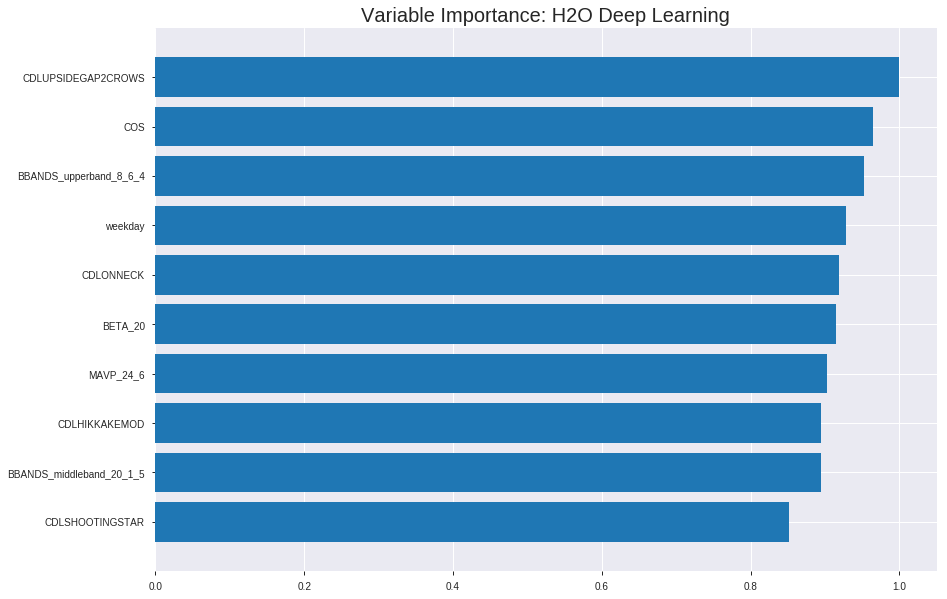

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190824_165925


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.267923294012747
RMSE: 0.5176130736493689
LogLoss: 0.7434179986020185
Mean Per-Class Error: 0.441437249475348
AUC: 0.5671318400310745
pr_auc: 0.5566109306430482
Gini: 0.13426368006214906
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4799531889809948: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      60   842   0.9335   (842.0/902.0)
1      18   804   0.0219   (18.0/822.0)
Total  78   1646  0.4988   (860.0/1724.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.479953     0.65154   345
max f2                       0.210645     0.821179  394
max f0point5                 0.479953     0.542803  345
max accuracy                 0.659939     0.564385  201
max precision                0.99987      1         0
max recall                   0.210645     1         394
max specificity              0.99987      1         0
max absolute_mcc             0.92199      0.125447  28
max min_per_class_accuracy   0.566927     0.550998  281
max mean_per_class_accuracy  0.632493     0.558563  223

Gains/Lift Table: Avg response rate: 47.68 %, avg score: 60.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104408                   0.9541             1.98081   1.98081            0.944444         0.984347  0.944444                    0.984347            0.0206813       0.0206813                  98.0806   98.0806
    2        0.0203016                   0.932196           1.72721   1.85763            0.823529         0.94359   0.885714                    0.964551            0.0170316       0.0377129                  72.7208   85.7629
    3        0.0301624                   0.917442           1.23372   1.65366            0.588235         0.924276  0.788462                    0.951384            0.0121655       0.0498783                  23.372    65.3659
    4        0.0400232                   0.905806           1.11035   1.5198             0.529412         0.911442  0.724638                    0.941543            0.0109489       0.0608273                  11.0348   51.98
    5        0.050464                    0.897178           1.2817    1.47054            0.611111         0.901545  0.701149                    0.933268            0.013382        0.0742092                  28.1698   47.0537
    6        0.100348                    0.85011            1.14621   1.30931            0.546512         0.874292  0.624277                    0.90395             0.0571776       0.131387                   14.6212   30.9312
    7        0.150232                    0.786961           1.07305   1.23086            0.511628         0.820285  0.586873                    0.876169            0.053528        0.184915                   7.30493   23.0862
    8        0.200116                    0.73427            1.1706    1.21584            0.55814          0.759378  0.57971                     0.847056            0.0583942       0.243309                   17.0599   21.584
    9        0.299884                    0.672779           1.09744   1.17645            0.523256         0.700966  0.560928                    0.798454            0.109489        0.352798                   9.74368   17.6448
    10       0.400232                    0.619245           1.0426    1.14289            0.49711          0.646034  0.544928                    0.760238            0.104623        0.457421                   4.26002   14.2889
    11       0.5                         0.564871           0.963306  1.10706            0.459302         0.592452  0.527842                    0.726759            0.0961071       0.553528                   -3.66944  10.7056
    12       0.599768                    0.501483           0.792593  1.05475            0.377907         0.535478  0.502901                    0.69494             0.0790754       0.632603                   -20.7407  5.47469
    13       0.954756                    0.479953           0.973268  1.02445            0.464052         0.480756  0.488457                    0.615305            0.345499        0.978102                   -2.67322  2.44521
    14       1                           0.0288695          0.483998  1                  0.230769         0.370354  0.476798                    0.604222            0.0218978       1                          -51.6002  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3123937695352084
RMSE: 0.558921970882527
LogLoss: 0.8813195522628027
Mean Per-Class Error: 0.479322437636472
AUC: 0.5097101832859128
pr_auc: 0.5319188536479686
Gini: 0.019420366571825554
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10159070528525188: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    238  1        (238.0/238.0)
1      0    254  0        (0.0/254.0)
Total  0    492  0.4837   (238.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.101591     0.680965   399
max f2                       0.101591     0.842175   399
max f0point5                 0.101591     0.571557   399
max accuracy                 0.584503     0.528455   284
max precision                0.999992     1          0
max recall                   0.101591     1          399
max specificity              0.999992     1          0
max absolute_mcc             0.118808     0.0876378  396
max min_per_class_accuracy   0.682919     0.503937   194
max mean_per_class_accuracy  0.584503     0.520678   284

Gains/Lift Table: Avg response rate: 51.63 %, avg score: 68.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.96192            1.1622    1.1622             0.6              0.976291  0.6                         0.976291            0.011811        0.011811                   16.2205   16.2205
    2        0.0203252                   0.954194           1.54961   1.35591            0.8              0.958555  0.7                         0.967423            0.015748        0.0275591                  54.9606   35.5906
    3        0.0304878                   0.942484           1.1622    1.29134            0.6              0.94873   0.666667                    0.961192            0.011811        0.0393701                  16.2205   29.1339
    4        0.0406504                   0.939206           0.387402  1.06535            0.2              0.941634  0.55                        0.956302            0.00393701      0.0433071                  -61.2598  6.53543
    5        0.050813                    0.928535           1.1622    1.08472            0.6              0.933404  0.56                        0.951723            0.011811        0.0551181                  16.2205   8.47244
    6        0.101626                    0.906011           1.1622    1.12346            0.6              0.916108  0.58                        0.933915            0.0590551       0.114173                   16.2205   12.3465
    7        0.150407                    0.890613           0.968504  1.07321            0.5              0.898601  0.554054                    0.922462            0.0472441       0.161417                   -3.14961  7.32071
    8        0.20122                     0.869803           0.697323  0.978287           0.36             0.881004  0.505051                    0.911993            0.0354331       0.19685                    -30.2677  -2.17132
    9        0.300813                    0.818538           1.0278    0.99468            0.530612         0.8449    0.513514                    0.88978             0.102362        0.299213                   2.78001   -0.532028
    10       0.400407                    0.760407           1.10686   1.02258            0.571429         0.791809  0.527919                    0.865411            0.110236        0.409449                   10.6862   2.25828
    11       0.5                         0.682645           0.948739  1.00787            0.489796         0.719413  0.520325                    0.83633             0.0944882       0.503937                   -5.12614  0.787402
    12       0.599593                    0.634732           1.10686   1.02432            0.571429         0.659985  0.528814                    0.807039            0.110236        0.614173                   10.6862   2.4316
    13       0.699187                    0.59754            0.988269  1.01918            0.510204         0.617028  0.526163                    0.779974            0.0984252       0.712598                   -1.17307  1.91815
    14       0.79878                     0.554981           0.909208  1.00547            0.469388         0.578558  0.519084                    0.754861            0.0905512       0.80315                    -9.07922  0.546974
    15       0.898374                    0.496433           0.909208  0.994798           0.469388         0.52646   0.513575                    0.72954             0.0905512       0.893701                   -9.07922  -0.520184
    16       1                           0.101591           1.04598   1                  0.54             0.326994  0.51626                     0.688631   


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 16:59:26  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 16:59:26  0.455 sec   7696 obs/sec      1         1             1724       0.585449         1.13443             -0.373961      0.522943        0.503938           1.16518          0.519722                         0.619522           1.46241               -0.536857        0.51411           0.542091             1.54961            0.479675
    2019-08-24 16:59:28  1.885 sec   11030 obs/sec     10        10            17240      0.517613         0.743418            -0.0740058     0.567132        0.556611           1.98081          0.49884                          0.558922           0.88132               -0.250898        0.50971           0.531919             1.1622             0.48374

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
CDLUPSIDEGAP2CROWS       1.0                    1.0                  0.001676107465058063
COS                      0.9646788239479065     0.9646788239479065   0.001616905378202519
BBANDS_upperband_8_6_4   0.9527764320373535     0.9527764320373535   0.0015969556902691944
weekday                  0.928522527217865      0.928522527217865    0.0015563035393444421
CDLONNECK                0.9186142683029175     0.9186142683029175   0.0015396962326113704
---                      ---                    ---                  ---
BBANDS_lowerband_12_2_5  0.30842214822769165    0.30842214822769165  0.0005169486650336784
ADD                      0.30134209990501404    0.30134209990501404  0.0005050817431870667
STDDEV_20                0.2850874960422516     0.2850874960422516   0.0004778372803111289
BBANDS_lowerband_12_6_4  0.26342877745628357    0.26342877745628357  0.0004415349404055961
BBANDS_lowerband_20_6_2  0.2433449774980545     0.2433449774980545   0.0004078723333688755


See the whole table with table.as_data_frame()


('accuracy', 0.5587044534412956)

('F1', 0.6844919786096256)

('auc', 0.5481223739495799)

('logloss', 0.6978351421307661)

('mean_per_class_error', 0.4296218487394958)

('rmse', 0.5021055190725999)

('mse', 0.25210995228316496)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


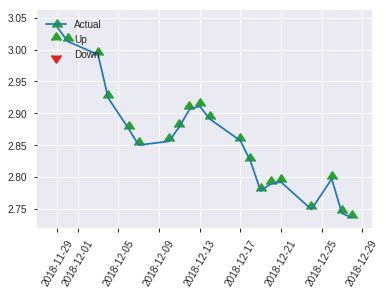


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25210995228316496
RMSE: 0.5021055190725999
LogLoss: 0.6978351421307661
Mean Per-Class Error: 0.4296218487394958
AUC: 0.5481223739495799
pr_auc: 0.5974763542460745
Gini: 0.09624474789915971
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23330457869961854: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    118  0.9916   (118.0/119.0)
1      0    128  0        (0.0/128.0)
Total  1    246  0.4777   (118.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.233305     0.684492  69
max f2                       0.233305     0.844327  69
max f0point5                 0.233305     0.57554   69
max accuracy                 0.48774      0.558704  44
max precision                0.71494      1         0
max recall                   0.233305     1         69
max specificity              0.71494      1         0
max absolute_mcc             0.48774      0.182207  44
max min_per_class_accuracy   0.480641     0.28125   52
max mean_per_class_accuracy  0.48774      0.570378  44

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 48.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.591614           1.92969   1.92969            1                0.645062  1                           0.645062            0.0234375       0.0234375                  92.9688   92.9688
    2        0.0202429                   0.556769           0         1.15781            0                0.577394  0.6                         0.617995            0               0.0234375                  -100      15.7812
    3        0.0323887                   0.546956           1.28646   1.20605            0.666667         0.551718  0.625                       0.593141            0.015625        0.0390625                  28.6458   20.6055
    4        0.0404858                   0.541938           1.92969   1.35078            1                0.546699  0.7                         0.583853            0.015625        0.0546875                  92.9688   35.0781
    5        0.0526316                   0.533939           1.28646   1.33594            0.666667         0.539015  0.692308                    0.573505            0.015625        0.0703125                  28.6458   33.5938
    6        0.101215                    0.517724           0.804036  1.08063            0.416667         0.523634  0.56                        0.549567            0.0390625       0.109375                   -19.5964  8.0625
    7        0.149798                    0.50096            1.60807   1.25169            0.833333         0.509075  0.648649                    0.536435            0.078125        0.1875                     60.8073   25.1689
    8        0.202429                    0.483457           1.48438   1.31219            0.769231         0.491057  0.68                        0.524637            0.078125        0.265625                   48.4375   31.2188
    9        0.935223                    0.479953           0.895546  0.985728           0.464088         0.479993  0.510823                    0.489656            0.65625         0.921875                   -10.4454  -1.42722
    10       1                           0.173982           1.20605   1                  0.625            0.348313  0.518219                    0.4805              0.078125        1                          20.6055   0

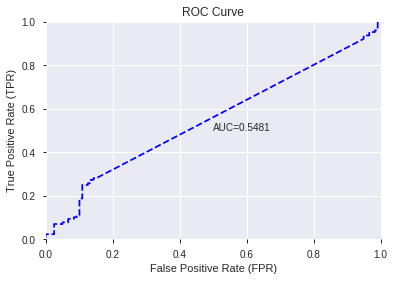

This function is available for GLM models only


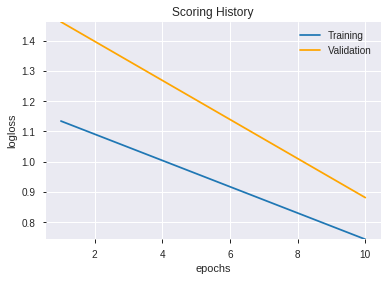

--2019-08-24 17:28:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.229.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.229.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190824_165925',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190824_165925',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_8441',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_2_sid_8441',


In [16]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_172835_model_2  0.533482  0.742452              0.486804  0.520151  0.270557
1  DeepLearning_grid_1_AutoML_20190824_172835_model_3  0.514378  0.775129              0.495798  0.513305  0.263482
2               DeepLearning_1_AutoML_20190824_172835  0.513196  0.775996              0.478401  0.512569  0.262727
3  DeepLearning_grid_1_AutoML_20190824_172835_model_1  0.511949  0.953048              0.486804  0.565959  0.320309
4  DeepLearning_grid_1_AutoML_20190824_172835_model_5  0.509913  0.706801              0.500000  0.506710  0.256755
5  DeepLearning_grid_1_AutoML_20190824_172835_model_7  0.504858  0.687989              0.478696  0.497496  0.247502
6  DeepLearning_grid_1_AutoML_20190824_172835_model_6  0.504136  0.693916              0.487395  0.500402  0.250402
7  DeepLearning_grid_1_AutoML_20190824_172835_model_8  0.495798  0.692559              0.500000  0.499706  0.249706
8  DeepLearning_grid_1_AutoML_20190824_172835_model_4  0.480305  0.837496              0.500000  0.542764  0.294593
9  DeepLearning_grid_1_AutoML_20190824_172835_model_9  0.463006  0.692937              0.491597  0.499895  0.249895

variable  relative_importance  scaled_importance  percentage
0                        TAN             1.000000           1.000000    0.027799
1         CDLEVENINGDOJISTAR             0.998569           0.998569    0.027759
2         CDLUPSIDEGAP2CROWS             0.988304           0.988304    0.027474
3             CDL3LINESTRIKE             0.964275           0.964275    0.026806
4                        day             0.935806           0.935806    0.026014
5                AROONOSC_30             0.917093           0.917093    0.025494
6                    weekday             0.901331           0.901331    0.025056
7               weekday_name             0.889541           0.889541    0.024728
8              CDLHIKKAKEMOD             0.886416           0.886416    0.024641
9                  CORREL_14             0.829203           0.829203    0.023051
10                    ADX_24             0.810625           0.810625    0.022534
11              aroondown_12             0.803529           0.803529    0.022337
12                   NATR_30             0.801489           0.801489    0.022280
13                PLUS_DI_20             0.795941           0.795941    0.022126
14                   BETA_20             0.789854           0.789854    0.021957
15                   WILLR_8             0.776002           0.776002    0.021572
16                 CDLONNECK             0.758783           0.758783    0.021093
17                    ADXR_8             0.750148           0.750148    0.020853
18                  WILLR_24             0.721545           0.721545    0.020058
19                   ROCP_14             0.718039           0.718039    0.019960
20           CDLSHOOTINGSTAR             0.708336           0.708336    0.019691
21                       COS             0.707551           0.707551    0.019669
22                  WILLR_12             0.681539           0.681539    0.018946
23                    MAX_30             0.674267           0.674267    0.018744
24   BBANDS_lowerband_24_7_4             0.666331           0.666331    0.018523
25                    ADX_12             0.659518           0.659518    0.018334
26  BBANDS_middleband_20_1_5             0.652267           0.652267    0.018132
27    LINEARREG_INTERCEPT_30             0.646203           0.646203    0.017964
28  BBANDS_middleband_30_5_2             0.643147           0.643147    0.017879
29  BBANDS_middleband_24_0_2             0.642621           0.642621    0.017864
30  BBANDS_middleband_24_7_5             0.639310           0.639310    0.017772
31   BBANDS_lowerband_30_2_4             0.636840           0.636840    0.017703
32   BBANDS_upperband_30_6_3             0.636517           0.636517    0.017694
33   BBANDS_upperband_24_6_4             0.634993           0.634993    0.017652
34   BBANDS_upperband_12_1_5             0.634416           0.634416    0.017636
35                        LN             0.632375           0.632375    0.017579
36   BBANDS_lowerband_14_1_4             0.629253           0.629253    0.017492
37   BBANDS_upperband_30_5_3             0.629159           0.629159    0.017490
38                   MA_12_2             0.622686           0.622686    0.017310
39                 MAVP_24_6             0.619460           0.619460    0.017220
40   BBANDS_upperband_12_4_4             0.619454           0.619454    0.017220
41  BBANDS_middleband_24_5_4             0.614457           0.614457    0.017081
42   BBANDS_upperband_20_1_4             0.598785           0.598785    0.016645
43    BBANDS_upperband_8_6_4             0.598603           0.598603    0.016640
44               MIDPRICE_24             0.597348           0.597348    0.016605
45                   MA_30_7             0.595915           0.595915    0.016566
46   BBANDS_lowerband_14_4_3             0.593533           0.593533    0.016499
47   BBANDS_upperband_24_2_3             0.586079           0.586079    0.016292
48                 MAVP_24_3             0.577311  

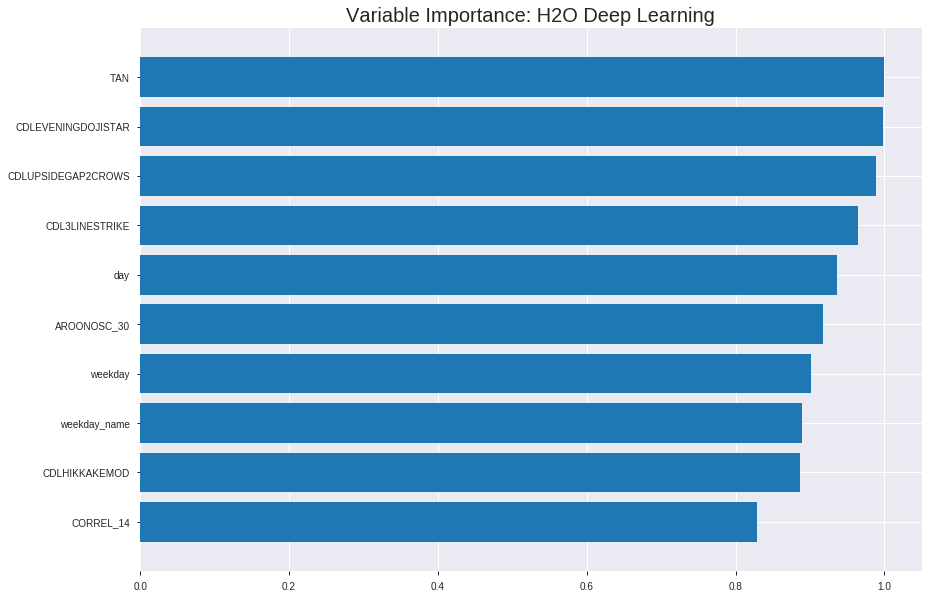

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_172835_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2614809721791087
RMSE: 0.5113521019601941
LogLoss: 0.7214338657047593
Mean Per-Class Error: 0.46408764518965695
AUC: 0.5380210777887474
pr_auc: 0.5083021027027923
Gini: 0.07604215557749483
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17777256672805652: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      17   885   0.9812   (885.0/902.0)
1      5    817   0.0061   (5.0/822.0)
Total  22   1702  0.5162   (890.0/1724.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.177773     0.647385   383
max f2                       0.0185544    0.820196   398
max f0point5                 0.308148     0.541558   325
max accuracy                 0.651747     0.538863   87
max precision                0.995243     1          0
max recall                   0.0185544    1          398
max specificity              0.995243     1          0
max absolute_mcc             0.308148     0.0821165  325
max min_per_class_accuracy   0.469599     0.519465   207
max mean_per_class_accuracy  0.445394     0.535912   225

Gains/Lift Table: Avg response rate: 47.68 %, avg score: 47.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104408                   0.828233           1.2817    1.2817             0.611111         0.864642  0.611111                    0.864642            0.013382        0.013382                   28.1698   28.1698
    2        0.0203016                   0.799243           0.863604  1.07862            0.411765         0.812393  0.514286                    0.839264            0.00851582      0.0218978                  -13.6396  7.86236
    3        0.0301624                   0.776128           1.48046   1.20999            0.705882         0.787317  0.576923                    0.822281            0.0145985       0.0364964                  48.0464   20.9994
    4        0.0400232                   0.761558           1.11035   1.18544            0.529412         0.769739  0.565217                    0.809336            0.0109489       0.0474453                  11.0348   18.5444
    5        0.050464                    0.740403           1.2817    1.20536            0.611111         0.752283  0.574713                    0.797532            0.013382        0.0608273                  28.1698   20.5358
    6        0.100348                    0.682358           1.02427   1.11534            0.488372         0.711198  0.531792                    0.754615            0.0510949       0.111922                   2.42743   11.534
    7        0.150232                    0.640572           1.1706    1.13369            0.55814          0.660978  0.540541                    0.723523            0.0583942       0.170316                   17.0599   13.3688
    8        0.200116                    0.607087           0.853562  1.06386            0.406977         0.624842  0.507246                    0.698924            0.0425791       0.212895                   -14.6438  6.38598
    9        0.299884                    0.55551            1.13402   1.0872             0.540698         0.578614  0.518375                    0.658898            0.113139        0.326034                   13.4018   8.72006
    10       0.400232                    0.511333           0.921368  1.04562            0.439306         0.533147  0.498551                    0.627369            0.0924574       0.418491                   -7.86324  4.56222
    11       0.5                         0.468011           1.03647   1.0438             0.494186         0.488296  0.49768                     0.599619            0.103406        0.521898                   3.64681   4.37956
    12       0.599768                    0.429141           1.07305   1.04866            0.511628         0.44858   0.5                         0.574495            0.107056        0.628954                   7.30493   4.86618
    13       0.700116                    0.388948           0.884998  1.0252             0.421965         0.410664  0.488815                    0.551013            0.0888078       0.717762                   -11.5002  2.52037
    14       0.799884                    0.346308           1.10963   1.03573            0.52907          0.367185  0.493836                    0.528084            0.110706        0.828467                   10.9631   3.57341
    15       0.899652                    0.296843           0.926724  1.02365            0.44186          0.322955  0.488072                    0.505336            0.0924574       0.920925                   -7.32756  2.36454
    16       1                           0.00381005         0.788012  1                  0.375723         0.236801  0.476798                    0.478389          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2874367569314227
RMSE: 0.5361312870290473
LogLoss: 0.8598343822420945
Mean Per-Class Error: 0.48671673393766957
AUC: 0.4870227618606498
pr_auc: 0.4956503787795597
Gini: -0.0259544762787004
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08369687882632426: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    237  0.9958   (237.0/238.0)
1      0    254  0        (0.0/254.0)
Total  1    491  0.4817   (237.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0836969    0.681879  398
max f2                       0.0836969    0.842734  398
max f0point5                 0.0836969    0.572588  398
max accuracy                 0.0934954    0.518293  396
max precision                0.669334     0.55      18
max recall                   0.0836969    1         398
max specificity              1            0.995798  0
max absolute_mcc             0.850661     0.104676  4
max min_per_class_accuracy   0.41433      0.507874  200
max mean_per_class_accuracy  0.445027     0.513283  166

Gains/Lift Table: Avg response rate: 51.63 %, avg score: 42.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.834762           0         0                  0                0.939077  0                           0.939077            0               0                          -100      -100
    2        0.0203252                   0.733555           1.54961   0.774803           0.8              0.804364  0.4                         0.871721            0.015748        0.015748                   54.9606   -22.5197
    3        0.0304878                   0.687266           0.774803  0.774803           0.4              0.711336  0.4                         0.818259            0.00787402      0.023622                   -22.5197  -22.5197
    4        0.0406504                   0.66696            1.93701   1.06535            1                0.675966  0.55                        0.782686            0.019685        0.0433071                  93.7008   6.53543
    5        0.050813                    0.647203           0.387402  0.929764           0.2              0.656203  0.48                        0.757389            0.00393701      0.0472441                  -61.2598  -7.02362
    6        0.101626                    0.600925           0.697323  0.813543           0.36             0.621737  0.42                        0.689563            0.0354331       0.0826772                  -30.2677  -18.6457
    7        0.150407                    0.568451           0.968504  0.863801           0.5              0.589363  0.445946                    0.657066            0.0472441       0.129921                   -3.14961  -13.6199
    8        0.20122                     0.540889           1.23969   0.958721           0.64             0.552728  0.494949                    0.630718            0.0629921       0.192913                   23.9685   -4.12789
    9        0.300813                    0.48602            0.948739  0.955416           0.489796         0.514037  0.493243                    0.592087            0.0944882       0.287402                   -5.12614  -4.4584
    10       0.400407                    0.446071           1.22545   1.02258            0.632653         0.465193  0.527919                    0.560525            0.122047        0.409449                   22.5454   2.25828
    11       0.5                         0.412753           0.988269  1.01575            0.510204         0.429466  0.52439                     0.534419            0.0984252       0.507874                   -1.17307  1.5748
    12       0.599593                    0.376733           0.948739  1.00462            0.489796         0.39477   0.518644                    0.511223            0.0944882       0.602362                   -5.12614  0.461764
    13       0.699187                    0.350168           0.909208  0.991027           0.469388         0.361982  0.511628                    0.489965            0.0905512       0.692913                   -9.07922  -0.897272
    14       0.79878                     0.314158           0.988269  0.990683           0.510204         0.333462  0.51145                     0.470452            0.0984252       0.791339                   -1.17307  -0.931658
    15       0.898374                    0.251766           0.948739  0.986033           0.489796         0.292851  0.50905                     0.450763            0.0944882       0.885827                   -5.12614  -1.39666
    16       1                           0.0730207          1.12346   1                  0.58             0.16082   0.51626                     0.421298 


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 17:29:22  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 17:29:25  48.830 sec        7099 obs/sec      9.61137   1             16570      0.511352         0.721434            -0.0481809     0.538021        0.508302           1.2817           0.516241                         0.536131           0.859834              -0.150964        0.487023          0.49565              0                  0.481707
    2019-08-24 17:29:31  54.669 sec        10251 obs/sec     48.1276   5             82972      0.540256         0.830296            -0.170028      0.579887        0.537664           1.51473          0.476218                         0.565678           1.0692                -0.281321        0.476452          0.485071             0.387402           0.47561
    2019-08-24 17:29:36  1 min  0.199 sec  12251 obs/sec     96.2541   10            165942     0.496548         0.696653            0.0116316      0.623506        0.57686            1.74777          0.420534                         0.550985           0.944263              -0.215626        0.486725          0.491473             0.774803           0.481707
    2019-08-24 17:29:42  1 min  6.048 sec  13757 obs/sec     154.065   16            265608     0.496323         0.705966            0.0125265      0.653498        0.599522           1.74777          0.416473                         0.555716           1.06163               -0.236587        0.490761          0.497162             1.1622             0.469512
    2019-08-24 17:29:48  1 min 11.776 sec  14633 obs/sec     211.807   22            365156     0.476526         0.655902            0.0897322      0.690697        0.640335           1.86429          0.393271                         0.563479           1.13766               -0.271381        0.467379          0.485469             0.774803           0.479675
    2019-08-24 17:29:53  1 min 17.416 sec  15227 obs/sec     269.542   28            464691     0.477968         0.676359            0.0842141      0.713017        0.653343           1.74777          0.363109                         0.573496           1.29888               -0.316981        0.478148          0.484275             0.830146           0.481707
    2019-08-24 17:29:53  1 min 17.499 sec  15225 obs/sec     269.542   28            464691     0.511352         0.721434            -0.0481809     0.538021        0.508302           1.2817           0.516241                         0.536131           0.859834              -0.150964        0.487023          0.49565              0                  0.481707

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
TAN                      1.0                    1.0                  0.02779862951919523
CDLEVENINGDOJISTAR       0.9985686540603638     0.9985686540603638   0.02775884006370548
CDLUPSIDEGAP2CROWS       0.9883044362068176     0.9883044362068176   0.027473508874290443
CDL3LINESTRIKE           0.9642747640609741     0.9642747640609741   0.026805516920840412
day                      0.9358064532279968     0.9358064532279968   0.026014136894957185
---                      ---                    ---                  ---
MA_30_7                  0.5959154963493347     0.5959154963493347   0.016565634107762496
BBANDS_lowerband_14_4_3  0.5935326814651489     0.5935326814651489   0.01649939511958419
BBANDS_upperband_24_2_3  0.5860790014266968     0.5860790014266968   0.016292193029640637
MAVP_24_3                0.5773110389709473     0.5773110389709473   0.016048455689695044
BBANDS_middleband_8_3_3  0.5582273006439209     0.5582273006439209   0.015517953918100772


See the whole table with table.as_data_frame()


('accuracy', 0.5587044534412956)

('F1', 0.6847826086956523)

('auc', 0.5334821428571429)

('logloss', 0.7424515165608572)

('mean_per_class_error', 0.4517791491596639)

('rmse', 0.5201510150731644)

('mse', 0.27055707848164334)

deeplearning prediction progress: |███████████████████████████████████████| 100%


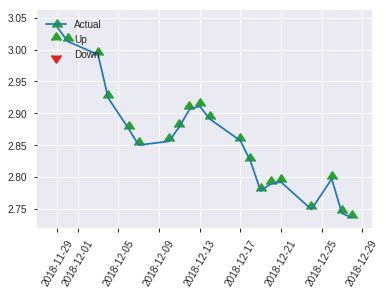


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.27055707848164334
RMSE: 0.5201510150731644
LogLoss: 0.7424515165608572
Mean Per-Class Error: 0.4517791491596639
AUC: 0.5334821428571429
pr_auc: 0.5311390256741783
Gini: 0.06696428571428581
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1821973183737254: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    114  0.958    (114.0/119.0)
1      2    126  0.0156   (2.0/128.0)
Total  7    240  0.4696   (116.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.182197     0.684783  239
max f2                       0.0574036    0.843215  246
max f0point5                 0.308699     0.589207  194
max accuracy                 0.308699     0.558704  194
max precision                0.694473     0.6       19
max recall                   0.0574036    1         246
max specificity              0.806103     0.991597  0
max absolute_mcc             0.308699     0.118202  194
max min_per_class_accuracy   0.436612     0.521008  123
max mean_per_class_accuracy  0.308699     0.548221  194

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 45.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.779468           0         0                  0                0.798297  0                           0.798297            0               0                          -100      -100
    2        0.0202429                   0.765586           0.964844  0.385938           0.5              0.768596  0.2                         0.786417            0.0078125       0.0078125                  -3.51562  -61.4062
    3        0.0323887                   0.747495           1.28646   0.723633           0.666667         0.759663  0.375                       0.776384            0.015625        0.0234375                  28.6458   -27.6367
    4        0.0404858                   0.736507           0.964844  0.771875           0.5              0.742666  0.4                         0.769641            0.0078125       0.03125                    -3.51562  -22.8125
    5        0.0526316                   0.731969           1.28646   0.890625           0.666667         0.734587  0.461538                    0.761551            0.015625        0.046875                   28.6458   -10.9375
    6        0.101215                    0.681736           1.28646   1.08063            0.666667         0.698766  0.56                        0.731414            0.0625          0.109375                   28.6458   8.0625
    7        0.149798                    0.621088           1.12565   1.09523            0.583333         0.64698   0.567568                    0.70403             0.0546875       0.164062                   12.5651   9.5228
    8        0.202429                    0.602038           1.03906   1.08063            0.538462         0.611221  0.56                        0.6799              0.0546875       0.21875                    3.90625   8.0625
    9        0.299595                    0.551868           1.04525   1.06915            0.541667         0.575808  0.554054                    0.64614             0.101562        0.320312                   4.52474   6.91512
    10       0.40081                     0.487657           0.849062  1.01357            0.44             0.513343  0.525253                    0.612606            0.0859375       0.40625                    -15.0938  1.35732
    11       0.502024                    0.436612           1.15781   1.04265            0.6              0.463843  0.540323                    0.582613            0.117188        0.523438                   15.7812   4.26537
    12       0.59919                     0.389183           0.964844  1.03004            0.5              0.41074   0.533784                    0.554742            0.09375         0.617188                   -3.51562  3.00359
    13       0.700405                    0.347985           1.08063   1.03735            0.56             0.368285  0.537572                    0.527797            0.109375        0.726562                   8.0625    3.73465
    14       0.797571                    0.307566           1.12565   1.0481             0.583333         0.322065  0.543147                    0.502733            0.109375        0.835938                   12.5651   4.81044
    15       0.898785                    0.264961           0.771875  1.017              0.4              0.285686  0.527027                    0.478291            0.078125        0.914062                   -22.8125  1.69975
    16       1                           0.0574036          0.849062  1                  0.44             0.208396  0.518219                    0.450974           

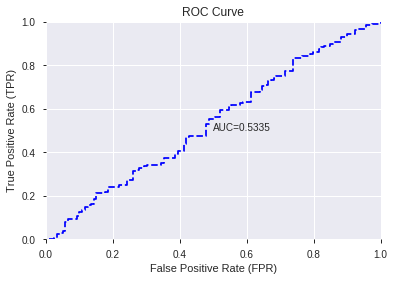

This function is available for GLM models only


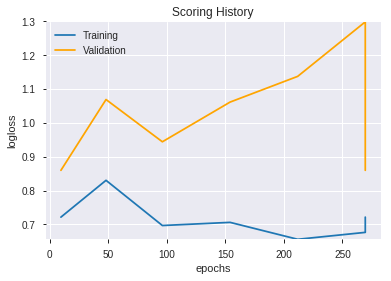

--2019-08-24 17:36:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.129.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.129.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_172835_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_172835_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_8441',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['TAN',
 'CDLEVENINGDOJISTAR',
 'CDLUPSIDEGAP2CROWS',
 'CDL3LINESTRIKE',
 'day',
 'AROONOSC_30',
 'weekday',
 'weekday_name',
 'CDLHIKKAKEMOD',
 'CORREL_14',
 'ADX_24',
 'aroondown_12',
 'NATR_30',
 'PLUS_DI_20',
 'BETA_20',
 'WILLR_8',
 'CDLONNECK',
 'ADXR_8',
 'WILLR_24',
 'ROCP_14',
 'CDLSHOOTINGSTAR',
 'COS',
 'WILLR_12',
 'MAX_30',
 'BBANDS_lowerband_24_7_4',
 'ADX_12',
 'BBANDS_middleband_20_1_5',
 'LINEARREG_INTERCEPT_30',
 'BBANDS_middleband_30_5_2',
 'BBANDS_middleband_24_0_2',
 'BBANDS_middleband_24_7_5',
 'BBANDS_lowerband_30_2_4',
 'BBANDS_upperband_30_6_3',
 'BBANDS_upperband_24_6_4',
 'BBANDS_upperband_12_1_5',
 'LN',
 'BBANDS_lowerband_14_1_4',
 'BBANDS_upperband_30_5_3',
 'MA_12_2',
 'MAVP_24_6',
 'BBANDS_upperband_12_4_4',
 'BBANDS_middleband_24_5_4',
 'BBANDS_upperband_20_1_4',
 'BBANDS_upperband_8_6_4',
 'MIDPRICE_24',
 'MA_30_7',
 'BBANDS_lowerband_14_4_3',
 'BBANDS_upperband_24_2_3',
 'MAVP_24_3',
 'BBANDS_middleband_8_3_3']

In [17]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190824_173642_model_1  0.516019  0.696258              0.483193  0.50155  0.251552

variable  relative_importance  scaled_importance  percentage
0               aroondown_12             0.007793           1.000000    0.075564
1                        day             0.007565           0.970796    0.073357
2                    WILLR_8             0.006990           0.896988    0.067780
3                   WILLR_12             0.006102           0.783030    0.059169
4                 PLUS_DI_20             0.005719           0.733885    0.055455
5                AROONOSC_30             0.004904           0.629246    0.047549
6                    weekday             0.004654           0.597163    0.045124
7                    ROCP_14             0.004641           0.595591    0.045005
8                   WILLR_24             0.004473           0.573919    0.043368
9         CDLEVENINGDOJISTAR             0.003912           0.501964    0.037931
10                   NATR_30             0.003837           0.492418    0.037209
11                       TAN             0.003754           0.481737    0.036402
12            CDL3LINESTRIKE             0.003748           0.480895    0.036338
13        CDLUPSIDEGAP2CROWS             0.003324           0.426504    0.032228
14                   BETA_20             0.003168           0.406501    0.030717
15             CDLHIKKAKEMOD             0.002684           0.344437    0.026027
16                    ADXR_8             0.002400           0.307989    0.023273
17                        LN             0.001855           0.238022    0.017986
18           CDLSHOOTINGSTAR             0.001628           0.208911    0.015786
19                 MAVP_24_3             0.001510           0.193729    0.014639
20    LINEARREG_INTERCEPT_30             0.001490           0.191179    0.014446
21              weekday_name             0.001404           0.180159    0.013614
22   BBANDS_upperband_12_4_4             0.001299           0.166674    0.012595
23                    ADX_12             0.001274           0.163504    0.012355
24   BBANDS_middleband_8_3_3             0.001244           0.159596    0.012060
25                       COS             0.001160           0.148890    0.011251
26   BBANDS_lowerband_14_4_3             0.001059           0.135923    0.010271
27                 MAVP_24_6             0.001017           0.130544    0.009864
28                 CORREL_14             0.000967           0.124137    0.009380
29   BBANDS_upperband_20_1_4             0.000760           0.097535    0.007370
30                   MA_30_7             0.000746           0.095715    0.007233
31  BBANDS_middleband_24_7_5             0.000730           0.093653    0.007077
32   BBANDS_upperband_12_1_5             0.000683           0.087697    0.006627
33                   MA_12_2             0.000666           0.085406    0.006454
34   BBANDS_upperband_24_2_3             0.000622           0.079853    0.006034
35   BBANDS_upperband_24_6_4             0.000370           0.047542    0.003592
36                    ADX_24             0.000364           0.046748    0.003532
37   BBANDS_lowerband_24_7_4             0.000333           0.042755    0.003231
38                 CDLONNECK             0.000326           0.041784    0.003157
39  BBANDS_middleband_20_1_5             0.000303           0.038937    0.002942
40   BBANDS_lowerband_14_1_4             0.000280           0.035870    0.002711
41   BBANDS_upperband_30_5_3             0.000209           0.026799    0.002025
42    BBANDS_upperband_8_6_4             0.000192           0.024592    0.001858
43               MIDPRICE_24             0.000191           0.024517    0.001853
44   BBANDS_lowerband_30_2_4             0.000185           0.023792    0.001798
45  BBANDS_middleband_24_0_2             0.000183           0.023501    0.001776
46   BBANDS_upperband_30_6_3             0.000135           0.017340    0.001310
47  BBANDS_middleband_24_5_4             0.000102           0.013064    0.000987
48                    MAX_30             0.000090  

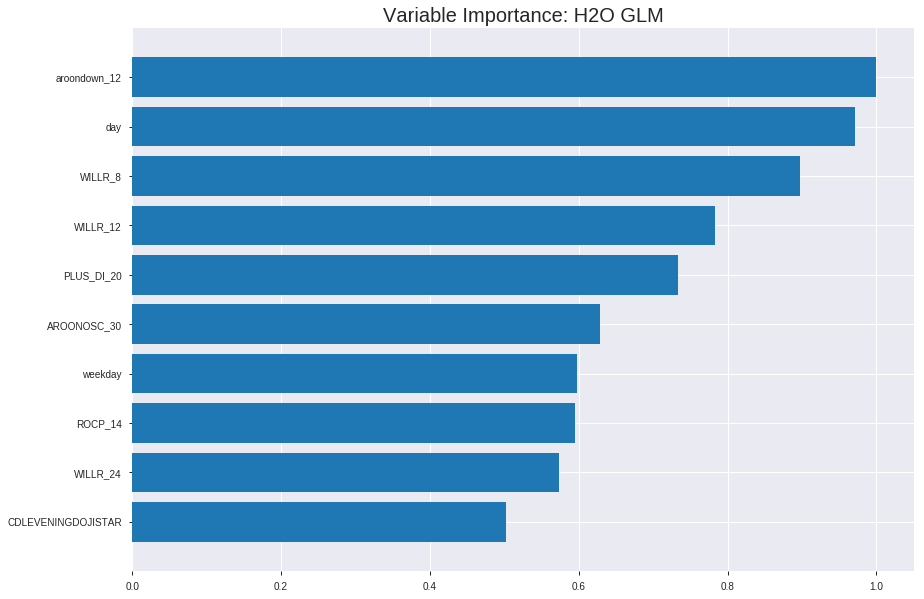

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_173642_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24869107516335684
RMSE: 0.4986893573792776
LogLoss: 0.6905251428039199
Null degrees of freedom: 1723
Residual degrees of freedom: 1673
Null deviance: 2386.25784815377
Residual deviance: 2380.9306923879158
AIC: 2482.9306923879158
AUC: 0.5437915742793792
pr_auc: 0.5272385499970914
Gini: 0.08758314855875837
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4550039350827497: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      10   892   0.9889   (892.0/902.0)
1      2    820   0.0024   (2.0/822.0)
Total  12   1712  0.5186   (894.0/1724.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.455004     0.647198   388
max f2                       0.451347     0.820687   395
max f0point5                 0.465381     0.53524    319
max accuracy                 0.48011      0.546404   162
max precision                0.526654     1          0
max recall                   0.451347     1          395
max specificity              0.526654     1          0
max absolute_mcc             0.491729     0.0895996  55
max min_per_class_accuracy   0.476691     0.522173   197
max mean_per_class_accuracy  0.48011      0.540785   162

Gains/Lift Table: Avg response rate: 47.68 %, avg score: 47.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104408                   0.49792            1.63125   1.63125            0.777778         0.503079  0.777778                    0.503079            0.0170316       0.0170316                  63.1252   63.1252
    2        0.0203016                   0.496248           1.48046   1.55801            0.705882         0.496828  0.742857                    0.500042            0.0145985       0.0316302                  48.0464   55.8012
    3        0.0301624                   0.495184           0.740232  1.29066            0.352941         0.495664  0.615385                    0.498611            0.00729927      0.0389294                  -25.9768  29.0661
    4        0.0400232                   0.494304           1.23372   1.27663            0.588235         0.494741  0.608696                    0.497658            0.0121655       0.0510949                  23.372    27.6632
    5        0.050464                    0.493679           0.815626  1.18125            0.388889         0.494027  0.563218                    0.496906            0.00851582      0.0596107                  -18.4374  18.1251
    6        0.100348                    0.490183           1.31692   1.2487             0.627907         0.491873  0.595376                    0.494404            0.0656934       0.125304                   31.6924   24.8696
    7        0.150232                    0.487695           1.04866   1.18228            0.5              0.488867  0.563707                    0.492565            0.0523114       0.177616                   4.86618   18.2275
    8        0.200116                    0.485289           0.902337  1.11249            0.430233         0.486497  0.530435                    0.491053            0.0450122       0.222628                   -9.76631  11.2493
    9        0.299884                    0.482473           1.07305   1.09937            0.511628         0.483768  0.524178                    0.488629            0.107056        0.329684                   7.30493   9.93708
    10       0.400232                    0.47932            1.11534   1.10337            0.531792         0.480959  0.526087                    0.486706            0.111922        0.441606                   11.534    10.3375
    11       0.5                         0.476607           0.829174  1.04866            0.395349         0.477983  0.5                         0.484965            0.0827251       0.524331                   -17.0826  4.86618
    12       0.599768                    0.473869           1.04866   1.04866            0.5              0.475278  0.5                         0.483354            0.104623        0.628954                   4.86618   4.86618
    13       0.700116                    0.471067           0.921368  1.03042            0.439306         0.472555  0.491301                    0.481806            0.0924574       0.721411                   -7.86324  3.04166
    14       0.799884                    0.468107           0.987693  1.02509            0.47093          0.469622  0.48876                     0.480286            0.0985401       0.819951                   -1.23069  2.50878
    15       0.899652                    0.463794           0.890143  1.01012            0.424419         0.465919  0.481625                    0.478693            0.0888078       0.908759                   -10.9857  1.0123
    16       1                           0.419272           0.909244  1                  0.433526         0.459809  0.476798                    0.476798          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2523561636153108
RMSE: 0.5023506381157595
LogLoss: 0.6981585412527305
Null degrees of freedom: 491
Residual degrees of freedom: 441
Null deviance: 684.603379765711
Residual deviance: 686.9880045926866
AIC: 788.9880045926866
AUC: 0.5045490637199762
pr_auc: 0.5143985672990784
Gini: 0.00909812743995242
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38198705553693113: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    238  1        (238.0/238.0)
1      0    254  0        (0.0/254.0)
Total  0    492  0.4837   (238.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.381987     0.680965   399
max f2                       0.381987     0.842175   399
max f0point5                 0.381987     0.571557   399
max accuracy                 0.483196     0.522358   131
max precision                0.487477     0.578313   74
max recall                   0.381987     1          399
max specificity              0.801358     0.995798   0
max absolute_mcc             0.459341     0.0913646  388
max min_per_class_accuracy   0.477829     0.492126   200
max mean_per_class_accuracy  0.483196     0.528403   131

Gains/Lift Table: Avg response rate: 51.63 %, avg score: 47.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.503624           0.774803  0.774803           0.4              0.57072   0.4                         0.57072             0.00787402      0.00787402                 -22.5197  -22.5197
    2        0.0203252                   0.500904           0.774803  0.774803           0.4              0.50171   0.4                         0.536215            0.00787402      0.015748                   -22.5197  -22.5197
    3        0.0304878                   0.498255           1.1622    0.903937           0.6              0.499711  0.466667                    0.524047            0.011811        0.0275591                  16.2205   -9.6063
    4        0.0406504                   0.497352           0.387402  0.774803           0.2              0.497735  0.4                         0.517469            0.00393701      0.0314961                  -61.2598  -22.5197
    5        0.050813                    0.49591            0.774803  0.774803           0.4              0.4967    0.4                         0.513315            0.00787402      0.0393701                  -22.5197  -22.5197
    6        0.101626                    0.491676           1.23969   1.00724            0.64             0.493963  0.52                        0.503639            0.0629921       0.102362                   23.9685   0.724409
    7        0.150407                    0.488001           1.21063   1.07321            0.625            0.489906  0.554054                    0.499185            0.0590551       0.161417                   21.063    7.32071
    8        0.20122                     0.486217           1.00724   1.05655            0.52             0.48714   0.545455                    0.496143            0.0511811       0.212598                   0.724409  5.65497
    9        0.300813                    0.483785           1.10686   1.07321            0.571429         0.484989  0.554054                    0.49245             0.110236        0.322835                   10.6862   7.32071
    10       0.400407                    0.481025           0.711554  0.983253           0.367347         0.482259  0.507614                    0.489915            0.0708661       0.393701                   -28.8446  -1.67473
    11       0.5                         0.477746           1.0278    0.992126           0.530612         0.479413  0.512195                    0.487823            0.102362        0.496063                   2.78001   -0.787402
    12       0.599593                    0.474797           1.10686   1.01118            0.571429         0.476167  0.522034                    0.485887            0.110236        0.606299                   10.6862   1.11838
    13       0.699187                    0.472298           0.948739  1.00229            0.489796         0.473352  0.517442                    0.484102            0.0944882       0.700787                   -5.12614  0.228896
    14       0.79878                     0.469931           1.06733   1.0104             0.55102          0.471117  0.521628                    0.482483            0.106299        0.807087                   6.73309   1.03985
    15       0.898374                    0.465565           0.790615  0.986033           0.408163         0.468201  0.50905                     0.480899            0.0787402       0.885827                   -20.9385  -1.39666
    16       1                           0.381987           1.12346   1                  0.58             0.457161  0.51626                     0.47848


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 17:36:43  0.000 sec   2            3         51            1.38105           1.39632
    2019-08-24 17:36:43  0.010 sec   4            1.9       51            1.37993           1.40024
    2019-08-24 17:36:43  0.020 sec   6            1.2       51            1.37861           1.40654
    2019-08-24 17:36:43  0.030 sec   8            0.73      51            1.37714           1.4159
    2019-08-24 17:36:43  0.039 sec   10           0.45      51            1.37556           1.4287

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5384615384615384)

('F1', 0.6900269541778976)

('auc', 0.5160189075630253)

('logloss', 0.6962575813340466)

('mean_per_class_error', 0.4618566176470589)

('rmse', 0.5015500254090126)

('mse', 0.2515524279877812)

glm prediction progress: |████████████████████████████████████████████████| 100%


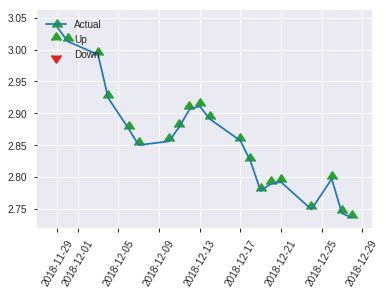


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2515524279877812
RMSE: 0.5015500254090126
LogLoss: 0.6962575813340466
Null degrees of freedom: 246
Residual degrees of freedom: 196
Null deviance: 343.7830139951905
Residual deviance: 343.95124517901894
AIC: 445.95124517901894
AUC: 0.5160189075630253
pr_auc: 0.5352561744013163
Gini: 0.03203781512605053
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4575515715139709: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    115  0.9664   (115.0/119.0)
1      0    128  0        (0.0/128.0)
Total  4    243  0.4656   (115.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.457552     0.690027  242
max f2                       0.457552     0.847682  242
max f0point5                 0.457552     0.581818  242
max accuracy                 0.469838     0.538462  125
max precision                0.532179     1         0
max recall                   0.457552     1         242
max specificity              0.532179     1         0
max absolute_mcc             0.457552     0.133063  242
max min_per_class_accuracy   0.470543     0.53125   122
max mean_per_class_accuracy  0.469838     0.538143  125

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 47.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.495372           1.28646   1.28646            0.666667         0.511766  0.666667                    0.511766            0.015625        0.015625                   28.6458   28.6458
    2        0.0202429                   0.490061           1.92969   1.54375            1                0.490141  0.8                         0.503116            0.015625        0.03125                    92.9688   54.375
    3        0.0323887                   0.488426           0.643229  1.20605            0.333333         0.489586  0.625                       0.498042            0.0078125       0.0390625                  -35.6771  20.6055
    4        0.0404858                   0.487265           0.964844  1.15781            0.5              0.487783  0.6                         0.495991            0.0078125       0.046875                   -3.51562  15.7812
    5        0.0526316                   0.486306           1.28646   1.1875             0.666667         0.486812  0.615385                    0.493872            0.015625        0.0625                     28.6458   18.75
    6        0.101215                    0.483169           0.804036  1.00344            0.416667         0.484683  0.52                        0.489461            0.0390625       0.101562                   -19.5964  0.34375
    7        0.149798                    0.481215           1.12565   1.04307            0.583333         0.482101  0.540541                    0.487074            0.0546875       0.15625                    12.5651   4.30743
    8        0.202429                    0.479291           1.03906   1.04203            0.538462         0.480441  0.54                        0.48535             0.0546875       0.210938                   3.90625   4.20312
    9        0.299595                    0.47602            0.964844  1.017              0.5              0.477857  0.527027                    0.48292             0.09375         0.304688                   -3.51562  1.69975
    10       0.40081                     0.472949           1.00344   1.01357            0.52             0.474764  0.525253                    0.48086             0.101562        0.40625                    0.34375   1.35732
    11       0.502024                    0.470425           1.235     1.05822            0.64             0.471554  0.548387                    0.478984            0.125           0.53125                    23.5      5.82157
    12       0.59919                     0.467589           0.804036  1.017              0.416667         0.468864  0.527027                    0.477343            0.078125        0.609375                   -19.5964  1.69975
    13       0.700405                    0.465136           0.849062  0.992729           0.44             0.466306  0.514451                    0.475748            0.0859375       0.695312                   -15.0938  -0.727059
    14       0.797571                    0.461982           1.04525   0.999128           0.541667         0.463515  0.517766                    0.474258            0.101562        0.796875                   4.52474   -0.0872462
    15       0.898785                    0.459696           1.08063   1.00831            0.56             0.460936  0.522523                    0.472757            0.109375        0.90625                    8.0625    0.830518
    16       1                           0.456              0.92625   1                  0.48             0.458155  0.518219                    0.471279      

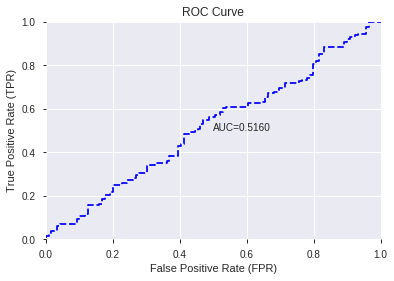

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


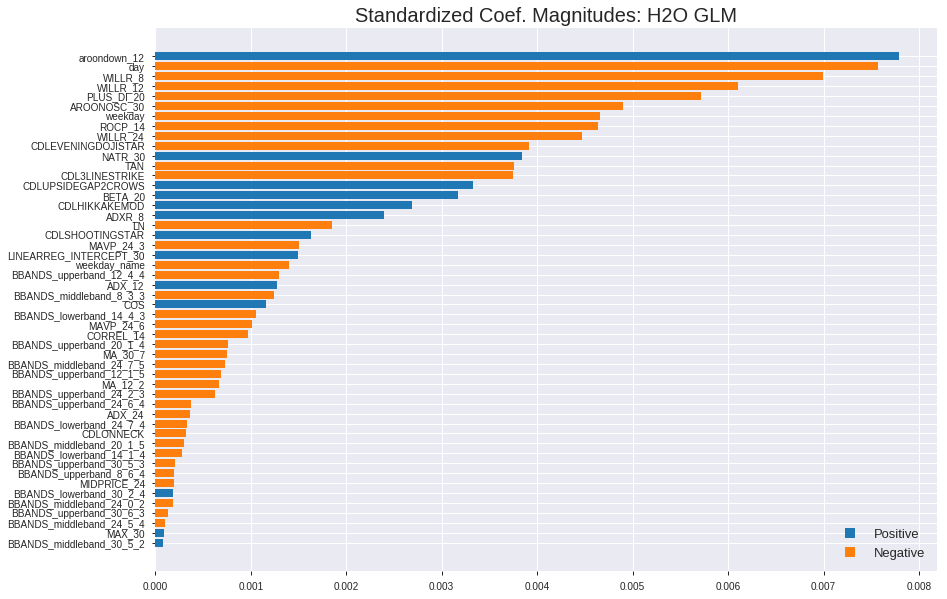

'log_likelihood'
--2019-08-24 17:36:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_173642_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_173642_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_8441',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['aroondown_12',
 'day',
 'WILLR_8',
 'WILLR_12',
 'PLUS_DI_20',
 'AROONOSC_30',
 'weekday',
 'ROCP_14',
 'WILLR_24',
 'CDLEVENINGDOJISTAR',
 'NATR_30',
 'TAN',
 'CDL3LINESTRIKE',
 'CDLUPSIDEGAP2CROWS',
 'BETA_20',
 'CDLHIKKAKEMOD',
 'ADXR_8',
 'LN',
 'CDLSHOOTINGSTAR',
 'MAVP_24_3',
 'LINEARREG_INTERCEPT_30',
 'weekday_name',
 'BBANDS_upperband_12_4_4',
 'ADX_12',
 'BBANDS_middleband_8_3_3',
 'COS',
 'BBANDS_lowerband_14_4_3',
 'MAVP_24_6',
 'CORREL_14',
 'BBANDS_upperband_20_1_4',
 'MA_30_7',
 'BBANDS_middleband_24_7_5',
 'BBANDS_upperband_12_1_5',
 'MA_12_2',
 'BBANDS_upperband_24_2_3',
 'BBANDS_upperband_24_6_4',
 'ADX_24',
 'BBANDS_lowerband_24_7_4',
 'CDLONNECK',
 'BBANDS_middleband_20_1_5',
 'BBANDS_lowerband_14_1_4',
 'BBANDS_upperband_30_5_3',
 'BBANDS_upperband_8_6_4',
 'MIDPRICE_24',
 'BBANDS_lowerband_30_2_4',
 'BBANDS_middleband_24_0_2',
 'BBANDS_upperband_30_6_3',
 'BBANDS_middleband_24_5_4',
 'MAX_30',
 'BBANDS_middleband_30_5_2']

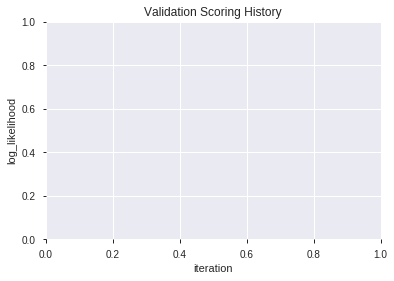

In [18]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_173652_model_3  0.517857  0.703051              0.482898  0.504896  0.254920
1  XGBoost_grid_1_AutoML_20190824_173652_model_5  0.509322  0.747014              0.495798  0.523324  0.273868
2               XGBoost_1_AutoML_20190824_173652  0.508206  0.725949              0.495798  0.515151  0.265380
3  XGBoost_grid_1_AutoML_20190824_173652_model_6  0.505383  0.703974              0.495798  0.505231  0.255258
4  XGBoost_grid_1_AutoML_20190824_173652_model_7  0.504530  0.732827              0.478105  0.518516  0.268859
5  XGBoost_grid_1_AutoML_20190824_173652_model_2  0.504235  0.703611              0.478401  0.505118  0.255144
6  XGBoost_grid_1_AutoML_20190824_173652_model_1  0.498621  0.703275              0.487395  0.504958  0.254982
7               XGBoost_2_AutoML_20190824_173652  0.491991  0.715226              0.495798  0.510598  0.260711
8  XGBoost_grid_1_AutoML_20190824_173652_model_4  0.486738  0.711145              0.500000  0.508732  0.258808
9               XGBoost_3_AutoML_20190824_173652  0.485688  0.714564              0.465205  0.510448  0.260557

variable  relative_importance  scaled_importance  percentage
0                    ROCP_14           285.982056           1.000000    0.073185
1                    BETA_20           221.017990           0.772839    0.056560
2                AROONOSC_30           211.331985           0.738969    0.054082
3                        day           206.269257           0.721266    0.052786
4                  CORREL_14           200.715637           0.701847    0.051365
5                    NATR_30           165.213943           0.577707    0.042280
6                 PLUS_DI_20           159.808914           0.558807    0.040897
7                    WILLR_8           154.884735           0.541589    0.039636
8                     ADX_12           154.424362           0.539979    0.039519
9                   WILLR_12           149.301498           0.522066    0.038208
10                       COS           117.245827           0.409976    0.030004
11                    ADX_24           111.238701           0.388971    0.028467
12   BBANDS_upperband_30_6_3           110.065002           0.384867    0.028167
13   BBANDS_upperband_12_1_5           109.505493           0.382910    0.028023
14                    ADXR_8           106.054832           0.370844    0.027140
15              aroondown_12            92.978745           0.325121    0.023794
16                  WILLR_24            92.174583           0.322309    0.023588
17   BBANDS_lowerband_24_7_4            90.664810           0.317030    0.023202
18   BBANDS_upperband_12_4_4            85.491432           0.298940    0.021878
19                       TAN            72.074799           0.252026    0.018445
20                   weekday            68.899628           0.240923    0.017632
21    BBANDS_upperband_8_6_4            68.338486           0.238961    0.017488
22    LINEARREG_INTERCEPT_30            68.132790           0.238241    0.017436
23                 MAVP_24_6            66.176292           0.231400    0.016935
24   BBANDS_upperband_20_1_4            66.019089           0.230850    0.016895
25                 MAVP_24_3            60.318592           0.210917    0.015436
26   BBANDS_middleband_8_3_3            55.329758           0.193473    0.014159
27              weekday_name            53.969898           0.188718    0.013811
28  BBANDS_middleband_20_1_5            53.169754           0.185920    0.013607
29   BBANDS_upperband_24_6_4            42.583389           0.148902    0.010897
30  BBANDS_middleband_30_5_2            42.059532           0.147071    0.010763
31   BBANDS_lowerband_14_1_4            40.198952           0.140565    0.010287
32   BBANDS_lowerband_30_2_4            39.932648           0.139633    0.010219
33   BBANDS_upperband_24_2_3            38.592091           0.134946    0.009876
34  BBANDS_middleband_24_0_2            37.034950           0.129501    0.009478
35  BBANDS_middleband_24_5_4            36.268105           0.126820    0.009281
36                   MA_12_2            34.435043           0.120410    0.008812
37   BBANDS_lowerband_14_4_3            33.301155           0.116445    0.008522
38  BBANDS_middleband_24_7_5            33.041553           0.115537    0.008456
39   BBANDS_upperband_30_5_3            31.575594           0.110411    0.008080
40                        LN            21.837742           0.076361    0.005588
41                    MAX_30            15.093010           0.052776    0.003862
42               MIDPRICE_24             4.888566           0.017094    0.001251

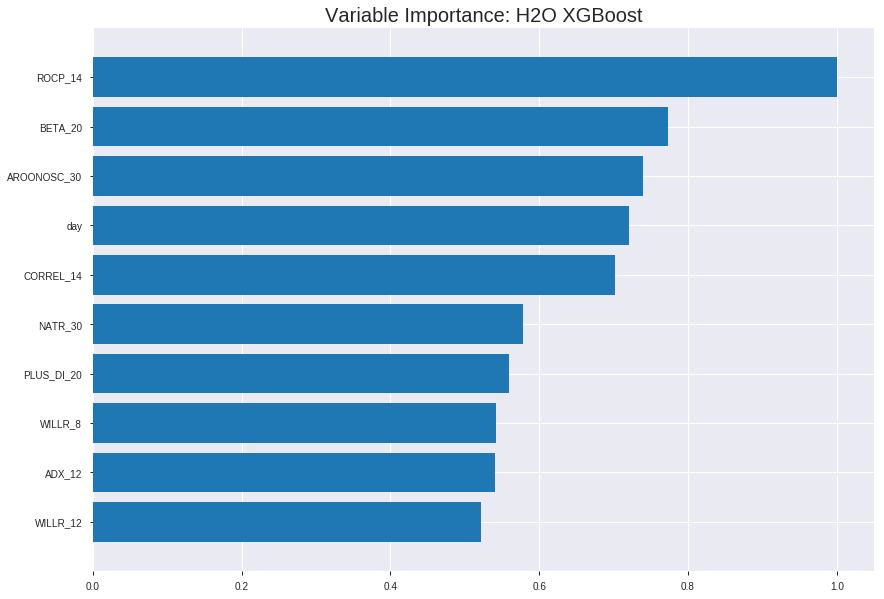

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_173652_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.201655889369851
RMSE: 0.4490611198599262
LogLoss: 0.5943864931661784
Mean Per-Class Error: 0.1980635085050253
AUC: 0.8821617006813731
pr_auc: 0.8718100273865271
Gini: 0.7643234013627462
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4640363082289696: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      678  224  0.2483   (224.0/902.0)
1      127  695  0.1545   (127.0/822.0)
Total  805  919  0.2036   (351.0/1724.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.464036     0.798392  224
max f2                       0.429826     0.872768  266
max f0point5                 0.495329     0.801834  185
max accuracy                 0.476076     0.801044  208
max precision                0.785382     1         0
max recall                   0.374692     1         333
max specificity              0.785382     1         0
max absolute_mcc             0.47013      0.603255  216
max min_per_class_accuracy   0.474301     0.800443  210
max mean_per_class_accuracy  0.47013      0.801936  216

Gains/Lift Table: Avg response rate: 47.68 %, avg score: 47.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104408                   0.690718           2.09732   2.09732            1                0.718055  1                           0.718055            0.0218978       0.0218978                  109.732   109.732
    2        0.0203016                   0.668023           2.09732   2.09732            1                0.677087  1                           0.698156            0.0206813       0.0425791                  109.732   109.732
    3        0.0301624                   0.65624            2.09732   2.09732            1                0.661633  1                           0.686216            0.0206813       0.0632603                  109.732   109.732
    4        0.0400232                   0.641552           2.09732   2.09732            1                0.648957  1                           0.677036            0.0206813       0.0839416                  109.732   109.732
    5        0.050464                    0.629691           1.98081   2.07322            0.944444         0.635473  0.988506                    0.668437            0.0206813       0.104623                   98.0806   107.322
    6        0.100348                    0.595268           1.97539   2.02458            0.94186          0.611706  0.965318                    0.640235            0.0985401       0.203163                   97.5386   102.458
    7        0.150232                    0.571115           1.97539   2.00825            0.94186          0.582197  0.957529                    0.620964            0.0985401       0.301703                   97.5386   100.825
    8        0.200116                    0.553668           1.82906   1.96358            0.872093         0.562393  0.936232                    0.606364            0.0912409       0.392944                   82.9061   96.3581
    9        0.299884                    0.52199            1.62177   1.84986            0.773256         0.538638  0.882012                    0.583832            0.1618          0.554745                   62.1768   84.9864
    10       0.400232                    0.495509           1.43054   1.74473            0.682081         0.508532  0.831884                    0.564952            0.143552        0.698297                   43.0544   74.473
    11       0.5                         0.470911           1.15841   1.62774            0.552326         0.483251  0.776102                    0.54865             0.115572        0.813869                   15.8405   62.7737
    12       0.599768                    0.449697           0.780399  1.48679            0.372093         0.459876  0.708897                    0.533883            0.0778589       0.891727                   -21.9601  48.6787
    13       0.700116                    0.427451           0.606163  1.36057            0.289017         0.438956  0.648716                    0.520277            0.0608273       0.952555                   -39.3837  36.0567
    14       0.799884                    0.404398           0.280456  1.22585            0.133721         0.416515  0.584482                    0.507335            0.0279805       0.980535                   -71.9544  22.5847
    15       0.899652                    0.372911           0.1951    1.11154            0.0930233        0.390406  0.529981                    0.494368            0.0194647       1                          -80.49    11.1541
    16       1                           0.240148           0         1                  0                0.341549  0.476798                    0.479033          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2546644936909982
RMSE: 0.5046429368286038
LogLoss: 0.7032005375856967
Mean Per-Class Error: 0.46024945411235363
AUC: 0.5282538212135248
pr_auc: 0.5470396245698642
Gini: 0.05650764242704964
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2548868954181671: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    236  0.9916   (236.0/238.0)
1      1    253  0.0039   (1.0/254.0)
Total  3    489  0.4817   (237.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.254887     0.681023   396
max f2                       0.216834     0.842175   399
max f0point5                 0.416092     0.574053   299
max accuracy                 0.457543     0.542683   233
max precision                0.761503     1          0
max recall                   0.216834     1          399
max specificity              0.761503     1          0
max absolute_mcc             0.692423     0.0980826  4
max min_per_class_accuracy   0.476625     0.523622   201
max mean_per_class_accuracy  0.457543     0.539751   233

Gains/Lift Table: Avg response rate: 51.63 %, avg score: 47.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.681095           1.93701   1.93701            1                0.728366  1                           0.728366            0.019685        0.019685                   93.7008   93.7008
    2        0.0203252                   0.656267           0.774803  1.35591            0.4              0.670838  0.7                         0.699602            0.00787402      0.0275591                  -22.5197  35.5906
    3        0.0304878                   0.635322           0.774803  1.1622             0.4              0.647293  0.6                         0.682165            0.00787402      0.0354331                  -22.5197  16.2205
    4        0.0406504                   0.620058           0.387402  0.968504           0.2              0.629387  0.5                         0.668971            0.00393701      0.0393701                  -61.2598  -3.14961
    5        0.050813                    0.606001           1.93701   1.1622             1                0.609627  0.6                         0.657102            0.019685        0.0590551                  93.7008   16.2205
    6        0.101626                    0.579848           1.00724   1.08472            0.52             0.592783  0.56                        0.624943            0.0511811       0.110236                   0.724409  8.47244
    7        0.150407                    0.562317           1.04921   1.07321            0.541667         0.570907  0.554054                    0.607418            0.0511811       0.161417                   4.92126   7.32071
    8        0.20122                     0.551407           1.23969   1.11525            0.64             0.557542  0.575758                    0.594823            0.0629921       0.224409                   23.9685   11.5247
    9        0.300813                    0.522984           0.830146  1.02086            0.428571         0.536037  0.527027                    0.57536             0.0826772       0.307087                   -16.9854  2.08555
    10       0.400407                    0.496261           1.06733   1.03242            0.55102          0.508134  0.532995                    0.558639            0.106299        0.413386                   6.73309   3.24154
    11       0.5                         0.476131           1.10686   1.04724            0.571429         0.48529   0.54065                     0.544029            0.110236        0.523622                   10.6862   4.72441
    12       0.599593                    0.454796           1.10686   1.05715            0.571429         0.464759  0.545763                    0.530862            0.110236        0.633858                   10.6862   5.71467
    13       0.699187                    0.428868           0.909208  1.03607            0.469388         0.441707  0.534884                    0.518162            0.0905512       0.724409                   -9.07922  3.6074
    14       0.79878                     0.40384            0.830146  1.0104             0.428571         0.417775  0.521628                    0.505646            0.0826772       0.807087                   -16.9854  1.03985
    15       0.898374                    0.367143           0.948739  1.00356            0.489796         0.388407  0.5181                      0.492649            0.0944882       0.901575                   -5.12614  0.35629
    16       1                           0.216834           0.968504  1                  0.5              0.333887  0.51626                     0.476514         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 17:36:56  1.067 sec   0                  0.5              0.693147            0.5             0                  1                0.523202                         0.5                0.693147              0.5               0                    1                  0.48374
    2019-08-24 17:36:56  1.122 sec   5                  0.494326         0.681845            0.681584        0.659631           1.86429          0.435615                         0.500214           0.693579              0.51258           0.540299             1.54961            0.48374
    2019-08-24 17:36:57  1.165 sec   10                 0.487779         0.668906            0.737943        0.725214           1.86429          0.37007                          0.500323           0.693803              0.516757          0.560567             1.93701            0.481707
    2019-08-24 17:36:57  1.219 sec   15                 0.481917         0.657429            0.779496        0.771372           2.09732          0.343387                         0.500944           0.695069              0.518552          0.557211             1.93701            0.481707
    2019-08-24 17:36:57  1.270 sec   20                 0.477057         0.647934            0.793035        0.786876           2.09732          0.303944                         0.501794           0.696796              0.518403          0.545555             1.93701            0.48374
    2019-08-24 17:36:57  1.322 sec   25                 0.4733           0.640626            0.800704        0.795054           2.09732          0.281323                         0.50193            0.697084              0.522075          0.545859             1.93701            0.48374
    2019-08-24 17:36:57  1.371 sec   30                 0.467275         0.629021            0.830999        0.823684           2.09732          0.269722                         0.502109           0.697476              0.524424          0.542431             1.93701            0.479675
    2019-08-24 17:36:57  1.423 sec   35                 0.462529         0.619913            0.846675        0.838225           2.09732          0.25348                          0.503644           0.700731              0.519884          0.539039             1.93701            0.48374
    2019-08-24 17:36:57  1.480 sec   40                 0.458405         0.612025            0.858715        0.848615           2.09732          0.24478                          0.504297           0.702144              0.520231          0.536255             1.54961            0.48374
    2019-08-24 17:36:57  1.545 sec   45                 0.453048         0.60188             0.872848        0.861937           2.09732          0.203016                         0.505461           0.704799              0.520537          0.538465             1.54961            0.48374
    2019-08-24 17:36:57  1.600 sec   50                 0.449061         0.594386            0.882162        0.87181            2.09732          0.203596                         0.504643           0.703201              0.528254          0.54704              1.93701            0.481707

Variable Importances: 


variable                  relative_importance    scaled_importance     percentage
------------------------  ---------------------  --------------------  ---------------------
ROCP_14                   285.9820556640625      1.0                   0.0731853411370934
BETA_20                   221.0179901123047      0.7728386649962757    0.05656046134168828
AROONOSC_30               211.3319854736328      0.738969390869336     0.054081726960642465
day                       206.26925659179688     0.7212664309053618    0.05278612979654271
CORREL_14                 200.71563720703125     0.7018469628836013    0.051364909404669284
---                       ---                    ---                   ---
BBANDS_middleband_24_7_5  33.04155349731445      0.11553715641560293   0.00845562620628562
BBANDS_upperband_30_5_3   31.575593948364258     0.11041110210584501   0.008080474172938718
LN                        21.83774185180664      0.07636053178615866   0.005588471568179885
MAX_30                    15.093009948730469     0.05277607335776316   0.0038624349325641627
MIDPRICE_24               4.888566017150879      0.017093960688545372  0.001251027344375257


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5506072874493927)

('F1', 0.6883468834688348)

('auc', 0.5178571428571429)

('logloss', 0.7030509715044685)

('mean_per_class_error', 0.4542738970588236)

('rmse', 0.5048956569853494)

('mse', 0.25491962444266764)

xgboost prediction progress: |████████████████████████████████████████████| 100%


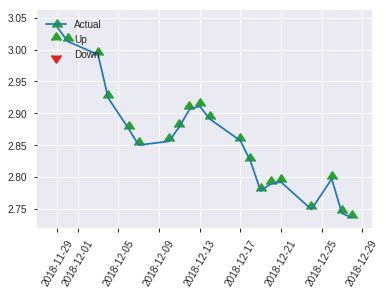


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25491962444266764
RMSE: 0.5048956569853494
LogLoss: 0.7030509715044685
Mean Per-Class Error: 0.4542738970588236
AUC: 0.5178571428571429
pr_auc: 0.5212313505787542
Gini: 0.03571428571428581
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3469291627407074: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    114  0.958    (114.0/119.0)
1      1    127  0.0078   (1.0/128.0)
Total  6    241  0.4656   (115.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.346929     0.688347  240
max f2                       0.312668     0.845443  244
max f0point5                 0.371488     0.584906  232
max accuracy                 0.429221     0.550607  156
max precision                0.66911      1         0
max recall                   0.312668     1         244
max specificity              0.66911      1         0
max absolute_mcc             0.371488     0.114061  232
max min_per_class_accuracy   0.446214     0.487395  123
max mean_per_class_accuracy  0.429221     0.545726  156

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 45.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.586963           1.28646   1.28646            0.666667         0.626872  0.666667                    0.626872            0.015625        0.015625                   28.6458   28.6458
    2        0.0202429                   0.581271           0.964844  1.15781            0.5              0.583385  0.6                         0.609477            0.0078125       0.0234375                  -3.51562  15.7812
    3        0.0323887                   0.573398           0.643229  0.964844           0.333333         0.576735  0.5                         0.597199            0.0078125       0.03125                    -35.6771  -3.51562
    4        0.0404858                   0.567688           0         0.771875           0                0.570912  0.4                         0.591942            0               0.03125                    -100      -22.8125
    5        0.0526316                   0.558135           1.92969   1.03906            1                0.563984  0.538462                    0.58549             0.0234375       0.0546875                  92.9688   3.90625
    6        0.101215                    0.532191           0.964844  1.00344            0.5              0.544961  0.52                        0.566036            0.046875        0.101562                   -3.51562  0.34375
    7        0.149798                    0.511178           0.643229  0.886613           0.333333         0.521492  0.459459                    0.551589            0.03125         0.132812                   -35.6771  -11.3387
    8        0.202429                    0.498442           1.48438   1.04203            0.769231         0.505563  0.54                        0.539623            0.078125        0.210938                   48.4375   4.20312
    9        0.299595                    0.474487           1.04525   1.04307            0.541667         0.49016   0.540541                    0.523581            0.101562        0.3125                     4.52474   4.30743
    10       0.40081                     0.46142            0.771875  0.97459            0.4              0.467888  0.505051                    0.509517            0.078125        0.390625                   -22.8125  -2.54104
    11       0.502024                    0.446214           1.00344   0.980406           0.52             0.45281   0.508065                    0.498084            0.101562        0.492188                   0.34375   -1.95943
    12       0.59919                     0.433662           1.44727   1.05611            0.75             0.440434  0.547297                    0.488735            0.140625        0.632812                   44.7266   5.61128
    13       0.700405                    0.422997           1.00344   1.0485             0.52             0.428141  0.543353                    0.479979            0.101562        0.734375                   0.34375   4.85007
    14       0.797571                    0.407277           0.88444   1.02851            0.458333         0.414676  0.532995                    0.472023            0.0859375       0.820312                   -11.556   2.85136
    15       0.898785                    0.384728           0.849062  1.00831            0.44             0.397327  0.522523                    0.463611            0.0859375       0.90625                    -15.0938  0.830518
    16       1                           0.294793           0.92625   1                  0.48             0.357696  0.518219                    0.452891   

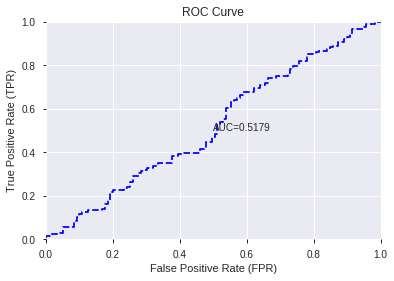

This function is available for GLM models only


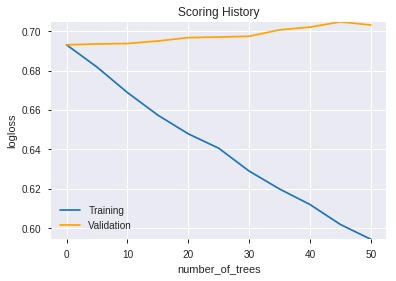

--2019-08-24 17:37:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.115.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.115.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_173652_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_173652_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_8441',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['ROCP_14',
 'BETA_20',
 'AROONOSC_30',
 'day',
 'CORREL_14',
 'NATR_30',
 'PLUS_DI_20',
 'WILLR_8',
 'ADX_12',
 'WILLR_12',
 'COS',
 'ADX_24',
 'BBANDS_upperband_30_6_3',
 'BBANDS_upperband_12_1_5',
 'ADXR_8',
 'aroondown_12',
 'WILLR_24',
 'BBANDS_lowerband_24_7_4',
 'BBANDS_upperband_12_4_4',
 'TAN',
 'weekday',
 'BBANDS_upperband_8_6_4',
 'LINEARREG_INTERCEPT_30',
 'MAVP_24_6',
 'BBANDS_upperband_20_1_4',
 'MAVP_24_3',
 'BBANDS_middleband_8_3_3',
 'weekday_name',
 'BBANDS_middleband_20_1_5',
 'BBANDS_upperband_24_6_4',
 'BBANDS_middleband_30_5_2',
 'BBANDS_lowerband_14_1_4',
 'BBANDS_lowerband_30_2_4',
 'BBANDS_upperband_24_2_3',
 'BBANDS_middleband_24_0_2',
 'BBANDS_middleband_24_5_4',
 'MA_12_2',
 'BBANDS_lowerband_14_4_3',
 'BBANDS_middleband_24_7_5',
 'BBANDS_upperband_30_5_3',
 'LN',
 'MAX_30',
 'MIDPRICE_24']

In [19]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_173710_model_1  0.505712  0.698664               0.47479  0.502741  0.252748

variable  relative_importance  scaled_importance    percentage
0                 CDLTHRUSTING         9.367234e-03           1.000000  1.608365e-02
1                   aroonup_12         7.032796e-03           0.750787  1.207539e-02
2                          day         6.970307e-03           0.744116  1.196810e-02
3                  CDL3OUTSIDE         5.918498e-03           0.631830  1.016213e-02
4            CDLGRAVESTONEDOJI         5.593468e-03           0.597131  9.604050e-03
...                        ...                  ...                ...           ...
1025  BBANDS_middleband_14_1_2         1.180914e-06           0.000126  2.027643e-06
1026                    MA_8_2         1.141812e-06           0.000122  1.960504e-06
1027   BBANDS_middleband_8_1_4         8.159180e-07           0.000087  1.400941e-06
1028  BBANDS_middleband_24_2_3         5.670155e-07           0.000061  9.735724e-07
1029   BBANDS_lowerband_12_1_3         4.019814e-07           0.000043  6.902068e-07

[1030 rows x 4 columns]

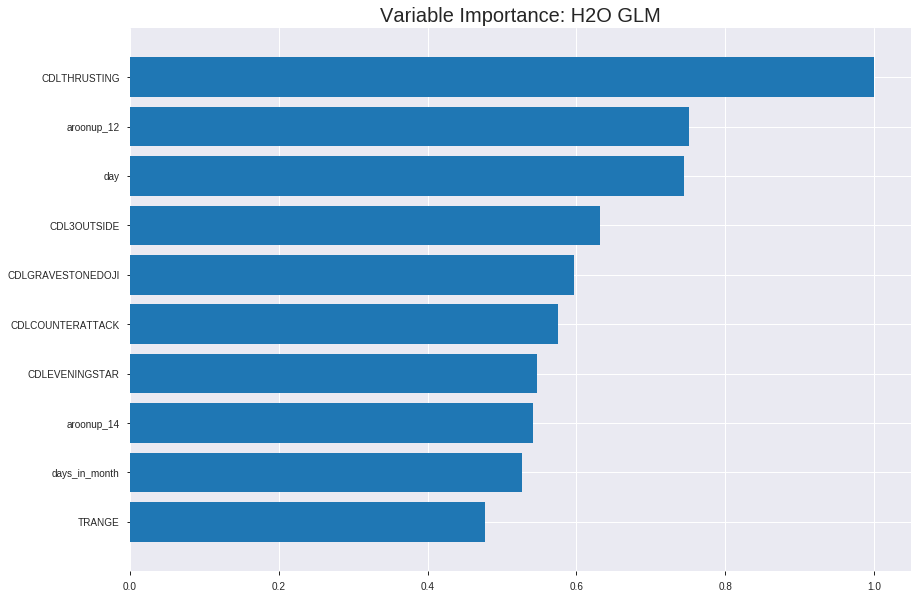

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_173710_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24653174895465965
RMSE: 0.49651963602123494
LogLoss: 0.6861806534450965
Null degrees of freedom: 1723
Residual degrees of freedom: 693
Null deviance: 2386.25784815377
Residual deviance: 2365.950893078693
AIC: 4427.950893078692
AUC: 0.5721214279163362
pr_auc: 0.548351340799308
Gini: 0.1442428558326725
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4161006562713052: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      16   886   0.9823   (886.0/902.0)
1      2    820   0.0024   (2.0/822.0)
Total  18   1706  0.5151   (888.0/1724.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.416101     0.648734  383
max f2                       0.403595     0.821343  391
max f0point5                 0.464517     0.543315  254
max accuracy                 0.491491     0.562065  148
max precision                0.585981     1         0
max recall                   0.403595     1         391
max specificity              0.585981     1         0
max absolute_mcc             0.504344     0.1257    103
max min_per_class_accuracy   0.475565     0.540146  209
max mean_per_class_accuracy  0.486829     0.553834  166

Gains/Lift Table: Avg response rate: 47.68 %, avg score: 47.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104408                   0.550264           1.51473   1.51473            0.722222         0.562406  0.722222                    0.562406            0.0158151       0.0158151                  51.4734    51.4734
    2        0.0203016                   0.536824           1.11035   1.31832            0.529412         0.541972  0.628571                    0.552481            0.0109489       0.026764                   11.0348    31.8318
    3        0.0301624                   0.529207           1.35709   1.33099            0.647059         0.53341   0.634615                    0.546246            0.013382        0.040146                   35.7092    33.0994
    4        0.0400232                   0.525599           1.48046   1.36782            0.705882         0.52752   0.652174                    0.541633            0.0145985       0.0547445                  48.0464    36.782
    5        0.050464                    0.522784           1.39822   1.37411            0.666667         0.524219  0.655172                    0.53803             0.0145985       0.0693431                  39.8216    37.4109
    6        0.100348                    0.510672           1.31692   1.34568            0.627907         0.516115  0.641618                    0.527136            0.0656934       0.135036                   31.6924    34.5682
    7        0.150232                    0.504835           1.19499   1.29564            0.569767         0.5076    0.617761                    0.520649            0.0596107       0.194647                   19.4987    29.5644
    8        0.200116                    0.499147           1.04866   1.23408            0.5              0.501778  0.588406                    0.515945            0.0523114       0.246959                   4.86618    23.4077
    9        0.299884                    0.489912           1.08524   1.18456            0.517442         0.494386  0.564797                    0.508772            0.108273        0.355231                   8.5243     18.4562
    10       0.400232                    0.482722           0.945614  1.12465            0.450867         0.4862    0.536232                    0.503113            0.0948905       0.450122                   -5.43859   12.4652
    11       0.5                         0.474995           0.938918  1.08759            0.447674         0.479048  0.518561                    0.498311            0.093674        0.543796                   -6.10819   8.75912
    12       0.599768                    0.467711           0.987693  1.07097            0.47093          0.47144   0.510638                    0.493841            0.0985401       0.642336                   -1.23069   7.09738
    13       0.700116                    0.461314           0.994107  1.05996            0.473988         0.464533  0.505385                    0.489641            0.0997567       0.742092                   -0.589286  5.99564
    14       0.799884                    0.45487            0.890143  1.03878            0.424419         0.458121  0.495286                    0.485709            0.0888078       0.8309                     -10.9857   3.87759
    15       0.899652                    0.444868           0.816981  1.01418            0.389535         0.450264  0.483559                    0.481778            0.0815085       0.912409                   -18.3019   1.41797
    16       1                           0.383476           0.872875  1                  0.416185         0.432148  0.476798                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.252498666243765
RMSE: 0.5024924539172354
LogLoss: 0.6983451614609718
Null degrees of freedom: 491
Residual degrees of freedom: -539
Null deviance: 684.603379765711
Residual deviance: 687.1716388775963
AIC: 2749.1716388775963
AUC: 0.52152120690796
pr_auc: 0.5264514216948992
Gini: 0.04304241381592
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37999291782368017: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    238  1        (238.0/238.0)
1      0    254  0        (0.0/254.0)
Total  0    492  0.4837   (238.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.379993     0.680965   399
max f2                       0.379993     0.842175   399
max f0point5                 0.451505     0.575292   324
max accuracy                 0.451505     0.536585   324
max precision                0.561072     0.666667   2
max recall                   0.379993     1          399
max specificity              0.759647     0.995798   0
max absolute_mcc             0.425206     0.0717838  382
max min_per_class_accuracy   0.471973     0.508403   199
max mean_per_class_accuracy  0.459352     0.528436   272

Gains/Lift Table: Avg response rate: 51.63 %, avg score: 47.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.552899           0.774803  0.774803           0.4              0.600484  0.4                         0.600484            0.00787402      0.00787402                 -22.5197  -22.5197
    2        0.0203252                   0.537978           1.1622    0.968504           0.6              0.546339  0.5                         0.573411            0.011811        0.019685                   16.2205   -3.14961
    3        0.0304878                   0.532129           0.387402  0.774803           0.2              0.535043  0.4                         0.560622            0.00393701      0.023622                   -61.2598  -22.5197
    4        0.0406504                   0.528792           1.1622    0.871654           0.6              0.531706  0.45                        0.553393            0.011811        0.0354331                  16.2205   -12.8346
    5        0.050813                    0.523054           0.774803  0.852283           0.4              0.525159  0.44                        0.547746            0.00787402      0.0433071                  -22.5197  -14.7717
    6        0.101626                    0.506553           1.31717   1.08472            0.68             0.513548  0.56                        0.530647            0.0669291       0.110236                   31.7165   8.47244
    7        0.150407                    0.500617           1.04921   1.07321            0.541667         0.502726  0.554054                    0.521592            0.0511811       0.161417                   4.92126   7.32071
    8        0.20122                     0.495235           0.929764  1.03698            0.48             0.497868  0.535354                    0.515601            0.0472441       0.208661                   -7.02362  3.6984
    9        0.300813                    0.483837           1.06733   1.04703            0.55102          0.48865   0.540541                    0.506678            0.106299        0.314961                   6.73309   4.70313
    10       0.400407                    0.477996           0.948739  1.02258            0.489796         0.480662  0.527919                    0.500207            0.0944882       0.409449                   -5.12614  2.25828
    11       0.5                         0.472068           0.988269  1.01575            0.510204         0.475156  0.52439                     0.495217            0.0984252       0.507874                   -1.17307  1.5748
    12       0.599593                    0.465478           1.14639   1.03745            0.591837         0.46895   0.535593                    0.490854            0.114173        0.622047                   14.6392   3.74483
    13       0.699187                    0.458421           0.948739  1.02481            0.489796         0.461712  0.52907                     0.486703            0.0944882       0.716535                   -5.12614  2.48123
    14       0.79878                     0.453441           1.0278    1.02518            0.530612         0.455741  0.529262                    0.482842            0.102362        0.818898                   2.78001   2.51848
    15       0.898374                    0.443982           0.830146  1.00356            0.428571         0.449653  0.5181                      0.479163            0.0826772       0.901575                   -16.9854  0.35629
    16       1                           0.379993           0.968504  1                  0.5              0.425719  0.51626                     0.473732      


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 17:37:13  0.000 sec   2            3.4       1031          1.37236           1.39669
    2019-08-24 17:37:15  1.774 sec   4            2.5       1031          1.36979           1.39862
    2019-08-24 17:37:17  3.589 sec   6            1.8       1031          1.36664           1.40137
    2019-08-24 17:37:18  5.386 sec   8            1.3       1031          1.36291           1.4052
    2019-08-24 17:37:20  7.146 sec   10           0.95      1031          1.35858           1.41046

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5465587044534413)

('F1', 0.6937669376693767)

('auc', 0.5057116596638656)

('logloss', 0.6986639315619737)

('mean_per_class_error', 0.46940651260504196)

('rmse', 0.5027407616104704)

('mse', 0.25274827338467587)

glm prediction progress: |████████████████████████████████████████████████| 100%


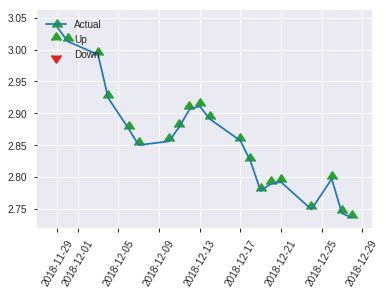


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25274827338467587
RMSE: 0.5027407616104704
LogLoss: 0.6986639315619737
Null degrees of freedom: 246
Residual degrees of freedom: -784
Null deviance: 343.7830139951905
Residual deviance: 345.139982191615
AIC: 2407.1399821916148
AUC: 0.5057116596638656
pr_auc: 0.5250153006208267
Gini: 0.011423319327731107
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42790388289992176: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    113  0.9496   (113.0/119.0)
1      0    128  0        (0.0/128.0)
Total  6    241  0.4575   (113.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.427904     0.693767  240
max f2                       0.427904     0.849934  240
max f0point5                 0.433742     0.587687  235
max accuracy                 0.434585     0.546559  231
max precision                0.535442     1         0
max recall                   0.427904     1         240
max specificity              0.535442     1         0
max absolute_mcc             0.427904     0.163643  240
max min_per_class_accuracy   0.456831     0.495798  123
max mean_per_class_accuracy  0.434585     0.530593  231

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 46.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.516007           1.28646   1.28646            0.666667         0.527414  0.666667                    0.527414            0.015625        0.015625                   28.6458   28.6458
    2        0.0202429                   0.512543           0.964844  1.15781            0.5              0.513887  0.6                         0.522003            0.0078125       0.0234375                  -3.51562  15.7812
    3        0.0323887                   0.509653           1.92969   1.44727            1                0.51198   0.75                        0.518245            0.0234375       0.046875                   92.9688   44.7266
    4        0.0404858                   0.501571           0.964844  1.35078            0.5              0.505331  0.7                         0.515662            0.0078125       0.0546875                  -3.51562  35.0781
    5        0.0526316                   0.498568           0         1.03906            0                0.499676  0.538462                    0.511973            0               0.0546875                  -100      3.90625
    6        0.101215                    0.491986           0.643229  0.849062           0.333333         0.494636  0.44                        0.503651            0.03125         0.0859375                  -35.6771  -15.0938
    7        0.149798                    0.483711           1.12565   0.938767           0.583333         0.487797  0.486486                    0.498509            0.0546875       0.140625                   12.5651   -6.12331
    8        0.202429                    0.479248           1.1875    1.00344            0.615385         0.481407  0.52                        0.494063            0.0625          0.203125                   18.75     0.34375
    9        0.299595                    0.469936           0.964844  0.990921           0.5              0.474184  0.513514                    0.487616            0.09375         0.296875                   -3.51562  -0.907939
    10       0.40081                     0.461618           1.00344   0.994081           0.52             0.465781  0.515152                    0.482102            0.101562        0.398438                   0.34375   -0.591856
    11       0.502024                    0.456831           1.00344   0.995968           0.52             0.458935  0.516129                    0.477431            0.101562        0.5                        0.34375   -0.403226
    12       0.59919                     0.450896           0.964844  0.990921           0.5              0.453734  0.513514                    0.473588            0.09375         0.59375                    -3.51562  -0.907939
    13       0.700405                    0.448655           1.15781   1.01504            0.6              0.449717  0.526012                    0.470139            0.117188        0.710938                   15.7812   1.50379
    14       0.797571                    0.444227           0.804036  0.989332           0.416667         0.446103  0.51269                     0.46721             0.078125        0.789062                   -19.5964  -1.06678
    15       0.898785                    0.437175           1.235     1.017              0.64             0.440832  0.527027                    0.46424             0.125           0.914062                   23.5      1.69975
    16       1                           0.419989           0.849062  1                  0.44             0.431896  0.518219                    0.4609

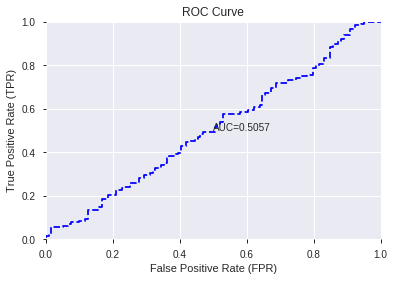

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


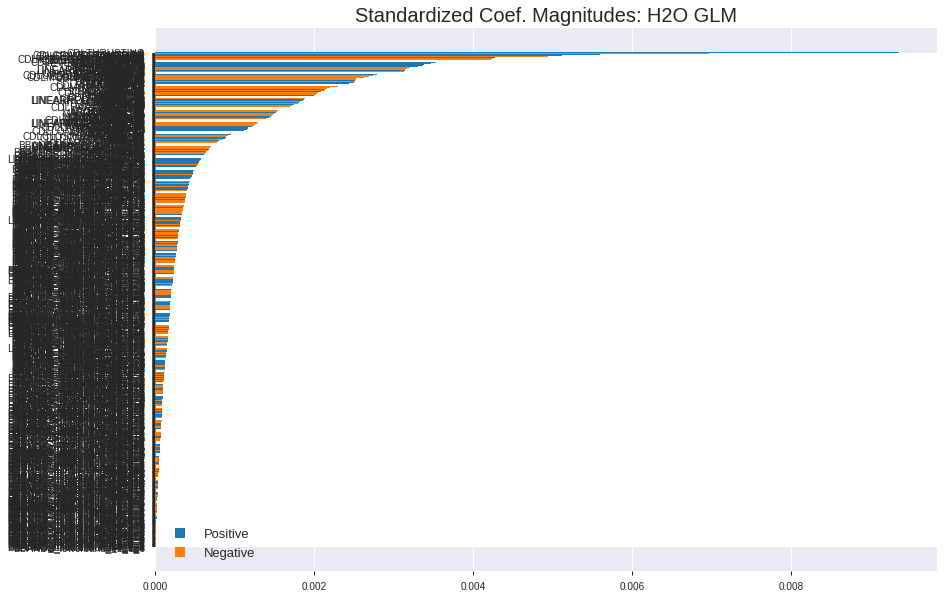

'log_likelihood'
--2019-08-24 17:37:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.233.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.233.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_173710_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_173710_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_8441',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

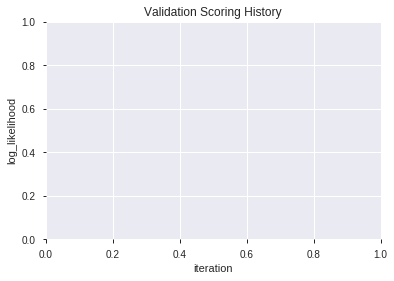

In [20]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [21]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [22]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [23]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_173743_model_6  0.538340  0.711111              0.478105  0.508489  0.258562
1  XGBoost_grid_1_AutoML_20190824_173743_model_2  0.502626  0.709136              0.491597  0.507704  0.257763
2  XGBoost_grid_1_AutoML_20190824_173743_model_5  0.502363  0.737134              0.474199  0.520351  0.270766
3  XGBoost_grid_1_AutoML_20190824_173743_model_1  0.488445  0.711571              0.487395  0.508608  0.258682
4               XGBoost_2_AutoML_20190824_173743  0.471442  0.725063              0.500000  0.515002  0.265227
5  XGBoost_grid_1_AutoML_20190824_173743_model_7  0.471245  0.737977              0.491597  0.520748  0.271178
6  XGBoost_grid_1_AutoML_20190824_173743_model_4  0.469275  0.716060              0.500000  0.511070  0.261193
7               XGBoost_3_AutoML_20190824_173743  0.466518  0.718236              0.491597  0.512129  0.262276
8  XGBoost_grid_1_AutoML_20190824_173743_model_3  0.459756  0.727193              0.495798  0.516298  0.266564
9               XGBoost_1_AutoML_20190824_173743  0.397715  0.752792              0.487100  0.528061  0.278848

variable  relative_importance  scaled_importance  percentage
0                        BOP           155.983307           1.000000    0.022104
1          HT_PHASOR_inphase           111.264259           0.713309    0.015767
2                  CORREL_14           106.980576           0.685846    0.015160
3                HT_DCPERIOD            95.862968           0.614572    0.013585
4                        day            93.057709           0.596588    0.013187
..                       ...                  ...                ...         ...
314  BBANDS_lowerband_14_1_4             3.971642           0.025462    0.000563
315  BBANDS_lowerband_30_5_3             3.207326           0.020562    0.000455
316  BBANDS_upperband_24_0_4             3.053950           0.019579    0.000433
317                  TRIX_12             2.532254           0.016234    0.000359
318  BBANDS_upperband_14_5_2             1.849610           0.011858    0.000262

[319 rows x 4 columns]

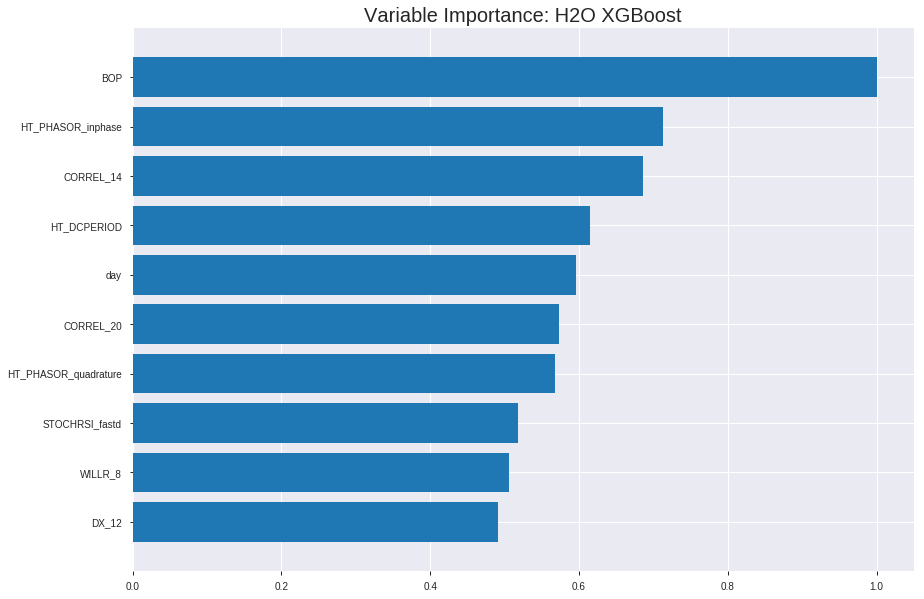

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_173743_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1797756551709558
RMSE: 0.4239995933617812
LogLoss: 0.5490162180993653
Mean Per-Class Error: 0.11462632376821447
AUC: 0.9539027896914669
pr_auc: 0.9501489374983978
Gini: 0.9078055793829338
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46792321900526684: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      783  119  0.1319   (119.0/902.0)
1      80   742  0.0973   (80.0/822.0)
Total  863  861  0.1154   (199.0/1724.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.467923     0.881759  216
max f2                       0.443767     0.915674  242
max f0point5                 0.488867     0.896498  193
max accuracy                 0.481021     0.886311  202
max precision                0.777526     1         0
max recall                   0.335773     1         356
max specificity              0.777526     1         0
max absolute_mcc             0.481021     0.772165  202
max min_per_class_accuracy   0.473226     0.881995  210
max mean_per_class_accuracy  0.467923     0.885374  216

Gains/Lift Table: Avg response rate: 47.68 %, avg score: 47.85 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104408                   0.713247           2.09732    2.09732            1                0.738644  1                           0.738644            0.0218978       0.0218978                  109.732   109.732
    2        0.0203016                   0.699776           2.09732    2.09732            1                0.70646   1                           0.723012            0.0206813       0.0425791                  109.732   109.732
    3        0.0301624                   0.687449           2.09732    2.09732            1                0.693529  1                           0.713373            0.0206813       0.0632603                  109.732   109.732
    4        0.0400232                   0.676942           2.09732    2.09732            1                0.681802  1                           0.705595            0.0206813       0.0839416                  109.732   109.732
    5        0.050464                    0.667621           2.09732    2.09732            1                0.672023  1                           0.698649            0.0218978       0.105839                   109.732   109.732
    6        0.100348                    0.625801           2.09732    2.09732            1                0.648082  1                           0.673512            0.104623        0.210462                   109.732   109.732
    7        0.150232                    0.600571           2.09732    2.09732            1                0.612868  1                           0.653375            0.104623        0.315085                   109.732   109.732
    8        0.200116                    0.575338           2.02416    2.07909            0.965116         0.587454  0.991304                    0.636943            0.100973        0.416058                   102.416   107.909
    9        0.299884                    0.539355           1.91442    2.0243             0.912791         0.556035  0.965184                    0.610026            0.190998        0.607056                   91.4417   102.43
    10       0.400232                    0.49927            1.69726    1.9423             0.809249         0.519575  0.926087                    0.587347            0.170316        0.777372                   69.7256   94.2304
    11       0.5                         0.467285           1.25596    1.80535            0.598837         0.483506  0.860789                    0.566627            0.125304        0.902676                   25.5955   80.5353
    12       0.599768                    0.43535            0.5853     1.6024             0.27907          0.451673  0.764023                    0.547505            0.0583942       0.961071                   -41.47    60.2404
    13       0.700116                    0.408949           0.303081   1.41617            0.144509         0.42201   0.675228                    0.529518            0.0304136       0.991484                   -69.6919  41.6171
    14       0.799884                    0.380681           0.0365812  1.2441             0.0174419        0.396072  0.593183                    0.512874            0.00364964      0.995134                   -96.3419  24.4098
    15       0.899652                    0.344514           0.0365812  1.11019            0.0174419        0.364311  0.529336                    0.496399            0.00364964      0.998783                   -96.3419  11.0189
    16       1                           0.252915           0.0121233  1                  0.00578035       0.317563  0.476798                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2555611715387795
RMSE: 0.5055305841774358
LogLoss: 0.7048672940745491
Mean Per-Class Error: 0.4704393568451002
AUC: 0.5197677496195329
pr_auc: 0.5345258696672472
Gini: 0.03953549923906574
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26559799909591675: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    237  0.9958   (237.0/238.0)
1      0    254  0        (0.0/254.0)
Total  1    491  0.4817   (237.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.265598     0.681879   398
max f2                       0.265598     0.842734   398
max f0point5                 0.343644     0.576564   379
max accuracy                 0.403185     0.538618   320
max precision                0.732666     0.666667   2
max recall                   0.265598     1          398
max specificity              0.764618     0.995798   0
max absolute_mcc             0.319265     0.0819489  392
max min_per_class_accuracy   0.474318     0.504202   206
max mean_per_class_accuracy  0.498928     0.529561   168

Gains/Lift Table: Avg response rate: 51.63 %, avg score: 48.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.711119           1.1622    1.1622             0.6              0.733104  0.6                         0.733104            0.011811        0.011811                   16.2205   16.2205
    2        0.0203252                   0.696068           1.1622    1.1622             0.6              0.702431  0.6                         0.717768            0.011811        0.023622                   16.2205   16.2205
    3        0.0304878                   0.670359           1.1622    1.1622             0.6              0.681489  0.6                         0.705675            0.011811        0.0354331                  16.2205   16.2205
    4        0.0406504                   0.659139           1.1622    1.1622             0.6              0.665027  0.6                         0.695513            0.011811        0.0472441                  16.2205   16.2205
    5        0.050813                    0.652294           0.774803  1.08472            0.4              0.656334  0.56                        0.687677            0.00787402      0.0551181                  -22.5197  8.47244
    6        0.101626                    0.618175           1.00724   1.04598            0.52             0.630393  0.54                        0.659035            0.0511811       0.106299                   0.724409  4.59843
    7        0.150407                    0.590042           1.12992   1.07321            0.583333         0.602721  0.554054                    0.640771            0.0551181       0.161417                   12.9921   7.32071
    8        0.20122                     0.562332           0.929764  1.03698            0.48             0.576625  0.535354                    0.624573            0.0472441       0.208661                   -7.02362  3.6984
    9        0.300813                    0.524057           0.948739  1.00777            0.489796         0.541815  0.52027                     0.597173            0.0944882       0.30315                    -5.12614  0.776761
    10       0.400407                    0.4991             1.22545   1.06191            0.632653         0.510265  0.548223                    0.575556            0.122047        0.425197                   22.5454   6.19129
    11       0.5                         0.474459           0.790615  1.00787            0.408163         0.486003  0.520325                    0.557718            0.0787402       0.503937                   -20.9385  0.787402
    12       0.599593                    0.453213           0.909208  0.991485           0.469388         0.464151  0.511864                    0.542177            0.0905512       0.594488                   -9.07922  -0.851461
    13       0.699187                    0.427881           1.22545   1.02481            0.632653         0.441151  0.52907                     0.527786            0.122047        0.716535                   22.5454   2.48123
    14       0.79878                     0.408951           1.0278    1.02518            0.530612         0.418654  0.529262                    0.51418             0.102362        0.818898                   2.78001   2.51848
    15       0.898374                    0.380477           0.948739  1.01671            0.489796         0.395202  0.524887                    0.50099             0.0944882       0.913386                   -5.12614  1.671
    16       1                           0.232235           0.852283  1                  0.44             0.344676  0.51626                     0.485104        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 17:38:15  19.783 sec  0                  0.5              0.693147            0.5             0                  1                0.523202                         0.5                0.693147              0.5               0                    1                  0.48374
    2019-08-24 17:38:15  20.289 sec  5                  0.490253         0.673805            0.754912        0.739061           1.98081          0.352088                         0.501154           0.695462              0.490497          0.514184             1.93701            0.48374
    2019-08-24 17:38:15  20.455 sec  10                 0.479531         0.652865            0.833924        0.825756           1.98081          0.260441                         0.501513           0.696196              0.49751           0.512437             0.774803           0.48374
    2019-08-24 17:38:15  20.605 sec  15                 0.471674         0.637701            0.863437        0.854968           2.09732          0.234919                         0.502022           0.697242              0.500455          0.520936             0.774803           0.48374
    2019-08-24 17:38:16  20.753 sec  20                 0.465674         0.626186            0.877804        0.872081           2.09732          0.198376                         0.50201            0.697273              0.51397           0.530176             0.774803           0.481707
    2019-08-24 17:38:16  20.913 sec  25                 0.457838         0.61138             0.903925        0.896869           2.09732          0.191995                         0.503561           0.700472              0.504607          0.522162             1.1622             0.48374
    2019-08-24 17:38:16  21.073 sec  30                 0.451039         0.598617            0.91563         0.909476           2.09732          0.165893                         0.503006           0.699412              0.516583          0.535625             1.1622             0.48374
    2019-08-24 17:38:16  21.235 sec  35                 0.443291         0.584275            0.932141        0.926034           2.09732          0.137471                         0.503555           0.700574              0.517832          0.537198             1.1622             0.481707
    2019-08-24 17:38:16  21.397 sec  40                 0.436706         0.572128            0.94096         0.936348           2.09732          0.138051                         0.504264           0.702073              0.518924          0.537839             1.1622             0.469512
    2019-08-24 17:38:16  21.564 sec  45                 0.429842         0.559607            0.948094        0.942454           2.09732          0.114849                         0.505264           0.70417               0.517162          0.531427             0.774803           0.481707
    2019-08-24 17:38:17  21.725 sec  50                 0.424            0.549016            0.953903        0.950149           2.09732          0.115429                         0.505531           0.704867              0.519768          0.534526             1.1622             0.481707

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
BOP                      155.98330688476562     1.0                   0.02210441592948998
HT_PHASOR_inphase        111.2642593383789      0.7133087607930803    0.015767273534719323
CORREL_14                106.98057556152344     0.6858463107244963    0.015160232115960492
HT_DCPERIOD              95.86296844482422      0.614571971574138     0.01358475447828144
day                      93.05770874023438      0.5965876131154327    0.013187220738685178
---                      ---                    ---                   ---
BBANDS_lowerband_14_1_4  3.971641778945923      0.025461966785202322  0.000562821904202971
BBANDS_lowerband_30_5_3  3.2073259353637695     0.020561981916008592  0.0004545106006061053
BBANDS_upperband_24_0_4  3.053950309753418      0.019578699610526638  0.00043277571954962435
TRIX_12                  2.532254219055176      0.01623413600870705   0.000358846094592371
BBANDS_upperband_14_5_2  1.849610447883606      0.011857746093625427  0.00026210855163978153


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5708502024291497)

('F1', 0.6868131868131868)

('auc', 0.5383403361344538)

('logloss', 0.7111113365529472)

('mean_per_class_error', 0.42617515756302526)

('rmse', 0.5084894716231878)

('mse', 0.25856154275162874)

xgboost prediction progress: |████████████████████████████████████████████| 100%


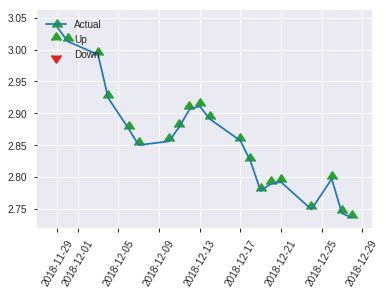


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25856154275162874
RMSE: 0.5084894716231878
LogLoss: 0.7111113365529472
Mean Per-Class Error: 0.42617515756302526
AUC: 0.5383403361344538
pr_auc: 0.5325307218811604
Gini: 0.07668067226890751
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31799474358558655: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    111  0.9328   (111.0/119.0)
1      3    125  0.0234   (3.0/128.0)
Total  11   236  0.4615   (114.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.317995     0.686813  235
max f2                       0.231493     0.843215  246
max f0point5                 0.317995     0.583022  235
max accuracy                 0.442871     0.57085   103
max precision                0.709031     1         0
max recall                   0.231493     1         246
max specificity              0.709031     1         0
max absolute_mcc             0.442871     0.149426  103
max min_per_class_accuracy   0.43055      0.5625    123
max mean_per_class_accuracy  0.442871     0.573825  103

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 44.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.647327           1.28646   1.28646            0.666667         0.676104  0.666667                    0.676104            0.015625        0.015625                   28.6458   28.6458
    2        0.0202429                   0.628208           0         0.771875           0                0.632782  0.4                         0.658775            0               0.015625                   -100      -22.8125
    3        0.0323887                   0.620867           0.643229  0.723633           0.333333         0.624754  0.375                       0.646018            0.0078125       0.0234375                  -35.6771  -27.6367
    4        0.0404858                   0.60906            0.964844  0.771875           0.5              0.615641  0.4                         0.639942            0.0078125       0.03125                    -3.51562  -22.8125
    5        0.0526316                   0.587272           0.643229  0.742188           0.333333         0.598602  0.384615                    0.630402            0.0078125       0.0390625                  -35.6771  -25.7812
    6        0.101215                    0.562977           1.28646   1.00344            0.666667         0.572998  0.52                        0.602848            0.0625          0.101562                   28.6458   0.34375
    7        0.149798                    0.531059           0.804036  0.938767           0.416667         0.550987  0.486486                    0.586028            0.0390625       0.140625                   -19.5964  -6.12331
    8        0.202429                    0.508337           1.33594   1.04203            0.692308         0.518574  0.54                        0.56849             0.0703125       0.210938                   33.5938   4.20312
    9        0.299595                    0.467575           1.28646   1.1213             0.666667         0.485981  0.581081                    0.54173             0.125           0.335938                   28.6458   12.1305
    10       0.40081                     0.447493           1.235     1.15002            0.64             0.456209  0.59596                     0.520134            0.125           0.460938                   23.5      15.0016
    11       0.502024                    0.43055            1.00344   1.12046            0.52             0.437878  0.580645                    0.50355             0.101562        0.5625                     0.34375   12.0464
    12       0.59919                     0.408392           0.562826  1.03004            0.291667         0.419099  0.533784                    0.489855            0.0546875       0.617188                   -43.7174  3.00359
    13       0.700405                    0.396182           0.771875  0.992729           0.4              0.402868  0.514451                    0.477285            0.078125        0.695312                   -22.8125  -0.727059
    14       0.797571                    0.376232           0.964844  0.989332           0.5              0.385376  0.51269                     0.466088            0.09375         0.789062                   -3.51562  -1.06678
    15       0.898785                    0.350794           1.08063   0.999613           0.56             0.362522  0.518018                    0.454425            0.109375        0.898438                   8.0625    -0.0387106
    16       1                           0.231493           1.00344   1                  0.52             0.316823  0.518219                    0.4404

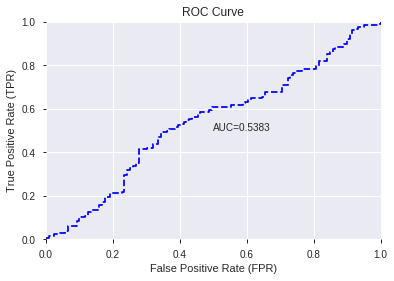

This function is available for GLM models only


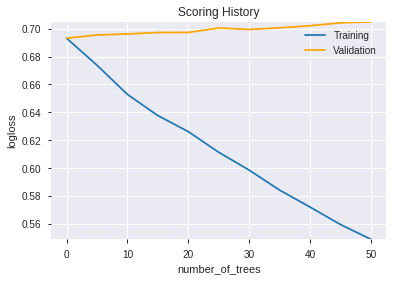

--2019-08-24 17:38:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.102.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.102.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_173743_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_173743_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_8441',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [24]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_173828_model_7  0.548122  0.695386              0.478401  0.499903  0.249903
1  DeepLearning_grid_1_AutoML_20190824_173828_model_3  0.545628  0.729749              0.495798  0.514021  0.264218
2  DeepLearning_grid_1_AutoML_20190824_173828_model_6  0.542082  0.691074              0.486509  0.498948  0.248949
3  DeepLearning_grid_1_AutoML_20190824_173828_model_2  0.536305  0.747507              0.439108  0.520476  0.270895
4  DeepLearning_grid_1_AutoML_20190824_173828_model_9  0.523438  0.692622              0.486804  0.499738  0.249738
5  DeepLearning_grid_1_AutoML_20190824_173828_model_5  0.506795  0.692776              0.491301  0.499783  0.249783
6  DeepLearning_grid_1_AutoML_20190824_173828_model_8  0.500000  0.696411              0.500000  0.501628  0.251630
7  DeepLearning_grid_1_AutoML_20190824_173828_model_1  0.491991  1.081050              0.500000  0.590360  0.348525
8               DeepLearning_1_AutoML_20190824_173828  0.490940  0.889653              0.500000  0.545819  0.297919
9  DeepLearning_grid_1_AutoML_20190824_173828_model_4  0.490809  1.128346              0.495798  0.613575  0.376475

variable  relative_importance  scaled_importance  percentage
0                    weekday             1.000000           1.000000    0.021380
1         CDLEVENINGDOJISTAR             0.995531           0.995531    0.021285
2            CDLSHOOTINGSTAR             0.990106           0.990106    0.021169
3               weekday_name             0.984261           0.984261    0.021044
4             CDL3LINESTRIKE             0.981261           0.981261    0.020979
5                        day             0.976865           0.976865    0.020885
6                    BETA_20             0.972546           0.972546    0.020793
7               aroondown_12             0.971978           0.971978    0.020781
8                  CORREL_14             0.959240           0.959240    0.020509
9              CDLHIKKAKEMOD             0.958583           0.958583    0.020495
10                       TAN             0.956204           0.956204    0.020444
11                  WILLR_24             0.949634           0.949634    0.020303
12                   NATR_30             0.949055           0.949055    0.020291
13  BBANDS_middleband_24_7_5             0.948440           0.948440    0.020278
14                    ADX_24             0.947407           0.947407    0.020256
15   BBANDS_lowerband_14_1_4             0.947154           0.947154    0.020250
16                    ADXR_8             0.946109           0.946109    0.020228
17                 MAVP_24_6             0.944727           0.944727    0.020198
18                   ROCP_14             0.940902           0.940902    0.020117
19                 MAVP_24_3             0.940798           0.940798    0.020114
20               AROONOSC_30             0.940755           0.940755    0.020113
21  BBANDS_middleband_20_1_5             0.939015           0.939015    0.020076
22   BBANDS_middleband_8_3_3             0.937209           0.937209    0.020038
23   BBANDS_lowerband_24_7_4             0.936606           0.936606    0.020025
24                        LN             0.935224           0.935224    0.019995
25                       COS             0.934266           0.934266    0.019975
26                   WILLR_8             0.933827           0.933827    0.019965
27    BBANDS_upperband_8_6_4             0.932056           0.932056    0.019927
28  BBANDS_middleband_24_5_4             0.929612           0.929612    0.019875
29   BBANDS_lowerband_30_2_4             0.926686           0.926686    0.019813
30               MIDPRICE_24             0.924623           0.924623    0.019769
31   BBANDS_lowerband_14_4_3             0.923655           0.923655    0.019748
32   BBANDS_upperband_20_1_4             0.921526           0.921526    0.019702
33  BBANDS_middleband_24_0_2             0.920473           0.920473    0.019680
34                PLUS_DI_20             0.918098           0.918098    0.019629
35                  WILLR_12             0.917843           0.917843    0.019624
36   BBANDS_upperband_24_2_3             0.917162           0.917162    0.019609
37   BBANDS_upperband_12_1_5             0.917003           0.917003    0.019606
38                   MA_30_7             0.915888           0.915888    0.019582
39                 CDLONNECK             0.913710           0.913710    0.019535
40  BBANDS_middleband_30_5_2             0.912405           0.912405    0.019507
41   BBANDS_upperband_24_6_4             0.909867           0.909867    0.019453
42   BBANDS_upperband_30_6_3             0.909542           0.909542    0.019446
43        CDLUPSIDEGAP2CROWS             0.907587           0.907587    0.019404
44   BBANDS_upperband_12_4_4             0.902537           0.902537    0.019296
45   BBANDS_upperband_30_5_3             0.901120           0.901120    0.019266
46                   MA_12_2             0.898412           0.898412    0.019208
47                    ADX_12             0.895136           0.895136    0.019138
48                    MAX_30             0.886166  

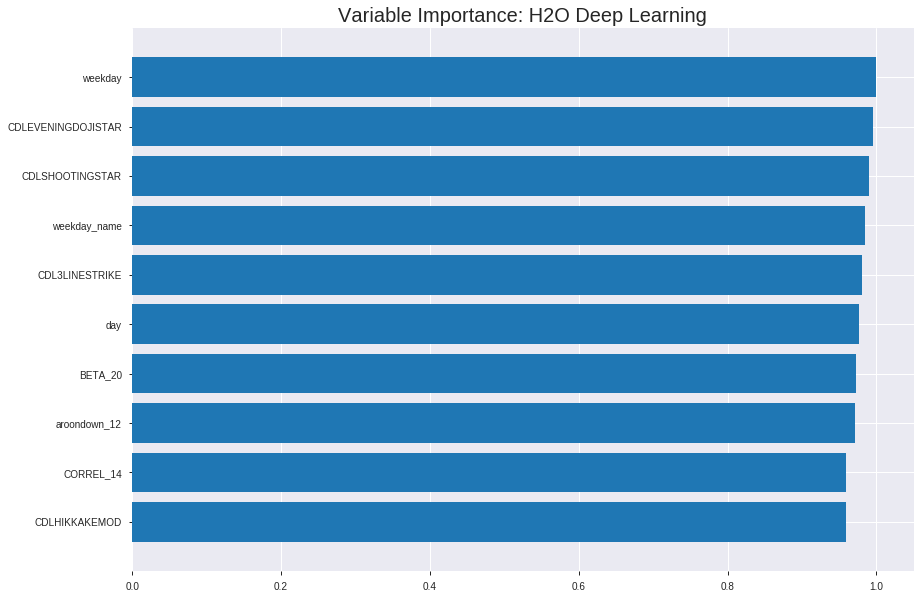

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_173828_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2639078863389169
RMSE: 0.5137196573413527
LogLoss: 0.7251844569251017
Mean Per-Class Error: 0.4570756523756345
AUC: 0.5511528854505532
pr_auc: 0.5481642899685811
Gini: 0.10230577090110637
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12014481341095923: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      9    893   0.99     (893.0/902.0)
1      1    821   0.0012   (1.0/822.0)
Total  10   1714  0.5186   (894.0/1724.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.120145     0.647476  390
max f2                       0.0979685    0.820687  395
max f0point5                 0.454113     0.538904  274
max accuracy                 0.708634     0.556845  93
max precision                0.986129     1         0
max recall                   0.0979685    1         395
max specificity              0.986129     1         0
max absolute_mcc             0.783078     0.120309  57
max min_per_class_accuracy   0.591023     0.532847  176
max mean_per_class_accuracy  0.598119     0.542924  167

Gains/Lift Table: Avg response rate: 47.68 %, avg score: 57.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain        cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ----------  -----------------
    1        0.0104408                   0.910404           1.74777   1.74777            0.833333         0.942527  0.833333                    0.942527            0.0182482       0.0182482                  74.777      74.777
    2        0.0203016                   0.866669           1.72721   1.73778            0.823529         0.891368  0.828571                    0.917678            0.0170316       0.0352798                  72.7208     73.7782
    3        0.0301624                   0.848239           1.48046   1.65366            0.705882         0.857371  0.788462                    0.897963            0.0145985       0.0498783                  48.0464     65.3659
    4        0.0400232                   0.832648           1.23372   1.5502             0.588235         0.839469  0.73913                     0.883551            0.0121655       0.0620438                  23.372      55.0196
    5        0.050464                    0.814795           1.16518   1.47054            0.555556         0.823576  0.701149                    0.871143            0.0121655       0.0742092                  16.518      47.0537
    6        0.100348                    0.740224           1.19499   1.33356            0.569767         0.77471   0.635838                    0.823205            0.0596107       0.13382                    19.4987     33.3558
    7        0.150232                    0.686453           1.12182   1.26325            0.534884         0.710542  0.602317                    0.785795            0.0559611       0.189781                   12.1824     26.3253
    8        0.200116                    0.649917           0.853562  1.16113            0.406977         0.665799  0.553623                    0.755883            0.0425791       0.23236                    -14.6438    16.1127
    9        0.299884                    0.607              1.04866   1.12371            0.5              0.625639  0.535783                    0.712552            0.104623        0.336983                   4.86618     12.3711
    10       0.400232                    0.591788           1.00623   1.09426            0.479769         0.597861  0.521739                    0.683796            0.100973        0.437956                   0.62304     9.42558
    11       0.5                         0.590502           0.999887  1.07543            0.476744         0.591066  0.512761                    0.665293            0.0997567       0.537713                   -0.0113167  7.54258
    12       0.599768                    0.582796           0.743818  1.02026            0.354651         0.587436  0.48646                     0.652342            0.0742092       0.611922                   -25.6182    2.02648
    13       0.700116                    0.555709           1.12746   1.03563            0.537572         0.571667  0.493786                    0.640779            0.113139        0.725061                   12.7463     3.56295
    14       0.799884                    0.498945           0.963306  1.02661            0.459302         0.530599  0.489485                    0.627037            0.0961071       0.821168                   -3.66944    2.66087
    15       0.899652                    0.369576           0.902337  1.01283            0.430233         0.438883  0.482914                    0.606171            0.0900243       0.911192                   -9.76631    1.28275
    16       1                           0.00375079         0.884998  1                  0.421965         0.249972  0.476798    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2855878805192005
RMSE: 0.5344042295109578
LogLoss: 0.8242504331927414
Mean Per-Class Error: 0.48501290279891485
AUC: 0.49067855488652157
pr_auc: 0.49986664667076547
Gini: -0.018642890226956865
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16037939450137037: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    238  1        (238.0/238.0)
1      0    254  0        (0.0/254.0)
Total  0    492  0.4837   (238.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.160379     0.680965   399
max f2                       0.160379     0.842175   399
max f0point5                 0.228057     0.572207   394
max accuracy                 0.228057     0.518293   394
max precision                0.620563     0.534314   189
max recall                   0.160379     1          399
max specificity              1            0.995798   0
max absolute_mcc             0.870533     0.0858542  28
max min_per_class_accuracy   0.605933     0.491597   221
max mean_per_class_accuracy  0.620563     0.514987   189

Gains/Lift Table: Avg response rate: 51.63 %, avg score: 63.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.955349           0.774803  0.774803           0.4              0.980931  0.4                         0.980931            0.00787402      0.00787402                 -22.5197  -22.5197
    2        0.0203252                   0.91546            0.774803  0.774803           0.4              0.931884  0.4                         0.956407            0.00787402      0.015748                   -22.5197  -22.5197
    3        0.0304878                   0.907504           0.387402  0.645669           0.2              0.911981  0.333333                    0.941599            0.00393701      0.019685                   -61.2598  -35.4331
    4        0.0406504                   0.898157           1.1622    0.774803           0.6              0.903185  0.4                         0.931995            0.011811        0.0314961                  16.2205   -22.5197
    5        0.050813                    0.889973           0.774803  0.774803           0.4              0.892651  0.4                         0.924126            0.00787402      0.0393701                  -22.5197  -22.5197
    6        0.101626                    0.803482           1.23969   1.00724            0.64             0.834746  0.52                        0.879436            0.0629921       0.102362                   23.9685   0.724409
    7        0.150407                    0.759346           0.645669  0.889977           0.333333         0.780662  0.459459                    0.847401            0.0314961       0.133858                   -35.4331  -11.0023
    8        0.20122                     0.724476           1.1622    0.958721           0.6              0.740326  0.494949                    0.820362            0.0590551       0.192913                   16.2205   -4.12789
    9        0.300813                    0.657649           1.0278    0.981592           0.530612         0.689898  0.506757                    0.777168            0.102362        0.295276                   2.78001   -1.84082
    10       0.400407                    0.626394           1.14639   1.02258            0.591837         0.641649  0.527919                    0.74346             0.114173        0.409449                   14.6392   2.25828
    11       0.5                         0.605556           0.830146  0.984252           0.428571         0.613495  0.50813                     0.717573            0.0826772       0.492126                   -16.9854  -1.5748
    12       0.599593                    0.596163           1.0278    0.991485           0.530612         0.600596  0.511864                    0.698143            0.102362        0.594488                   2.78001   -0.851461
    13       0.743902                    0.591032           1.03671   1.00026            0.535211         0.592769  0.516393                    0.677701            0.149606        0.744094                   3.67084   0.0258164
    14       0.79878                     0.58656            0.860892  0.990683           0.444444         0.589059  0.51145                     0.671611            0.0472441       0.791339                   -13.9108  -0.931658
    15       0.898374                    0.54806            0.948739  0.986033           0.489796         0.572969  0.50905                     0.660676            0.0944882       0.885827                   -5.12614  -1.39666
    16       1                           0.160379           1.12346   1                  0.58             0.398762  0.51626                     0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 17:43:10  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 17:43:15  5.910 sec         288 obs/sec       0.781903  1             1348       0.546781         0.822511            -0.198459      0.537395        0.499321           1.2817           0.512181                         0.589003           0.992072              -0.389168        0.469124          0.480262             0.387402           0.48374
    2019-08-24 17:43:28  19.138 sec        576 obs/sec       5.59629   7             9648       0.51372          0.725184            -0.0579095     0.551153        0.548164           1.74777          0.518561                         0.534404           0.82425               -0.143561        0.490679          0.499867             0.774803           0.48374
    2019-08-24 17:43:40  31.240 sec        647 obs/sec       10.3834   13            17901      0.641797         1.36218             -0.651168      0.606338        0.591831           1.86429          0.4971                           0.676809           1.57959               -0.834223        0.487775          0.505208             1.1622             0.481707
    2019-08-24 17:43:53  44.777 sec        687 obs/sec       15.9403   20            27481      0.559572         0.873883            -0.255185      0.635194        0.626234           1.98081          0.448956                         0.602759           1.06698               -0.454813        0.477304          0.499535             0.774803           0.479675
    2019-08-24 17:44:07  57.983 sec        712 obs/sec       21.4838   27            37038      0.484476         0.656864            0.0591042      0.687112        0.670917           2.09732          0.412413                         0.548654           0.90883               -0.205362        0.51698           0.525373             0.774803           0.479675
    2019-08-24 17:44:19  1 min 10.716 sec  733 obs/sec       27.022    34            46586      0.535536         0.787454            -0.149673      0.703783        0.694245           2.09732          0.37007                          0.573669           1.02578               -0.317779        0.509098          0.520507             0.774803           0.479675
    2019-08-24 17:44:32  1 min 23.114 sec  752 obs/sec       32.594    41            56192      0.46542          0.619895            0.131669       0.717391        0.69008            2.09732          0.361949                         0.54408            0.960715              -0.185345        0.486659          0.509554             0.774803           0.479675
    2019-08-24 17:44:44  1 min 35.251 sec  768 obs/sec       38.1572   48            65783      0.470707         0.625921            0.111826       0.756629        0.740578           2.09732          0.37123                          0.552958           1.0255                -0.224346        0.514698          0.521112             0.774803           0.471545
    2019-08-24 17:44:56  

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
weekday                  1.0                    1.0                  0.021380112987491522
CDLEVENINGDOJISTAR       0.9955308437347412     0.9955308437347412   0.021284561921581534
CDLSHOOTINGSTAR          0.9901062846183777     0.9901062846183777   0.021168584234766353
weekday_name             0.9842605590820312     0.9842605590820312   0.021043601962305404
CDL3LINESTRIKE           0.9812609553337097     0.9812609553337097   0.020979470095248587
---                      ---                    ---                  ---
BBANDS_upperband_30_5_3  0.9011204838752747     0.9011204838752747   0.019266057760596405
MA_12_2                  0.898411750793457      0.898411750793457    0.019208144741254186
ADX_12                   0.8951361775398254     0.8951361775398254   0.01913811261499274
MAX_30                   0.8861661553382874     0.8861661553382874   0.018946332526823546
LINEARREG_INTERCEPT_30   0.8536272048950195     0.8536272048950195   0.018250646089852093


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.562753036437247)

('F1', 0.6885245901639344)

('auc', 0.5481223739495799)

('logloss', 0.695386425999865)

('mean_per_class_error', 0.4466911764705882)

('rmse', 0.4999029781137821)

('mse', 0.2499029875270285)

deeplearning prediction progress: |███████████████████████████████████████| 100%


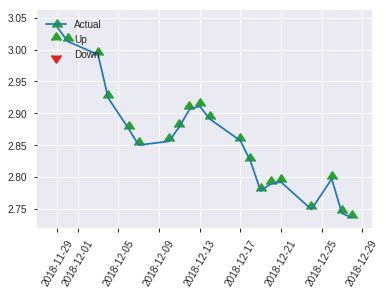


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2499029875270285
RMSE: 0.4999029781137821
LogLoss: 0.695386425999865
Mean Per-Class Error: 0.4466911764705882
AUC: 0.5481223739495799
pr_auc: 0.5525909848139566
Gini: 0.09624474789915971
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22287759614315772: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    112  0.9412   (112.0/119.0)
1      2    126  0.0156   (2.0/128.0)
Total  9    238  0.4615   (114.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.222878     0.688525  210
max f2                       0.165641     0.846561  216
max f0point5                 0.462055     0.590909  160
max accuracy                 0.462055     0.562753  160
max precision                0.96107      1         0
max recall                   0.165641     1         216
max specificity              0.96107      1         0
max absolute_mcc             0.462055     0.12494   160
max min_per_class_accuracy   0.551585     0.546218  96
max mean_per_class_accuracy  0.462055     0.553309  160

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 51.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.886421           1.28646   1.28646            0.666667         0.947181  0.666667                    0.947181            0.015625        0.015625                   28.6458   28.6458
    2        0.0202429                   0.623601           1.92969   1.54375            1                0.735499  0.8                         0.862508            0.015625        0.03125                    92.9688   54.375
    3        0.0323887                   0.607782           0.643229  1.20605            0.333333         0.615524  0.625                       0.769889            0.0078125       0.0390625                  -35.6771  20.6055
    4        0.0404858                   0.59979            0.964844  1.15781            0.5              0.60215   0.6                         0.736341            0.0078125       0.046875                   -3.51562  15.7812
    5        0.0526316                   0.592883           0.643229  1.03906            0.333333         0.595337  0.538462                    0.703802            0.0078125       0.0546875                  -35.6771  3.90625
    6        0.202429                    0.591032           1.04307   1.04203            0.540541         0.591156  0.54                        0.620444            0.15625         0.210938                   4.30743   4.20312
    7        0.202429                    0.591013           0         1.04203            0                0         0.54                        0.620444            0               0.210938                   -100      4.20312
    8        0.299595                    0.587676           1.04525   1.04307            0.541667         0.589397  0.540541                    0.610374            0.101562        0.3125                     4.52474   4.30743
    9        0.40081                     0.571324           1.15781   1.07205            0.6              0.580002  0.555556                    0.602704            0.117188        0.429688                   15.7812   7.20486
    10       0.502024                    0.551585           1.15781   1.08934            0.6              0.562782  0.564516                    0.594656            0.117188        0.546875                   15.7812   8.93397
    11       0.59919                     0.528975           0.723633  1.03004            0.375            0.539699  0.533784                    0.585744            0.0703125       0.617188                   -27.6367  3.00359
    12       0.700405                    0.493735           1.15781   1.0485             0.6              0.51568   0.543353                    0.575619            0.117188        0.734375                   15.7812   4.85007
    13       0.797571                    0.438601           0.964844  1.03831            0.5              0.46615   0.538071                    0.562283            0.09375         0.828125                   -3.51562  3.8309
    14       0.898785                    0.335519           0.92625   1.02569            0.48             0.391765  0.531532                    0.54308             0.09375         0.921875                   -7.375    2.56898
    15       1                           0.139928           0.771875  1                  0.4              0.244574  0.518219                    0.512867            0.078125        1                          -22.8125  0

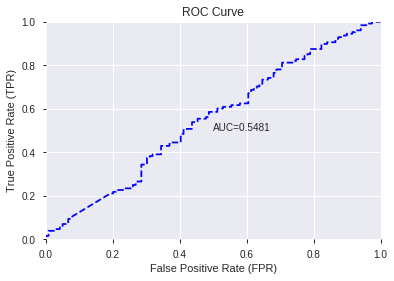

This function is available for GLM models only


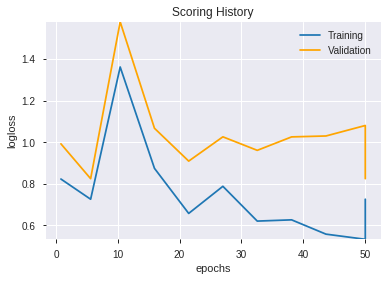

--2019-08-24 17:47:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.17.240
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.17.240|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_173828_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_173828_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_8441',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['weekday',
 'CDLEVENINGDOJISTAR',
 'CDLSHOOTINGSTAR',
 'weekday_name',
 'CDL3LINESTRIKE',
 'day',
 'BETA_20',
 'aroondown_12',
 'CORREL_14',
 'CDLHIKKAKEMOD',
 'TAN',
 'WILLR_24',
 'NATR_30',
 'BBANDS_middleband_24_7_5',
 'ADX_24',
 'BBANDS_lowerband_14_1_4',
 'ADXR_8',
 'MAVP_24_6',
 'ROCP_14',
 'MAVP_24_3',
 'AROONOSC_30',
 'BBANDS_middleband_20_1_5',
 'BBANDS_middleband_8_3_3',
 'BBANDS_lowerband_24_7_4',
 'LN',
 'COS',
 'WILLR_8',
 'BBANDS_upperband_8_6_4',
 'BBANDS_middleband_24_5_4',
 'BBANDS_lowerband_30_2_4',
 'MIDPRICE_24',
 'BBANDS_lowerband_14_4_3',
 'BBANDS_upperband_20_1_4',
 'BBANDS_middleband_24_0_2',
 'PLUS_DI_20',
 'WILLR_12',
 'BBANDS_upperband_24_2_3',
 'BBANDS_upperband_12_1_5',
 'MA_30_7',
 'CDLONNECK',
 'BBANDS_middleband_30_5_2',
 'BBANDS_upperband_24_6_4',
 'BBANDS_upperband_30_6_3',
 'CDLUPSIDEGAP2CROWS',
 'BBANDS_upperband_12_4_4',
 'BBANDS_upperband_30_5_3',
 'MA_12_2',
 'ADX_12',
 'MAX_30',
 'LINEARREG_INTERCEPT_30']

In [25]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190824_174756_model_1  0.516019  0.696258              0.483193  0.50155  0.251552

variable  relative_importance  scaled_importance  percentage
0               aroondown_12             0.007793           1.000000    0.075564
1                        day             0.007565           0.970796    0.073357
2                    WILLR_8             0.006990           0.896988    0.067780
3                   WILLR_12             0.006102           0.783030    0.059169
4                 PLUS_DI_20             0.005719           0.733885    0.055455
5                AROONOSC_30             0.004904           0.629246    0.047549
6                    weekday             0.004654           0.597163    0.045124
7                    ROCP_14             0.004641           0.595591    0.045005
8                   WILLR_24             0.004473           0.573919    0.043368
9         CDLEVENINGDOJISTAR             0.003912           0.501964    0.037931
10                   NATR_30             0.003837           0.492418    0.037209
11                       TAN             0.003754           0.481737    0.036402
12            CDL3LINESTRIKE             0.003748           0.480895    0.036338
13        CDLUPSIDEGAP2CROWS             0.003324           0.426504    0.032228
14                   BETA_20             0.003168           0.406501    0.030717
15             CDLHIKKAKEMOD             0.002684           0.344437    0.026027
16                    ADXR_8             0.002400           0.307989    0.023273
17                        LN             0.001855           0.238022    0.017986
18           CDLSHOOTINGSTAR             0.001628           0.208911    0.015786
19                 MAVP_24_3             0.001510           0.193729    0.014639
20    LINEARREG_INTERCEPT_30             0.001490           0.191179    0.014446
21              weekday_name             0.001404           0.180159    0.013614
22   BBANDS_upperband_12_4_4             0.001299           0.166674    0.012595
23                    ADX_12             0.001274           0.163504    0.012355
24   BBANDS_middleband_8_3_3             0.001244           0.159596    0.012060
25                       COS             0.001160           0.148890    0.011251
26   BBANDS_lowerband_14_4_3             0.001059           0.135923    0.010271
27                 MAVP_24_6             0.001017           0.130544    0.009864
28                 CORREL_14             0.000967           0.124137    0.009380
29   BBANDS_upperband_20_1_4             0.000760           0.097535    0.007370
30                   MA_30_7             0.000746           0.095715    0.007233
31  BBANDS_middleband_24_7_5             0.000730           0.093653    0.007077
32   BBANDS_upperband_12_1_5             0.000683           0.087697    0.006627
33                   MA_12_2             0.000666           0.085406    0.006454
34   BBANDS_upperband_24_2_3             0.000622           0.079853    0.006034
35   BBANDS_upperband_24_6_4             0.000370           0.047542    0.003592
36                    ADX_24             0.000364           0.046748    0.003532
37   BBANDS_lowerband_24_7_4             0.000333           0.042755    0.003231
38                 CDLONNECK             0.000326           0.041784    0.003157
39  BBANDS_middleband_20_1_5             0.000303           0.038937    0.002942
40   BBANDS_lowerband_14_1_4             0.000280           0.035870    0.002711
41   BBANDS_upperband_30_5_3             0.000209           0.026799    0.002025
42    BBANDS_upperband_8_6_4             0.000192           0.024592    0.001858
43               MIDPRICE_24             0.000191           0.024517    0.001853
44   BBANDS_lowerband_30_2_4             0.000185           0.023792    0.001798
45  BBANDS_middleband_24_0_2             0.000183           0.023501    0.001776
46   BBANDS_upperband_30_6_3             0.000135           0.017340    0.001310
47  BBANDS_middleband_24_5_4             0.000102           0.013064    0.000987
48                    MAX_30             0.000090  

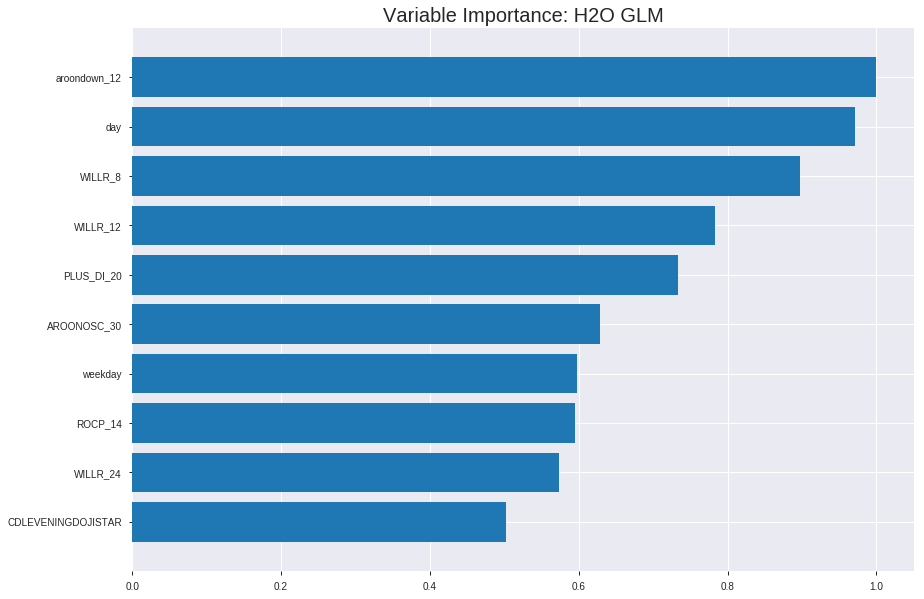

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_174756_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24869107516335684
RMSE: 0.4986893573792776
LogLoss: 0.6905251428039199
Null degrees of freedom: 1723
Residual degrees of freedom: 1673
Null deviance: 2386.25784815377
Residual deviance: 2380.9306923879158
AIC: 2482.9306923879158
AUC: 0.5437915742793792
pr_auc: 0.5272385499970914
Gini: 0.08758314855875837
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4550039350827497: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      10   892   0.9889   (892.0/902.0)
1      2    820   0.0024   (2.0/822.0)
Total  12   1712  0.5186   (894.0/1724.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.455004     0.647198   388
max f2                       0.451347     0.820687   395
max f0point5                 0.465381     0.53524    319
max accuracy                 0.48011      0.546404   162
max precision                0.526654     1          0
max recall                   0.451347     1          395
max specificity              0.526654     1          0
max absolute_mcc             0.491729     0.0895996  55
max min_per_class_accuracy   0.476691     0.522173   197
max mean_per_class_accuracy  0.48011      0.540785   162

Gains/Lift Table: Avg response rate: 47.68 %, avg score: 47.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104408                   0.49792            1.63125   1.63125            0.777778         0.503079  0.777778                    0.503079            0.0170316       0.0170316                  63.1252   63.1252
    2        0.0203016                   0.496248           1.48046   1.55801            0.705882         0.496828  0.742857                    0.500042            0.0145985       0.0316302                  48.0464   55.8012
    3        0.0301624                   0.495184           0.740232  1.29066            0.352941         0.495664  0.615385                    0.498611            0.00729927      0.0389294                  -25.9768  29.0661
    4        0.0400232                   0.494304           1.23372   1.27663            0.588235         0.494741  0.608696                    0.497658            0.0121655       0.0510949                  23.372    27.6632
    5        0.050464                    0.493679           0.815626  1.18125            0.388889         0.494027  0.563218                    0.496906            0.00851582      0.0596107                  -18.4374  18.1251
    6        0.100348                    0.490183           1.31692   1.2487             0.627907         0.491873  0.595376                    0.494404            0.0656934       0.125304                   31.6924   24.8696
    7        0.150232                    0.487695           1.04866   1.18228            0.5              0.488867  0.563707                    0.492565            0.0523114       0.177616                   4.86618   18.2275
    8        0.200116                    0.485289           0.902337  1.11249            0.430233         0.486497  0.530435                    0.491053            0.0450122       0.222628                   -9.76631  11.2493
    9        0.299884                    0.482473           1.07305   1.09937            0.511628         0.483768  0.524178                    0.488629            0.107056        0.329684                   7.30493   9.93708
    10       0.400232                    0.47932            1.11534   1.10337            0.531792         0.480959  0.526087                    0.486706            0.111922        0.441606                   11.534    10.3375
    11       0.5                         0.476607           0.829174  1.04866            0.395349         0.477983  0.5                         0.484965            0.0827251       0.524331                   -17.0826  4.86618
    12       0.599768                    0.473869           1.04866   1.04866            0.5              0.475278  0.5                         0.483354            0.104623        0.628954                   4.86618   4.86618
    13       0.700116                    0.471067           0.921368  1.03042            0.439306         0.472555  0.491301                    0.481806            0.0924574       0.721411                   -7.86324  3.04166
    14       0.799884                    0.468107           0.987693  1.02509            0.47093          0.469622  0.48876                     0.480286            0.0985401       0.819951                   -1.23069  2.50878
    15       0.899652                    0.463794           0.890143  1.01012            0.424419         0.465919  0.481625                    0.478693            0.0888078       0.908759                   -10.9857  1.0123
    16       1                           0.419272           0.909244  1                  0.433526         0.459809  0.476798                    0.476798          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2523561636153108
RMSE: 0.5023506381157595
LogLoss: 0.6981585412527305
Null degrees of freedom: 491
Residual degrees of freedom: 441
Null deviance: 684.603379765711
Residual deviance: 686.9880045926866
AIC: 788.9880045926866
AUC: 0.5045490637199762
pr_auc: 0.5143985672990784
Gini: 0.00909812743995242
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38198705553693113: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    238  1        (238.0/238.0)
1      0    254  0        (0.0/254.0)
Total  0    492  0.4837   (238.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.381987     0.680965   399
max f2                       0.381987     0.842175   399
max f0point5                 0.381987     0.571557   399
max accuracy                 0.483196     0.522358   131
max precision                0.487477     0.578313   74
max recall                   0.381987     1          399
max specificity              0.801358     0.995798   0
max absolute_mcc             0.459341     0.0913646  388
max min_per_class_accuracy   0.477829     0.492126   200
max mean_per_class_accuracy  0.483196     0.528403   131

Gains/Lift Table: Avg response rate: 51.63 %, avg score: 47.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.503624           0.774803  0.774803           0.4              0.57072   0.4                         0.57072             0.00787402      0.00787402                 -22.5197  -22.5197
    2        0.0203252                   0.500904           0.774803  0.774803           0.4              0.50171   0.4                         0.536215            0.00787402      0.015748                   -22.5197  -22.5197
    3        0.0304878                   0.498255           1.1622    0.903937           0.6              0.499711  0.466667                    0.524047            0.011811        0.0275591                  16.2205   -9.6063
    4        0.0406504                   0.497352           0.387402  0.774803           0.2              0.497735  0.4                         0.517469            0.00393701      0.0314961                  -61.2598  -22.5197
    5        0.050813                    0.49591            0.774803  0.774803           0.4              0.4967    0.4                         0.513315            0.00787402      0.0393701                  -22.5197  -22.5197
    6        0.101626                    0.491676           1.23969   1.00724            0.64             0.493963  0.52                        0.503639            0.0629921       0.102362                   23.9685   0.724409
    7        0.150407                    0.488001           1.21063   1.07321            0.625            0.489906  0.554054                    0.499185            0.0590551       0.161417                   21.063    7.32071
    8        0.20122                     0.486217           1.00724   1.05655            0.52             0.48714   0.545455                    0.496143            0.0511811       0.212598                   0.724409  5.65497
    9        0.300813                    0.483785           1.10686   1.07321            0.571429         0.484989  0.554054                    0.49245             0.110236        0.322835                   10.6862   7.32071
    10       0.400407                    0.481025           0.711554  0.983253           0.367347         0.482259  0.507614                    0.489915            0.0708661       0.393701                   -28.8446  -1.67473
    11       0.5                         0.477746           1.0278    0.992126           0.530612         0.479413  0.512195                    0.487823            0.102362        0.496063                   2.78001   -0.787402
    12       0.599593                    0.474797           1.10686   1.01118            0.571429         0.476167  0.522034                    0.485887            0.110236        0.606299                   10.6862   1.11838
    13       0.699187                    0.472298           0.948739  1.00229            0.489796         0.473352  0.517442                    0.484102            0.0944882       0.700787                   -5.12614  0.228896
    14       0.79878                     0.469931           1.06733   1.0104             0.55102          0.471117  0.521628                    0.482483            0.106299        0.807087                   6.73309   1.03985
    15       0.898374                    0.465565           0.790615  0.986033           0.408163         0.468201  0.50905                     0.480899            0.0787402       0.885827                   -20.9385  -1.39666
    16       1                           0.381987           1.12346   1                  0.58             0.457161  0.51626                     0.47848


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 17:47:56  0.000 sec   2            3         51            1.38105           1.39632
    2019-08-24 17:47:56  0.009 sec   4            1.9       51            1.37993           1.40024
    2019-08-24 17:47:56  0.019 sec   6            1.2       51            1.37861           1.40654
    2019-08-24 17:47:56  0.028 sec   8            0.73      51            1.37714           1.4159
    2019-08-24 17:47:56  0.038 sec   10           0.45      51            1.37556           1.4287

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5384615384615384)

('F1', 0.6900269541778976)

('auc', 0.5160189075630253)

('logloss', 0.6962575813340466)

('mean_per_class_error', 0.4618566176470589)

('rmse', 0.5015500254090126)

('mse', 0.2515524279877812)

glm prediction progress: |████████████████████████████████████████████████| 100%


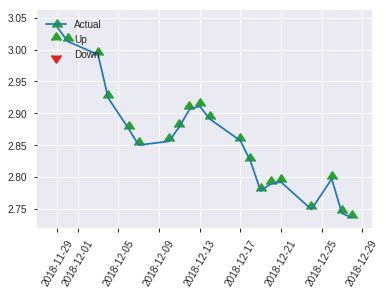


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2515524279877812
RMSE: 0.5015500254090126
LogLoss: 0.6962575813340466
Null degrees of freedom: 246
Residual degrees of freedom: 196
Null deviance: 343.7830139951905
Residual deviance: 343.95124517901894
AIC: 445.95124517901894
AUC: 0.5160189075630253
pr_auc: 0.5352561744013163
Gini: 0.03203781512605053
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4575515715139709: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    115  0.9664   (115.0/119.0)
1      0    128  0        (0.0/128.0)
Total  4    243  0.4656   (115.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.457552     0.690027  242
max f2                       0.457552     0.847682  242
max f0point5                 0.457552     0.581818  242
max accuracy                 0.469838     0.538462  125
max precision                0.532179     1         0
max recall                   0.457552     1         242
max specificity              0.532179     1         0
max absolute_mcc             0.457552     0.133063  242
max min_per_class_accuracy   0.470543     0.53125   122
max mean_per_class_accuracy  0.469838     0.538143  125

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 47.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.495372           1.28646   1.28646            0.666667         0.511766  0.666667                    0.511766            0.015625        0.015625                   28.6458   28.6458
    2        0.0202429                   0.490061           1.92969   1.54375            1                0.490141  0.8                         0.503116            0.015625        0.03125                    92.9688   54.375
    3        0.0323887                   0.488426           0.643229  1.20605            0.333333         0.489586  0.625                       0.498042            0.0078125       0.0390625                  -35.6771  20.6055
    4        0.0404858                   0.487265           0.964844  1.15781            0.5              0.487783  0.6                         0.495991            0.0078125       0.046875                   -3.51562  15.7812
    5        0.0526316                   0.486306           1.28646   1.1875             0.666667         0.486812  0.615385                    0.493872            0.015625        0.0625                     28.6458   18.75
    6        0.101215                    0.483169           0.804036  1.00344            0.416667         0.484683  0.52                        0.489461            0.0390625       0.101562                   -19.5964  0.34375
    7        0.149798                    0.481215           1.12565   1.04307            0.583333         0.482101  0.540541                    0.487074            0.0546875       0.15625                    12.5651   4.30743
    8        0.202429                    0.479291           1.03906   1.04203            0.538462         0.480441  0.54                        0.48535             0.0546875       0.210938                   3.90625   4.20312
    9        0.299595                    0.47602            0.964844  1.017              0.5              0.477857  0.527027                    0.48292             0.09375         0.304688                   -3.51562  1.69975
    10       0.40081                     0.472949           1.00344   1.01357            0.52             0.474764  0.525253                    0.48086             0.101562        0.40625                    0.34375   1.35732
    11       0.502024                    0.470425           1.235     1.05822            0.64             0.471554  0.548387                    0.478984            0.125           0.53125                    23.5      5.82157
    12       0.59919                     0.467589           0.804036  1.017              0.416667         0.468864  0.527027                    0.477343            0.078125        0.609375                   -19.5964  1.69975
    13       0.700405                    0.465136           0.849062  0.992729           0.44             0.466306  0.514451                    0.475748            0.0859375       0.695312                   -15.0938  -0.727059
    14       0.797571                    0.461982           1.04525   0.999128           0.541667         0.463515  0.517766                    0.474258            0.101562        0.796875                   4.52474   -0.0872462
    15       0.898785                    0.459696           1.08063   1.00831            0.56             0.460936  0.522523                    0.472757            0.109375        0.90625                    8.0625    0.830518
    16       1                           0.456              0.92625   1                  0.48             0.458155  0.518219                    0.471279      

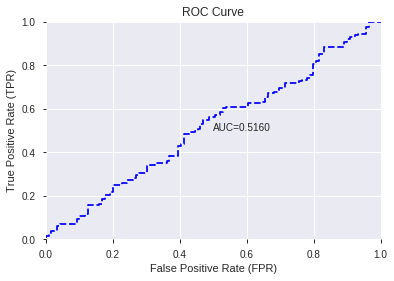

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


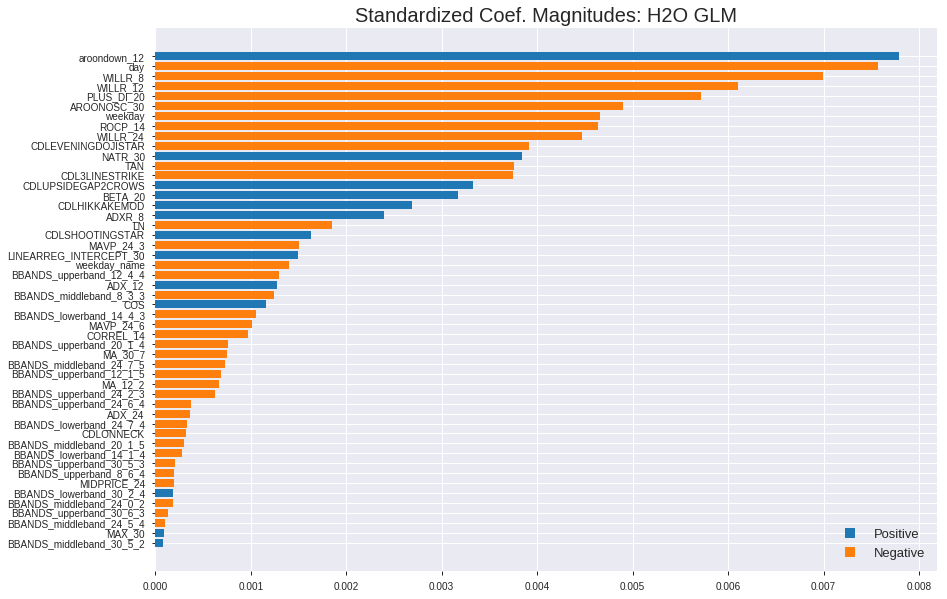

'log_likelihood'
--2019-08-24 17:48:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.169.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.169.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_174756_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_174756_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_8441',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['aroondown_12',
 'day',
 'WILLR_8',
 'WILLR_12',
 'PLUS_DI_20',
 'AROONOSC_30',
 'weekday',
 'ROCP_14',
 'WILLR_24',
 'CDLEVENINGDOJISTAR',
 'NATR_30',
 'TAN',
 'CDL3LINESTRIKE',
 'CDLUPSIDEGAP2CROWS',
 'BETA_20',
 'CDLHIKKAKEMOD',
 'ADXR_8',
 'LN',
 'CDLSHOOTINGSTAR',
 'MAVP_24_3',
 'LINEARREG_INTERCEPT_30',
 'weekday_name',
 'BBANDS_upperband_12_4_4',
 'ADX_12',
 'BBANDS_middleband_8_3_3',
 'COS',
 'BBANDS_lowerband_14_4_3',
 'MAVP_24_6',
 'CORREL_14',
 'BBANDS_upperband_20_1_4',
 'MA_30_7',
 'BBANDS_middleband_24_7_5',
 'BBANDS_upperband_12_1_5',
 'MA_12_2',
 'BBANDS_upperband_24_2_3',
 'BBANDS_upperband_24_6_4',
 'ADX_24',
 'BBANDS_lowerband_24_7_4',
 'CDLONNECK',
 'BBANDS_middleband_20_1_5',
 'BBANDS_lowerband_14_1_4',
 'BBANDS_upperband_30_5_3',
 'BBANDS_upperband_8_6_4',
 'MIDPRICE_24',
 'BBANDS_lowerband_30_2_4',
 'BBANDS_middleband_24_0_2',
 'BBANDS_upperband_30_6_3',
 'BBANDS_middleband_24_5_4',
 'MAX_30',
 'BBANDS_middleband_30_5_2']

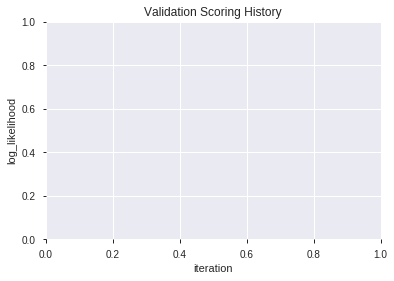

In [26]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_174808_model_3  0.517857  0.703051              0.482898  0.504896  0.254920
1  XGBoost_grid_1_AutoML_20190824_174808_model_5  0.509322  0.747014              0.495798  0.523324  0.273868
2               XGBoost_1_AutoML_20190824_174808  0.508206  0.725949              0.495798  0.515151  0.265380
3  XGBoost_grid_1_AutoML_20190824_174808_model_6  0.505383  0.703974              0.495798  0.505231  0.255258
4  XGBoost_grid_1_AutoML_20190824_174808_model_7  0.504530  0.732827              0.478105  0.518516  0.268859
5  XGBoost_grid_1_AutoML_20190824_174808_model_2  0.504235  0.703611              0.478401  0.505118  0.255144
6  XGBoost_grid_1_AutoML_20190824_174808_model_1  0.498621  0.703275              0.487395  0.504958  0.254982
7               XGBoost_2_AutoML_20190824_174808  0.491991  0.715226              0.495798  0.510598  0.260711
8  XGBoost_grid_1_AutoML_20190824_174808_model_4  0.486738  0.711145              0.500000  0.508732  0.258808
9               XGBoost_3_AutoML_20190824_174808  0.485688  0.714564              0.465205  0.510448  0.260557

variable  relative_importance  scaled_importance  percentage
0                    ROCP_14           285.982056           1.000000    0.073185
1                    BETA_20           221.017990           0.772839    0.056560
2                AROONOSC_30           211.331985           0.738969    0.054082
3                        day           206.269257           0.721266    0.052786
4                  CORREL_14           200.715637           0.701847    0.051365
5                    NATR_30           165.213943           0.577707    0.042280
6                 PLUS_DI_20           159.808914           0.558807    0.040897
7                    WILLR_8           154.884735           0.541589    0.039636
8                     ADX_12           154.424362           0.539979    0.039519
9                   WILLR_12           149.301498           0.522066    0.038208
10                       COS           117.245827           0.409976    0.030004
11                    ADX_24           111.238701           0.388971    0.028467
12   BBANDS_upperband_30_6_3           110.065002           0.384867    0.028167
13   BBANDS_upperband_12_1_5           109.505493           0.382910    0.028023
14                    ADXR_8           106.054832           0.370844    0.027140
15              aroondown_12            92.978745           0.325121    0.023794
16                  WILLR_24            92.174583           0.322309    0.023588
17   BBANDS_lowerband_24_7_4            90.664810           0.317030    0.023202
18   BBANDS_upperband_12_4_4            85.491432           0.298940    0.021878
19                       TAN            72.074799           0.252026    0.018445
20                   weekday            68.899628           0.240923    0.017632
21    BBANDS_upperband_8_6_4            68.338486           0.238961    0.017488
22    LINEARREG_INTERCEPT_30            68.132790           0.238241    0.017436
23                 MAVP_24_6            66.176292           0.231400    0.016935
24   BBANDS_upperband_20_1_4            66.019089           0.230850    0.016895
25                 MAVP_24_3            60.318592           0.210917    0.015436
26   BBANDS_middleband_8_3_3            55.329758           0.193473    0.014159
27              weekday_name            53.969898           0.188718    0.013811
28  BBANDS_middleband_20_1_5            53.169754           0.185920    0.013607
29   BBANDS_upperband_24_6_4            42.583389           0.148902    0.010897
30  BBANDS_middleband_30_5_2            42.059532           0.147071    0.010763
31   BBANDS_lowerband_14_1_4            40.198952           0.140565    0.010287
32   BBANDS_lowerband_30_2_4            39.932648           0.139633    0.010219
33   BBANDS_upperband_24_2_3            38.592091           0.134946    0.009876
34  BBANDS_middleband_24_0_2            37.034950           0.129501    0.009478
35  BBANDS_middleband_24_5_4            36.268105           0.126820    0.009281
36                   MA_12_2            34.435043           0.120410    0.008812
37   BBANDS_lowerband_14_4_3            33.301155           0.116445    0.008522
38  BBANDS_middleband_24_7_5            33.041553           0.115537    0.008456
39   BBANDS_upperband_30_5_3            31.575594           0.110411    0.008080
40                        LN            21.837742           0.076361    0.005588
41                    MAX_30            15.093010           0.052776    0.003862
42               MIDPRICE_24             4.888566           0.017094    0.001251

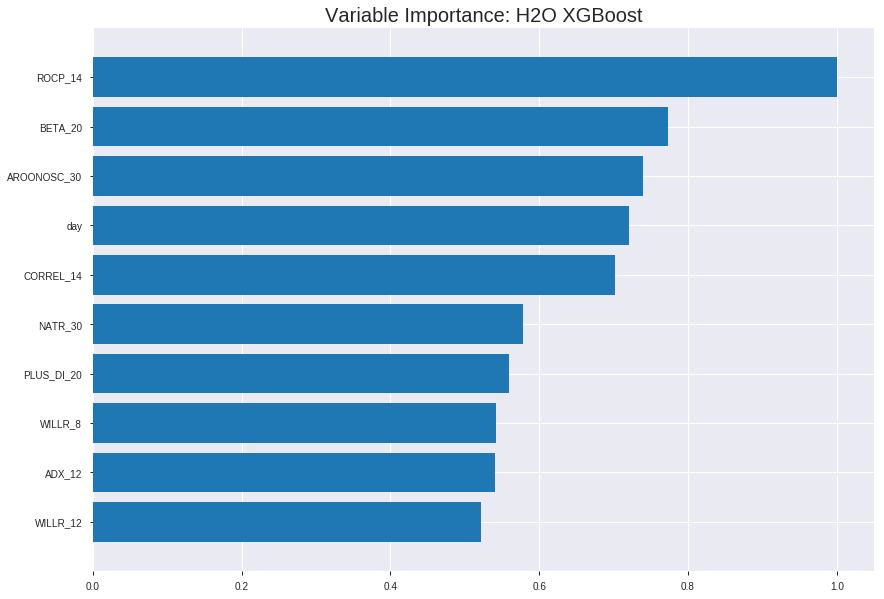

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_174808_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.201655889369851
RMSE: 0.4490611198599262
LogLoss: 0.5943864931661784
Mean Per-Class Error: 0.1980635085050253
AUC: 0.8821617006813731
pr_auc: 0.8718100273865271
Gini: 0.7643234013627462
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4640363082289696: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      678  224  0.2483   (224.0/902.0)
1      127  695  0.1545   (127.0/822.0)
Total  805  919  0.2036   (351.0/1724.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.464036     0.798392  224
max f2                       0.429826     0.872768  266
max f0point5                 0.495329     0.801834  185
max accuracy                 0.476076     0.801044  208
max precision                0.785382     1         0
max recall                   0.374692     1         333
max specificity              0.785382     1         0
max absolute_mcc             0.47013      0.603255  216
max min_per_class_accuracy   0.474301     0.800443  210
max mean_per_class_accuracy  0.47013      0.801936  216

Gains/Lift Table: Avg response rate: 47.68 %, avg score: 47.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104408                   0.690718           2.09732   2.09732            1                0.718055  1                           0.718055            0.0218978       0.0218978                  109.732   109.732
    2        0.0203016                   0.668023           2.09732   2.09732            1                0.677087  1                           0.698156            0.0206813       0.0425791                  109.732   109.732
    3        0.0301624                   0.65624            2.09732   2.09732            1                0.661633  1                           0.686216            0.0206813       0.0632603                  109.732   109.732
    4        0.0400232                   0.641552           2.09732   2.09732            1                0.648957  1                           0.677036            0.0206813       0.0839416                  109.732   109.732
    5        0.050464                    0.629691           1.98081   2.07322            0.944444         0.635473  0.988506                    0.668437            0.0206813       0.104623                   98.0806   107.322
    6        0.100348                    0.595268           1.97539   2.02458            0.94186          0.611706  0.965318                    0.640235            0.0985401       0.203163                   97.5386   102.458
    7        0.150232                    0.571115           1.97539   2.00825            0.94186          0.582197  0.957529                    0.620964            0.0985401       0.301703                   97.5386   100.825
    8        0.200116                    0.553668           1.82906   1.96358            0.872093         0.562393  0.936232                    0.606364            0.0912409       0.392944                   82.9061   96.3581
    9        0.299884                    0.52199            1.62177   1.84986            0.773256         0.538638  0.882012                    0.583832            0.1618          0.554745                   62.1768   84.9864
    10       0.400232                    0.495509           1.43054   1.74473            0.682081         0.508532  0.831884                    0.564952            0.143552        0.698297                   43.0544   74.473
    11       0.5                         0.470911           1.15841   1.62774            0.552326         0.483251  0.776102                    0.54865             0.115572        0.813869                   15.8405   62.7737
    12       0.599768                    0.449697           0.780399  1.48679            0.372093         0.459876  0.708897                    0.533883            0.0778589       0.891727                   -21.9601  48.6787
    13       0.700116                    0.427451           0.606163  1.36057            0.289017         0.438956  0.648716                    0.520277            0.0608273       0.952555                   -39.3837  36.0567
    14       0.799884                    0.404398           0.280456  1.22585            0.133721         0.416515  0.584482                    0.507335            0.0279805       0.980535                   -71.9544  22.5847
    15       0.899652                    0.372911           0.1951    1.11154            0.0930233        0.390406  0.529981                    0.494368            0.0194647       1                          -80.49    11.1541
    16       1                           0.240148           0         1                  0                0.341549  0.476798                    0.479033          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25498805407165187
RMSE: 0.5049634185479696
LogLoss: 0.7038609261818997
Mean Per-Class Error: 0.46248263084761465
AUC: 0.5256732614305565
pr_auc: 0.5429618380268534
Gini: 0.051346522861112964
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2548868954181671: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    236  0.9916   (236.0/238.0)
1      1    253  0.0039   (1.0/254.0)
Total  3    489  0.4817   (237.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.254887     0.681023   396
max f2                       0.216834     0.842175   399
max f0point5                 0.416092     0.574053   299
max accuracy                 0.458147     0.54065    236
max precision                0.761503     1          0
max recall                   0.216834     1          399
max specificity              0.761503     1          0
max absolute_mcc             0.692423     0.0980826  4
max min_per_class_accuracy   0.476625     0.521008   202
max mean_per_class_accuracy  0.458147     0.537517   236

Gains/Lift Table: Avg response rate: 51.63 %, avg score: 47.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.681095           1.93701   1.93701            1                0.728366  1                           0.728366            0.019685        0.019685                   93.7008   93.7008
    2        0.0203252                   0.656267           0.774803  1.35591            0.4              0.670838  0.7                         0.699602            0.00787402      0.0275591                  -22.5197  35.5906
    3        0.0304878                   0.635322           0.774803  1.1622             0.4              0.647293  0.6                         0.682165            0.00787402      0.0354331                  -22.5197  16.2205
    4        0.0406504                   0.620058           0.387402  0.968504           0.2              0.629387  0.5                         0.668971            0.00393701      0.0393701                  -61.2598  -3.14961
    5        0.050813                    0.607942           1.54961   1.08472            0.8              0.612048  0.56                        0.657586            0.015748        0.0551181                  54.9606   8.47244
    6        0.101626                    0.580527           1.08472   1.08472            0.56             0.593751  0.56                        0.625669            0.0551181       0.110236                   8.47244   8.47244
    7        0.150407                    0.565167           1.04921   1.07321            0.541667         0.572551  0.554054                    0.608442            0.0511811       0.161417                   4.92126   7.32071
    8        0.20122                     0.550392           1.1622    1.09568            0.6              0.558179  0.565657                    0.595749            0.0590551       0.220472                   16.2205   9.56812
    9        0.300813                    0.523095           0.869677  1.02086            0.44898          0.535952  0.527027                    0.575951            0.0866142       0.307087                   -13.0323  2.08555
    10       0.400407                    0.497634           0.988269  1.01275            0.510204         0.508606  0.522843                    0.559201            0.0984252       0.405512                   -1.17307  1.27503
    11       0.5                         0.477204           1.14639   1.03937            0.591837         0.486754  0.536585                    0.54477             0.114173        0.519685                   14.6392   3.93701
    12       0.599593                    0.456867           1.14639   1.05715            0.591837         0.465247  0.545763                    0.531561            0.114173        0.633858                   14.6392   5.71467
    13       0.699187                    0.428868           0.909208  1.03607            0.469388         0.44261   0.534884                    0.518891            0.0905512       0.724409                   -9.07922  3.6074
    14       0.79878                     0.403483           0.790615  1.00547            0.408163         0.417694  0.519084                    0.506274            0.0787402       0.80315                    -20.9385  0.546974
    15       0.898374                    0.367143           0.988269  1.00356            0.510204         0.388267  0.5181                      0.493191            0.0984252       0.901575                   -1.17307  0.35629
    16       1                           0.216834           0.968504  1                  0.5              0.333887  0.51626                     0.477002        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 17:48:12  1.078 sec   0                  0.5              0.693147            0.5             0                  1                0.523202                         0.5                0.693147              0.5               0                    1                  0.48374
    2019-08-24 17:48:12  1.128 sec   5                  0.494326         0.681845            0.681584        0.659631           1.86429          0.435615                         0.500238           0.693627              0.506592          0.542568             1.54961            0.48374
    2019-08-24 17:48:12  1.172 sec   10                 0.487779         0.668906            0.737943        0.725214           1.86429          0.37007                          0.500323           0.693803              0.516757          0.560567             1.93701            0.481707
    2019-08-24 17:48:12  1.221 sec   15                 0.481917         0.657429            0.779496        0.771372           2.09732          0.343387                         0.500944           0.695069              0.518552          0.557211             1.93701            0.481707
    2019-08-24 17:48:12  1.264 sec   20                 0.477057         0.647934            0.793035        0.786876           2.09732          0.303944                         0.501794           0.696796              0.518403          0.545555             1.93701            0.48374
    2019-08-24 17:48:12  1.306 sec   25                 0.4733           0.640626            0.800704        0.795054           2.09732          0.281323                         0.50193            0.697084              0.522075          0.545859             1.93701            0.48374
    2019-08-24 17:48:12  1.356 sec   30                 0.467275         0.629021            0.830999        0.823684           2.09732          0.269722                         0.502109           0.697476              0.524424          0.542431             1.93701            0.479675
    2019-08-24 17:48:12  1.404 sec   35                 0.462529         0.619913            0.846675        0.838225           2.09732          0.25348                          0.503664           0.70077               0.519759          0.539173             1.93701            0.48374
    2019-08-24 17:48:13  1.458 sec   40                 0.458405         0.612025            0.858715        0.848615           2.09732          0.24478                          0.504358           0.702263              0.520314          0.537714             1.54961            0.48374
    2019-08-24 17:48:13  1.515 sec   45                 0.453048         0.60188             0.872848        0.861937           2.09732          0.203016                         0.505461           0.704799              0.520537          0.538465             1.54961            0.48374
    2019-08-24 17:48:13  1.570 sec   50                 0.449061         0.594386            0.882162        0.87181            2.09732          0.203596                         0.504963           0.703861              0.525673          0.542962             1.93701            0.481707

Variable Importances: 


variable                  relative_importance    scaled_importance     percentage
------------------------  ---------------------  --------------------  ---------------------
ROCP_14                   285.9820556640625      1.0                   0.0731853411370934
BETA_20                   221.0179901123047      0.7728386649962757    0.05656046134168828
AROONOSC_30               211.3319854736328      0.738969390869336     0.054081726960642465
day                       206.26925659179688     0.7212664309053618    0.05278612979654271
CORREL_14                 200.71563720703125     0.7018469628836013    0.051364909404669284
---                       ---                    ---                   ---
BBANDS_middleband_24_7_5  33.04155349731445      0.11553715641560293   0.00845562620628562
BBANDS_upperband_30_5_3   31.575593948364258     0.11041110210584501   0.008080474172938718
LN                        21.83774185180664      0.07636053178615866   0.005588471568179885
MAX_30                    15.093009948730469     0.05277607335776316   0.0038624349325641627
MIDPRICE_24               4.888566017150879      0.017093960688545372  0.001251027344375257


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5506072874493927)

('F1', 0.6883468834688348)

('auc', 0.5178571428571429)

('logloss', 0.7030509715044685)

('mean_per_class_error', 0.4542738970588236)

('rmse', 0.5048956569853494)

('mse', 0.25491962444266764)

xgboost prediction progress: |████████████████████████████████████████████| 100%


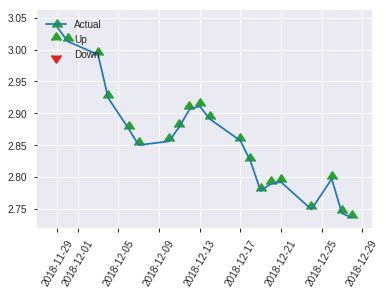


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25491962444266764
RMSE: 0.5048956569853494
LogLoss: 0.7030509715044685
Mean Per-Class Error: 0.4542738970588236
AUC: 0.5178571428571429
pr_auc: 0.5212313505787542
Gini: 0.03571428571428581
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3469291627407074: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    114  0.958    (114.0/119.0)
1      1    127  0.0078   (1.0/128.0)
Total  6    241  0.4656   (115.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.346929     0.688347  240
max f2                       0.312668     0.845443  244
max f0point5                 0.371488     0.584906  232
max accuracy                 0.429221     0.550607  156
max precision                0.66911      1         0
max recall                   0.312668     1         244
max specificity              0.66911      1         0
max absolute_mcc             0.371488     0.114061  232
max min_per_class_accuracy   0.446214     0.487395  123
max mean_per_class_accuracy  0.429221     0.545726  156

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 45.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.586963           1.28646   1.28646            0.666667         0.626872  0.666667                    0.626872            0.015625        0.015625                   28.6458   28.6458
    2        0.0202429                   0.581271           0.964844  1.15781            0.5              0.583385  0.6                         0.609477            0.0078125       0.0234375                  -3.51562  15.7812
    3        0.0323887                   0.573398           0.643229  0.964844           0.333333         0.576735  0.5                         0.597199            0.0078125       0.03125                    -35.6771  -3.51562
    4        0.0404858                   0.567688           0         0.771875           0                0.570912  0.4                         0.591942            0               0.03125                    -100      -22.8125
    5        0.0526316                   0.558135           1.92969   1.03906            1                0.563984  0.538462                    0.58549             0.0234375       0.0546875                  92.9688   3.90625
    6        0.101215                    0.532191           0.964844  1.00344            0.5              0.544961  0.52                        0.566036            0.046875        0.101562                   -3.51562  0.34375
    7        0.149798                    0.511178           0.643229  0.886613           0.333333         0.521492  0.459459                    0.551589            0.03125         0.132812                   -35.6771  -11.3387
    8        0.202429                    0.498442           1.48438   1.04203            0.769231         0.505563  0.54                        0.539623            0.078125        0.210938                   48.4375   4.20312
    9        0.299595                    0.474487           1.04525   1.04307            0.541667         0.49016   0.540541                    0.523581            0.101562        0.3125                     4.52474   4.30743
    10       0.40081                     0.46142            0.771875  0.97459            0.4              0.467888  0.505051                    0.509517            0.078125        0.390625                   -22.8125  -2.54104
    11       0.502024                    0.446214           1.00344   0.980406           0.52             0.45281   0.508065                    0.498084            0.101562        0.492188                   0.34375   -1.95943
    12       0.59919                     0.433662           1.44727   1.05611            0.75             0.440434  0.547297                    0.488735            0.140625        0.632812                   44.7266   5.61128
    13       0.700405                    0.422997           1.00344   1.0485             0.52             0.428141  0.543353                    0.479979            0.101562        0.734375                   0.34375   4.85007
    14       0.797571                    0.407277           0.88444   1.02851            0.458333         0.414676  0.532995                    0.472023            0.0859375       0.820312                   -11.556   2.85136
    15       0.898785                    0.384728           0.849062  1.00831            0.44             0.397327  0.522523                    0.463611            0.0859375       0.90625                    -15.0938  0.830518
    16       1                           0.294793           0.92625   1                  0.48             0.357696  0.518219                    0.452891   

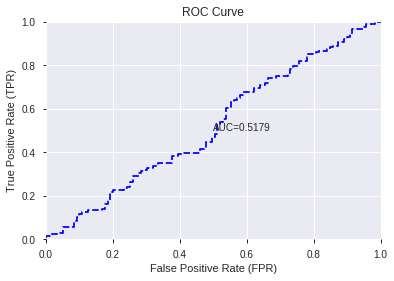

This function is available for GLM models only


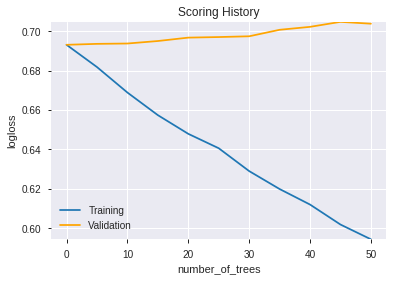

--2019-08-24 17:48:21--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.166.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.166.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_174808_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_174808_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_8441',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['ROCP_14',
 'BETA_20',
 'AROONOSC_30',
 'day',
 'CORREL_14',
 'NATR_30',
 'PLUS_DI_20',
 'WILLR_8',
 'ADX_12',
 'WILLR_12',
 'COS',
 'ADX_24',
 'BBANDS_upperband_30_6_3',
 'BBANDS_upperband_12_1_5',
 'ADXR_8',
 'aroondown_12',
 'WILLR_24',
 'BBANDS_lowerband_24_7_4',
 'BBANDS_upperband_12_4_4',
 'TAN',
 'weekday',
 'BBANDS_upperband_8_6_4',
 'LINEARREG_INTERCEPT_30',
 'MAVP_24_6',
 'BBANDS_upperband_20_1_4',
 'MAVP_24_3',
 'BBANDS_middleband_8_3_3',
 'weekday_name',
 'BBANDS_middleband_20_1_5',
 'BBANDS_upperband_24_6_4',
 'BBANDS_middleband_30_5_2',
 'BBANDS_lowerband_14_1_4',
 'BBANDS_lowerband_30_2_4',
 'BBANDS_upperband_24_2_3',
 'BBANDS_middleband_24_0_2',
 'BBANDS_middleband_24_5_4',
 'MA_12_2',
 'BBANDS_lowerband_14_4_3',
 'BBANDS_middleband_24_7_5',
 'BBANDS_upperband_30_5_3',
 'LN',
 'MAX_30',
 'MIDPRICE_24']

In [27]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [29]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [30]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [31]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [33]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [34]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [35]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [37]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [38]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [39]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [41]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [42]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [43]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [45]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [46]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [47]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [49]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [50]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [51]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [52]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [882 923] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_174827_model_5  0.585938  0.710331              0.470588  0.508327  0.258396
1  DeepLearning_grid_1_AutoML_20190824_174827_model_3  0.578585  0.817427              0.500000  0.547849  0.300138
2  DeepLearning_grid_1_AutoML_20190824_174827_model_2  0.542542  0.705929              0.487100  0.506097  0.256134
3  DeepLearning_grid_1_AutoML_20190824_174827_model_4  0.534139  1.072370              0.500000  0.570198  0.325126
4  DeepLearning_grid_1_AutoML_20190824_174827_model_9  0.514213  0.692485              0.495798  0.499669  0.249669
5  DeepLearning_grid_1_AutoML_20190824_174827_model_1  0.509848  3.526896              0.500000  0.692191  0.479129
6  DeepLearning_grid_1_AutoML_20190824_174827_model_8  0.500000  0.693169              0.500000  0.500011  0.250011
7  DeepLearning_grid_1_AutoML_20190824_174827_model_7  0.496389  0.767020              0.495798  0.526687  0.277400
8               DeepLearning_1_AutoML_20190824_174827  0.487920  0.731959              0.500000  0.513160  0.263334
9  DeepLearning_grid_1_AutoML_20190824_174827_model_6  0.479057  0.695526              0.500000  0.501187  0.251188

variable  relative_importance  scaled_importance  percentage
0                       SAREXT             1.000000           1.000000    0.001213
1               CDLSPINNINGTOP             0.992922           0.992922    0.001204
2                days_in_month             0.979318           0.979318    0.001188
3                  aroondown_8             0.972566           0.972566    0.001179
4                      weekday             0.968243           0.968243    0.001174
...                        ...                  ...                ...         ...
1025  BBANDS_middleband_12_4_3             0.719225           0.719225    0.000872
1026                 MAVP_20_5             0.717736           0.717736    0.000870
1027                    WMA_14             0.717724           0.717724    0.000870
1028                   MA_12_3             0.711257           0.711257    0.000863
1029          CDLCOUNTERATTACK             0.680604           0.680604    0.000825

[1030 rows x 4 columns]

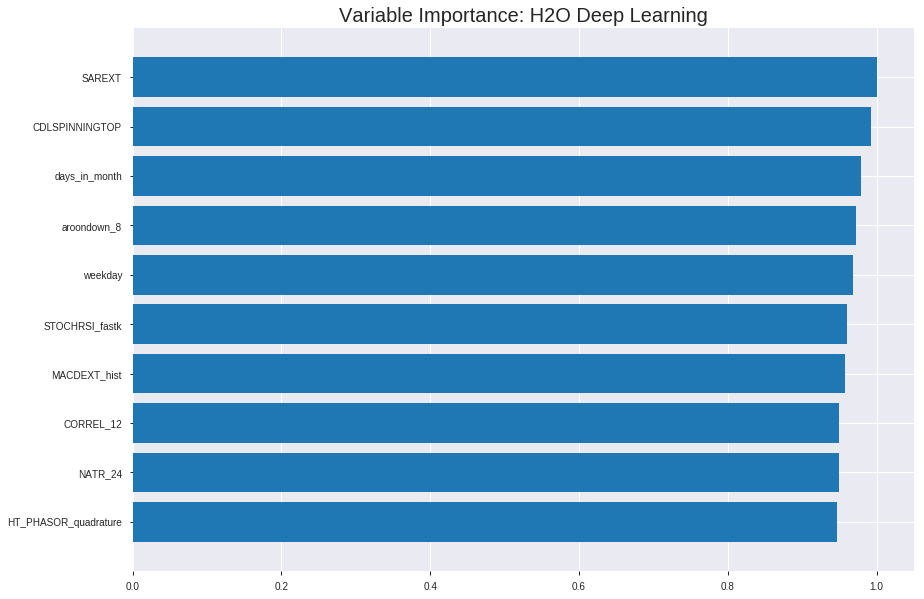

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_174827_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2544076708545341
RMSE: 0.5043884126886086
LogLoss: 0.7033062318802896
Mean Per-Class Error: 0.4805163977319933
AUC: 0.5170140968164825
pr_auc: 0.5127899674737783
Gini: 0.03402819363296494
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24865428022744102: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      10   892   0.9889   (892.0/902.0)
1      3    819   0.0036   (3.0/822.0)
Total  13   1711  0.5191   (895.0/1724.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.248654     0.646664   390
max f2                       0.106411     0.820196   398
max f0point5                 0.255108     0.534451   386
max accuracy                 0.519356     0.535963   53
max precision                0.835244     1          0
max recall                   0.106411     1          398
max specificity              0.835244     1          0
max absolute_mcc             0.519356     0.0758457  53
max min_per_class_accuracy   0.477246     0.47561    91
max mean_per_class_accuracy  0.454707     0.519484   125

Gains/Lift Table: Avg response rate: 47.68 %, avg score: 43.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain        cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ----------  -----------------
    1        0.0104408                   0.629048           1.63125   1.63125            0.777778         0.688045  0.777778                    0.688045            0.0170316       0.0170316                  63.1252     63.1252
    2        0.0203016                   0.55854            1.23372   1.43816            0.588235         0.588825  0.685714                    0.639853            0.0121655       0.0291971                  23.372      43.8165
    3        0.0301624                   0.536388           1.11035   1.33099            0.529412         0.545088  0.634615                    0.608872            0.0109489       0.040146                   11.0348     33.0994
    4        0.0400232                   0.515301           1.35709   1.33742            0.647059         0.526828  0.637681                    0.588658            0.013382        0.053528                   35.7092     33.7424
    5        0.050464                    0.498773           0.466072  1.15714            0.222222         0.50603   0.551724                    0.571563            0.00486618      0.0583942                  -53.3928    15.7144
    6        0.528422                    0.477246           0.995211  1.01068            0.474515         0.477742  0.481888                    0.486701            0.475669        0.534063                   -0.478941   1.06751
    7        0.599768                    0.451196           1.21065   1.03446            0.577236         0.465446  0.49323                     0.484173            0.0863747       0.620438                   21.065      3.44633
    8        0.700116                    0.408112           0.824382  1.00435            0.393064         0.430656  0.478873                    0.476502            0.0827251       0.703163                   -17.5618    0.435215
    9        0.799884                    0.348741           0.999887  1.0038             0.476744         0.382918  0.478608                    0.46483             0.0997567       0.80292                    -0.0113167  0.37952
    10       0.899652                    0.303669           1.09744   1.01418            0.523256         0.323047  0.483559                    0.449107            0.109489        0.912409                   9.74368     1.41797
    11       1                           0.095813           0.872875  1                  0.416185         0.273813  0.476798                    0.431516            0.0875912       1                          -12.7125    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2513627932144211
RMSE: 0.501360941053869
LogLoss: 0.6959059831541593
Mean Per-Class Error: 0.48990934956659826
AUC: 0.502332429034606
pr_auc: 0.5144474634331748
Gini: 0.004664858069211908
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4516353700897045: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    236  0.9916   (236.0/238.0)
1      0    254  0        (0.0/254.0)
Total  2    490  0.4797   (236.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.451635     0.682796   83
max f2                       0.451635     0.843293   83
max f0point5                 0.451635     0.573622   83
max accuracy                 0.477208     0.522358   70
max precision                0.640247     0.666667   2
max recall                   0.451635     1          83
max specificity              0.66599      0.995798   0
max absolute_mcc             0.451635     0.0660002  83
max min_per_class_accuracy   0.47815      0.137795   67
max mean_per_class_accuracy  0.524829     0.510091   31

Gains/Lift Table: Avg response rate: 51.63 %, avg score: 48.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.631857           0.774803  0.774803           0.4              0.64379   0.4                         0.64379             0.00787402      0.00787402                 -22.5197  -22.5197
    2        0.0203252                   0.620238           1.1622    0.968504           0.6              0.626718  0.5                         0.635254            0.011811        0.019685                   16.2205   -3.14961
    3        0.0304878                   0.607888           1.54961   1.1622             0.8              0.615279  0.6                         0.628596            0.015748        0.0354331                  54.9606   16.2205
    4        0.0406504                   0.592041           0.774803  1.06535            0.4              0.604074  0.55                        0.622465            0.00787402      0.0433071                  -22.5197  6.53543
    5        0.050813                    0.579428           0.774803  1.00724            0.4              0.586373  0.52                        0.615247            0.00787402      0.0511811                  -22.5197  0.724409
    6        0.101626                    0.499195           0.929764  0.968504           0.48             0.522618  0.5                         0.568932            0.0472441       0.0984252                  -7.02362  -3.14961
    7        0.96748                     0.477246           1.00943   1.00513            0.521127         0.477691  0.518908                    0.487275            0.874016        0.972441                   0.942664  0.512804
    8        1                           0.437847           0.847441  1                  0.4375           0.463038  0.51626                     0.486487            0.0275591       1                          -15.2559  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 17:57:46  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 17:57:48  3 min 20.066 sec  381 obs/sec       0.412413  1             711        0.626674         2.39525             -0.574269      0.512707        0.499051           1.39822          0.523202                         0.711694           4.14571               -1.02818         0.496013          0.520064             1.1622             0.481707
    2019-08-24 17:58:13  3 min 44.882 sec  452 obs/sec       6.35847   15            10962      0.504388         0.703306            -0.0198267     0.517014        0.51279            1.63125          0.519142                         0.501361           0.695906              -0.00651564      0.502332          0.514447             0.774803           0.479675
    2019-08-24 17:58:38  4 min 10.208 sec  546 obs/sec       14.9316   35            25742      0.495613         0.683723            0.0153518      0.550164        0.57556            1.98081          0.511021                         0.50367            0.700568              -0.0158097       0.495542          0.355706             0.997083           0.48374
    2019-08-24 17:59:04  4 min 35.844 sec  628 obs/sec       25.6102   60            44152      0.491222         0.673284            0.0327203      0.567828        0.612942           2.09732          0.5029                           0.502198           0.697768              -0.00987954      0.474964          0.421149             0.774803           0.477642
    2019-08-24 17:59:29  5 min  1.078 sec  680 obs/sec       36.7216   86            63308      0.488426         0.666223            0.0437005      0.587703        0.630743           2.09732          0.493039                         0.502148           0.697683              -0.00967843      0.495947          0.506329             0.774803           0.47561
    2019-08-24 17:59:53  5 min 25.314 sec  731 obs/sec       48.7558   114           84055      0.480782         0.648696            0.0733992      0.610807        0.679613           2.09732          0.462877                         0.50386            0.701268              -0.0165738       0.489967          0.497991             1.1622             0.477642
    2019-08-24 18:00:19  5 min 50.686 sec  766 obs/sec       61.2378   143           105574     0.472183         0.626979            0.106247       0.628447        0.699798           2.09732          0.458237                         0.505747           0.705772              -0.0242026       0.509239          0.528981             0.774803           0.481707
    2019-08-24 18:00:21  5 min 53.188 sec  765 obs/sec       61.2378   143           105574     0.504388         0.703306            -0.0198267     0.517014        0.51279            1.63125          0.519142                         0.501361           0.695906              -0.00651564      0.502332          0.514447             0.774803           0.479675

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
SAREXT                    1.0                    1.0                  0.0012127182963053906
CDLSPINNINGTOP            0.9929216504096985     0.9929216504096985   0.0012041342522495862
days_in_month             0.9793175458908081     0.9793175458908081   0.0011876363057946769
aroondown_8               0.9725660681724548     0.9725660681724548   0.0011794486652385316
weekday                   0.9682425856590271     0.9682425856590271   0.0011742054988907414
---                       ---                    ---                  ---
BBANDS_middleband_12_4_3  0.7192251086235046     0.7192251086235046   0.0008722174483899559
MAVP_20_5                 0.7177358865737915     0.7177358865737915   0.0008704114415630074
WMA_14                    0.7177242636680603     0.7177242636680603   0.000870397346252571
MA_12_3                   0.7112565040588379     0.7112565040588379   0.0008625537758383619
CDLCOUNTERATTACK          0.6806035041809082     0.6806035041809082   0.0008253803220497497


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5951417004048583)

('F1', 0.6956521739130436)

('auc', 0.5859375)

('logloss', 0.7103312298568343)

('mean_per_class_error', 0.4051011029411764)

('rmse', 0.5083267438585302)

('mse', 0.25839607852181573)

deeplearning prediction progress: |███████████████████████████████████████| 100%


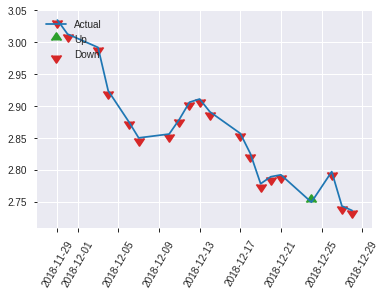


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25839607852181573
RMSE: 0.5083267438585302
LogLoss: 0.7103312298568343
Mean Per-Class Error: 0.4051011029411764
AUC: 0.5859375
pr_auc: 0.5781224424157915
Gini: 0.171875
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3450293216665724: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    112  0.9412   (112.0/119.0)
1      0    128  0        (0.0/128.0)
Total  7    240  0.4534   (112.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.345029     0.695652  239
max f2                       0.345029     0.851064  239
max f0point5                 0.399427     0.609177  125
max accuracy                 0.399427     0.595142  125
max precision                0.56838      1         0
max recall                   0.345029     1         239
max specificity              0.56838      1         0
max absolute_mcc             0.399427     0.189711  125
max min_per_class_accuracy   0.399582     0.588235  124
max mean_per_class_accuracy  0.399427     0.594899  125

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 40.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.542686           0.643229  0.643229           0.333333         0.552793  0.333333                    0.552793            0.0078125       0.0078125                  -35.6771  -35.6771
    2        0.0202429                   0.540431           0.964844  0.771875           0.5              0.541699  0.4                         0.548355            0.0078125       0.015625                   -3.51562  -22.8125
    3        0.0323887                   0.537083           1.92969   1.20605            1                0.538331  0.625                       0.544596            0.0234375       0.0390625                  92.9688   20.6055
    4        0.0404858                   0.532143           1.92969   1.35078            1                0.534702  0.7                         0.542617            0.015625        0.0546875                  92.9688   35.0781
    5        0.0526316                   0.514194           1.28646   1.33594            0.666667         0.522021  0.692308                    0.537864            0.015625        0.0703125                  28.6458   33.5938
    6        0.101215                    0.447714           0.964844  1.15781            0.5              0.475563  0.6                         0.50796             0.046875        0.117188                   -3.51562  15.7812
    7        0.149798                    0.426697           0.964844  1.09523            0.5              0.438866  0.567568                    0.485551            0.046875        0.164062                   -3.51562  9.5228
    8        0.202429                    0.418152           1.33594   1.15781            0.692308         0.421331  0.6                         0.468854            0.0703125       0.234375                   33.5938   15.7812
    9        0.299595                    0.409843           0.964844  1.09523            0.5              0.41395   0.567568                    0.451047            0.09375         0.328125                   -3.51562  9.5228
    10       0.40081                     0.404202           1.31219   1.15002            0.68             0.407275  0.59596                     0.439993            0.132812        0.460938                   31.2188   15.0016
    11       0.502024                    0.399719           1.235     1.16715            0.64             0.401694  0.604839                    0.432272            0.125           0.585938                   23.5      16.715
    12       0.59919                     0.39468            0.804036  1.10827            0.416667         0.396908  0.574324                    0.426537            0.078125        0.664062                   -19.5964  10.8266
    13       0.700405                    0.385703           0.849062  1.07081            0.44             0.390862  0.554913                    0.421382            0.0859375       0.75                       -15.0938  7.08092
    14       0.797571                    0.372767           0.88444   1.0481             0.458333         0.380458  0.543147                    0.416396            0.0859375       0.835938                   -11.556   4.81044
    15       0.898785                    0.355379           0.92625   1.03438            0.48             0.366234  0.536036                    0.410747            0.09375         0.929688                   -7.375    3.4382
    16       1                           0.342021           0.694688  1                  0.36             0.348132  0.518219                    0.40441            

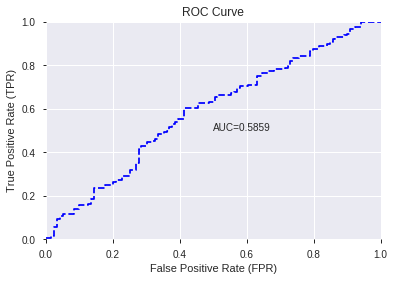

This function is available for GLM models only


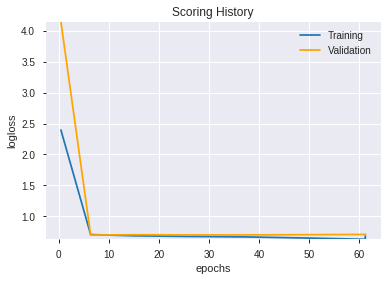

--2019-08-24 18:15:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.226.176
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.226.176|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_174827_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_174827_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_8441',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['SAREXT',
 'CDLSPINNINGTOP',
 'days_in_month',
 'aroondown_8',
 'weekday',
 'STOCHRSI_fastk',
 'MACDEXT_hist',
 'CORREL_12',
 'NATR_24',
 'HT_PHASOR_quadrature',
 'AROONOSC_24',
 'TRANGE',
 'aroonup_30',
 'weekday_name',
 'ADXR_8',
 'HT_DCPERIOD',
 'CDLDOJI',
 'aroondown_30',
 'MINUS_DM_20',
 'AROONOSC_8',
 'MINUS_DM_30',
 'dayofyear',
 'CORREL_8',
 'HT_TRENDMODE',
 'DX_12',
 'LINEARREG_SLOPE_20',
 'AROONOSC_30',
 'DX_20',
 'MACDFIX_signal_24',
 'AROONOSC_12',
 'BOP',
 'DIV',
 'ADX_24',
 'aroonup_14',
 'ATR_20',
 'WILLR_14',
 'PLUS_DI_14',
 'AROONOSC_14',
 'STOCH_slowd',
 'MOM_8',
 'MINUS_DM_8',
 'aroonup_24',
 'MACDFIX_hist_20',
 'STOCHRSI_fastd',
 'MINUS_DI_24',
 'BETA_24',
 'PLUS_DI_24',
 'aroonup_8',
 'VAR_8',
 'BETA_30',
 'HT_PHASOR_inphase',
 'NATR_30',
 'BETA_20',
 'PLUS_DM_30',
 'DX_24',
 'CMO_12',
 'AROONOSC_20',
 'MINUS_DM_24',
 'CDLSHORTLINE',
 'day',
 'PLUS_DM_8',
 'ATR_30',
 'MINUS_DI_20',
 'MACDFIX_signal_14',
 'dayofweek',
 'DX_8',
 'APO',
 'MACD',
 'CDLDARKCLOUDCOVER',

In [53]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_181505_model_1  0.505712  0.698664               0.47479  0.502741  0.252748

variable  relative_importance  scaled_importance    percentage
0                 CDLTHRUSTING         9.367234e-03           1.000000  1.608365e-02
1                   aroonup_12         7.032796e-03           0.750787  1.207539e-02
2                          day         6.970307e-03           0.744116  1.196810e-02
3                  CDL3OUTSIDE         5.918498e-03           0.631830  1.016213e-02
4            CDLGRAVESTONEDOJI         5.593468e-03           0.597131  9.604050e-03
...                        ...                  ...                ...           ...
1025  BBANDS_middleband_14_1_2         1.180914e-06           0.000126  2.027643e-06
1026                    MA_8_2         1.141812e-06           0.000122  1.960504e-06
1027   BBANDS_middleband_8_1_4         8.159180e-07           0.000087  1.400941e-06
1028  BBANDS_middleband_24_2_3         5.670155e-07           0.000061  9.735724e-07
1029   BBANDS_lowerband_12_1_3         4.019814e-07           0.000043  6.902068e-07

[1030 rows x 4 columns]

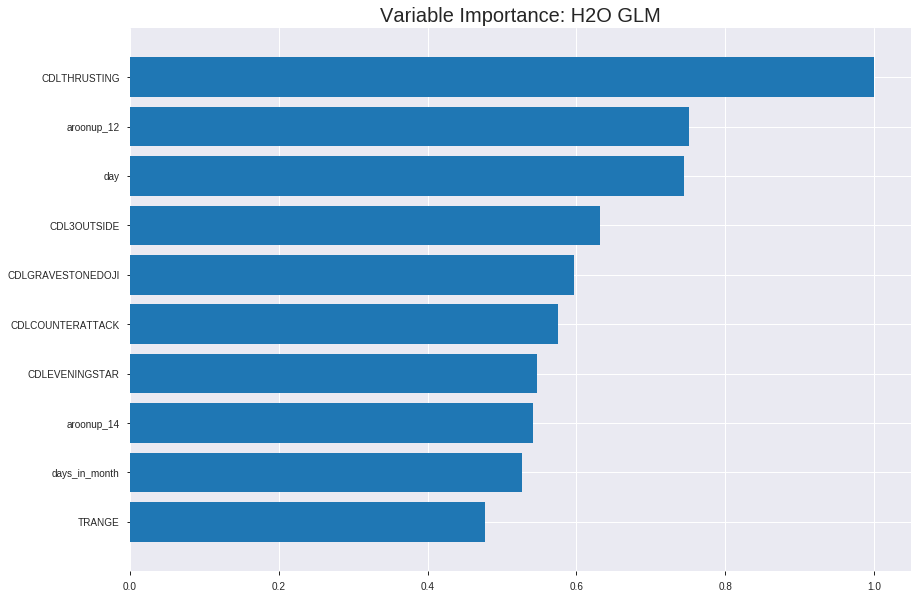

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_181505_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24653174895465965
RMSE: 0.49651963602123494
LogLoss: 0.6861806534450965
Null degrees of freedom: 1723
Residual degrees of freedom: 693
Null deviance: 2386.25784815377
Residual deviance: 2365.950893078693
AIC: 4427.950893078692
AUC: 0.5721214279163362
pr_auc: 0.548351340799308
Gini: 0.1442428558326725
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4161006562713052: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      16   886   0.9823   (886.0/902.0)
1      2    820   0.0024   (2.0/822.0)
Total  18   1706  0.5151   (888.0/1724.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.416101     0.648734  383
max f2                       0.403595     0.821343  391
max f0point5                 0.464517     0.543315  254
max accuracy                 0.491491     0.562065  148
max precision                0.585981     1         0
max recall                   0.403595     1         391
max specificity              0.585981     1         0
max absolute_mcc             0.504344     0.1257    103
max min_per_class_accuracy   0.475565     0.540146  209
max mean_per_class_accuracy  0.486829     0.553834  166

Gains/Lift Table: Avg response rate: 47.68 %, avg score: 47.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0104408                   0.550264           1.51473   1.51473            0.722222         0.562406  0.722222                    0.562406            0.0158151       0.0158151                  51.4734    51.4734
    2        0.0203016                   0.536824           1.11035   1.31832            0.529412         0.541972  0.628571                    0.552481            0.0109489       0.026764                   11.0348    31.8318
    3        0.0301624                   0.529207           1.35709   1.33099            0.647059         0.53341   0.634615                    0.546246            0.013382        0.040146                   35.7092    33.0994
    4        0.0400232                   0.525599           1.48046   1.36782            0.705882         0.52752   0.652174                    0.541633            0.0145985       0.0547445                  48.0464    36.782
    5        0.050464                    0.522784           1.39822   1.37411            0.666667         0.524219  0.655172                    0.53803             0.0145985       0.0693431                  39.8216    37.4109
    6        0.100348                    0.510672           1.31692   1.34568            0.627907         0.516115  0.641618                    0.527136            0.0656934       0.135036                   31.6924    34.5682
    7        0.150232                    0.504835           1.19499   1.29564            0.569767         0.5076    0.617761                    0.520649            0.0596107       0.194647                   19.4987    29.5644
    8        0.200116                    0.499147           1.04866   1.23408            0.5              0.501778  0.588406                    0.515945            0.0523114       0.246959                   4.86618    23.4077
    9        0.299884                    0.489912           1.08524   1.18456            0.517442         0.494386  0.564797                    0.508772            0.108273        0.355231                   8.5243     18.4562
    10       0.400232                    0.482722           0.945614  1.12465            0.450867         0.4862    0.536232                    0.503113            0.0948905       0.450122                   -5.43859   12.4652
    11       0.5                         0.474995           0.938918  1.08759            0.447674         0.479048  0.518561                    0.498311            0.093674        0.543796                   -6.10819   8.75912
    12       0.599768                    0.467711           0.987693  1.07097            0.47093          0.47144   0.510638                    0.493841            0.0985401       0.642336                   -1.23069   7.09738
    13       0.700116                    0.461314           0.994107  1.05996            0.473988         0.464533  0.505385                    0.489641            0.0997567       0.742092                   -0.589286  5.99564
    14       0.799884                    0.45487            0.890143  1.03878            0.424419         0.458121  0.495286                    0.485709            0.0888078       0.8309                     -10.9857   3.87759
    15       0.899652                    0.444868           0.816981  1.01418            0.389535         0.450264  0.483559                    0.481778            0.0815085       0.912409                   -18.3019   1.41797
    16       1                           0.383476           0.872875  1                  0.416185         0.432148  0.476798                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.252498666243765
RMSE: 0.5024924539172354
LogLoss: 0.6983451614609718
Null degrees of freedom: 491
Residual degrees of freedom: -539
Null deviance: 684.603379765711
Residual deviance: 687.1716388775963
AIC: 2749.1716388775963
AUC: 0.52152120690796
pr_auc: 0.5264514216948992
Gini: 0.04304241381592
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37999291782368017: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    238  1        (238.0/238.0)
1      0    254  0        (0.0/254.0)
Total  0    492  0.4837   (238.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.379993     0.680965   399
max f2                       0.379993     0.842175   399
max f0point5                 0.451505     0.575292   324
max accuracy                 0.451505     0.536585   324
max precision                0.561072     0.666667   2
max recall                   0.379993     1          399
max specificity              0.759647     0.995798   0
max absolute_mcc             0.425206     0.0717838  382
max min_per_class_accuracy   0.471973     0.508403   199
max mean_per_class_accuracy  0.459352     0.528436   272

Gains/Lift Table: Avg response rate: 51.63 %, avg score: 47.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.552899           0.774803  0.774803           0.4              0.600484  0.4                         0.600484            0.00787402      0.00787402                 -22.5197  -22.5197
    2        0.0203252                   0.537978           1.1622    0.968504           0.6              0.546339  0.5                         0.573411            0.011811        0.019685                   16.2205   -3.14961
    3        0.0304878                   0.532129           0.387402  0.774803           0.2              0.535043  0.4                         0.560622            0.00393701      0.023622                   -61.2598  -22.5197
    4        0.0406504                   0.528792           1.1622    0.871654           0.6              0.531706  0.45                        0.553393            0.011811        0.0354331                  16.2205   -12.8346
    5        0.050813                    0.523054           0.774803  0.852283           0.4              0.525159  0.44                        0.547746            0.00787402      0.0433071                  -22.5197  -14.7717
    6        0.101626                    0.506553           1.31717   1.08472            0.68             0.513548  0.56                        0.530647            0.0669291       0.110236                   31.7165   8.47244
    7        0.150407                    0.500617           1.04921   1.07321            0.541667         0.502726  0.554054                    0.521592            0.0511811       0.161417                   4.92126   7.32071
    8        0.20122                     0.495235           0.929764  1.03698            0.48             0.497868  0.535354                    0.515601            0.0472441       0.208661                   -7.02362  3.6984
    9        0.300813                    0.483837           1.06733   1.04703            0.55102          0.48865   0.540541                    0.506678            0.106299        0.314961                   6.73309   4.70313
    10       0.400407                    0.477996           0.948739  1.02258            0.489796         0.480662  0.527919                    0.500207            0.0944882       0.409449                   -5.12614  2.25828
    11       0.5                         0.472068           0.988269  1.01575            0.510204         0.475156  0.52439                     0.495217            0.0984252       0.507874                   -1.17307  1.5748
    12       0.599593                    0.465478           1.14639   1.03745            0.591837         0.46895   0.535593                    0.490854            0.114173        0.622047                   14.6392   3.74483
    13       0.699187                    0.458421           0.948739  1.02481            0.489796         0.461712  0.52907                     0.486703            0.0944882       0.716535                   -5.12614  2.48123
    14       0.79878                     0.453441           1.0278    1.02518            0.530612         0.455741  0.529262                    0.482842            0.102362        0.818898                   2.78001   2.51848
    15       0.898374                    0.443982           0.830146  1.00356            0.428571         0.449653  0.5181                      0.479163            0.0826772       0.901575                   -16.9854  0.35629
    16       1                           0.379993           0.968504  1                  0.5              0.425719  0.51626                     0.473732      


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 18:15:08  0.000 sec   2            3.4       1031          1.37236           1.39669
    2019-08-24 18:15:10  1.734 sec   4            2.5       1031          1.36979           1.39862
    2019-08-24 18:15:12  3.580 sec   6            1.8       1031          1.36664           1.40137
    2019-08-24 18:15:14  5.317 sec   8            1.3       1031          1.36291           1.4052
    2019-08-24 18:15:15  7.065 sec   10           0.95      1031          1.35858           1.41046

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5465587044534413)

('F1', 0.6937669376693767)

('auc', 0.5057116596638656)

('logloss', 0.6986639315619737)

('mean_per_class_error', 0.46940651260504196)

('rmse', 0.5027407616104704)

('mse', 0.25274827338467587)

glm prediction progress: |████████████████████████████████████████████████| 100%


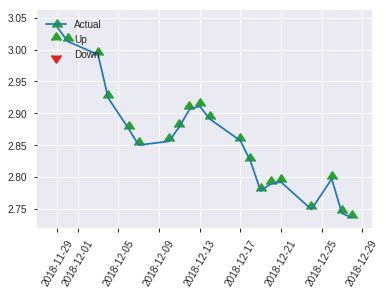


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25274827338467587
RMSE: 0.5027407616104704
LogLoss: 0.6986639315619737
Null degrees of freedom: 246
Residual degrees of freedom: -784
Null deviance: 343.7830139951905
Residual deviance: 345.139982191615
AIC: 2407.1399821916148
AUC: 0.5057116596638656
pr_auc: 0.5250153006208267
Gini: 0.011423319327731107
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42790388289992176: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    113  0.9496   (113.0/119.0)
1      0    128  0        (0.0/128.0)
Total  6    241  0.4575   (113.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.427904     0.693767  240
max f2                       0.427904     0.849934  240
max f0point5                 0.433742     0.587687  235
max accuracy                 0.434585     0.546559  231
max precision                0.535442     1         0
max recall                   0.427904     1         240
max specificity              0.535442     1         0
max absolute_mcc             0.427904     0.163643  240
max min_per_class_accuracy   0.456831     0.495798  123
max mean_per_class_accuracy  0.434585     0.530593  231

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 46.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.516007           1.28646   1.28646            0.666667         0.527414  0.666667                    0.527414            0.015625        0.015625                   28.6458   28.6458
    2        0.0202429                   0.512543           0.964844  1.15781            0.5              0.513887  0.6                         0.522003            0.0078125       0.0234375                  -3.51562  15.7812
    3        0.0323887                   0.509653           1.92969   1.44727            1                0.51198   0.75                        0.518245            0.0234375       0.046875                   92.9688   44.7266
    4        0.0404858                   0.501571           0.964844  1.35078            0.5              0.505331  0.7                         0.515662            0.0078125       0.0546875                  -3.51562  35.0781
    5        0.0526316                   0.498568           0         1.03906            0                0.499676  0.538462                    0.511973            0               0.0546875                  -100      3.90625
    6        0.101215                    0.491986           0.643229  0.849062           0.333333         0.494636  0.44                        0.503651            0.03125         0.0859375                  -35.6771  -15.0938
    7        0.149798                    0.483711           1.12565   0.938767           0.583333         0.487797  0.486486                    0.498509            0.0546875       0.140625                   12.5651   -6.12331
    8        0.202429                    0.479248           1.1875    1.00344            0.615385         0.481407  0.52                        0.494063            0.0625          0.203125                   18.75     0.34375
    9        0.299595                    0.469936           0.964844  0.990921           0.5              0.474184  0.513514                    0.487616            0.09375         0.296875                   -3.51562  -0.907939
    10       0.40081                     0.461618           1.00344   0.994081           0.52             0.465781  0.515152                    0.482102            0.101562        0.398438                   0.34375   -0.591856
    11       0.502024                    0.456831           1.00344   0.995968           0.52             0.458935  0.516129                    0.477431            0.101562        0.5                        0.34375   -0.403226
    12       0.59919                     0.450896           0.964844  0.990921           0.5              0.453734  0.513514                    0.473588            0.09375         0.59375                    -3.51562  -0.907939
    13       0.700405                    0.448655           1.15781   1.01504            0.6              0.449717  0.526012                    0.470139            0.117188        0.710938                   15.7812   1.50379
    14       0.797571                    0.444227           0.804036  0.989332           0.416667         0.446103  0.51269                     0.46721             0.078125        0.789062                   -19.5964  -1.06678
    15       0.898785                    0.437175           1.235     1.017              0.64             0.440832  0.527027                    0.46424             0.125           0.914062                   23.5      1.69975
    16       1                           0.419989           0.849062  1                  0.44             0.431896  0.518219                    0.4609

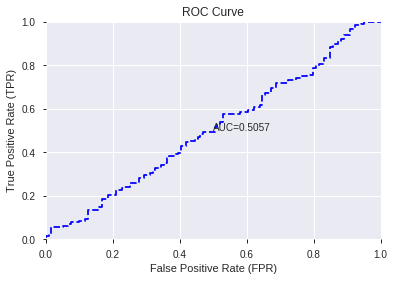

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


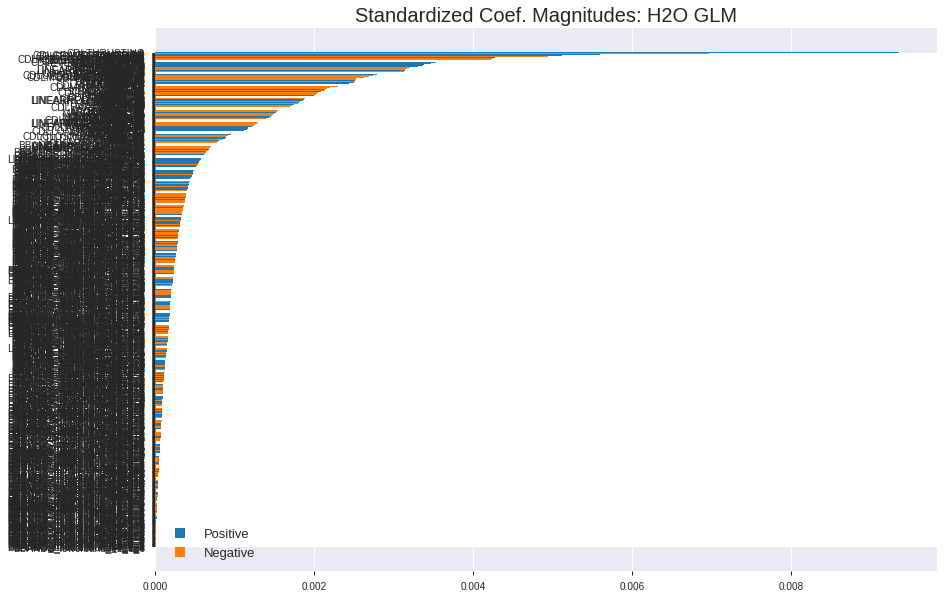

'log_likelihood'
--2019-08-24 18:15:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.100.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.100.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_181505_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_181505_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_8441',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLTHRUSTING',
 'aroonup_12',
 'day',
 'CDL3OUTSIDE',
 'CDLGRAVESTONEDOJI',
 'CDLCOUNTERATTACK',
 'CDLEVENINGSTAR',
 'aroonup_14',
 'days_in_month',
 'TRANGE',
 'DIV',
 'aroondown_12',
 'HT_PHASOR_quadrature',
 'CDLXSIDEGAP3METHODS',
 'CDLSTICKSANDWICH',
 'CDLHOMINGPIGEON',
 'weekday',
 'dayofweek',
 'AROONOSC_20',
 'CDLEVENINGDOJISTAR',
 'MINUS_DM_8',
 'CDLDOJISTAR',
 'aroondown_20',
 'SUB',
 'BETA_30',
 'DX_8',
 'CDL3LINESTRIKE',
 'aroonup_20',
 'AROONOSC_14',
 'MACDEXT_hist',
 'HT_DCPERIOD',
 'CDLBELTHOLD',
 'TAN',
 'LINEARREG_SLOPE_8',
 'LINEARREG_ANGLE_8',
 'ROCR_8',
 'ROCR100_8',
 'DX_12',
 'ROCP_8',
 'ROC_8',
 'MOM_8',
 'CDLADVANCEBLOCK',
 'CORREL_30',
 'WILLR_8',
 'is_month_end',
 'MINUS_DM_12',
 'CDLUPSIDEGAP2CROWS',
 'CDLENGULFING',
 'CDLUNIQUE3RIVER',
 'CDLHANGINGMAN',
 'CDLMORNINGDOJISTAR',
 'DX_14',
 'MOM_24',
 'RSI_8',
 'ROCP_24',
 'ROCR_24',
 'ROCR100_24',
 'ROC_24',
 'ADXR_8',
 'CMO_8',
 'STOCH_slowd',
 'CDLHAMMER',
 'MINUS_DI_8',
 'MINUS_DM_14',
 'NATR_8',
 'CDL3INSI

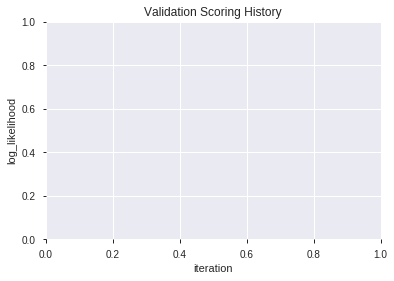

In [54]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_181538_model_6  0.538340  0.711111              0.478105  0.508489  0.258562
1  XGBoost_grid_1_AutoML_20190824_181538_model_2  0.502626  0.709136              0.491597  0.507704  0.257763
2  XGBoost_grid_1_AutoML_20190824_181538_model_5  0.502363  0.737134              0.474199  0.520351  0.270766
3  XGBoost_grid_1_AutoML_20190824_181538_model_1  0.488445  0.711571              0.487395  0.508608  0.258682
4               XGBoost_2_AutoML_20190824_181538  0.471442  0.725063              0.500000  0.515002  0.265227
5  XGBoost_grid_1_AutoML_20190824_181538_model_7  0.471245  0.737977              0.491597  0.520748  0.271178
6  XGBoost_grid_1_AutoML_20190824_181538_model_4  0.469275  0.716060              0.500000  0.511070  0.261193
7               XGBoost_3_AutoML_20190824_181538  0.466518  0.718236              0.491597  0.512129  0.262276
8  XGBoost_grid_1_AutoML_20190824_181538_model_3  0.459756  0.727193              0.495798  0.516298  0.266564
9               XGBoost_1_AutoML_20190824_181538  0.397715  0.752792              0.487100  0.528061  0.278848

variable  relative_importance  scaled_importance  percentage
0                        BOP           155.983307           1.000000    0.022104
1          HT_PHASOR_inphase           111.264259           0.713309    0.015767
2                  CORREL_14           106.980576           0.685846    0.015160
3                HT_DCPERIOD            95.862968           0.614572    0.013585
4                        day            93.057709           0.596588    0.013187
..                       ...                  ...                ...         ...
314  BBANDS_lowerband_14_1_4             3.971642           0.025462    0.000563
315  BBANDS_lowerband_30_5_3             3.207326           0.020562    0.000455
316  BBANDS_upperband_24_0_4             3.053950           0.019579    0.000433
317                  TRIX_12             2.532254           0.016234    0.000359
318  BBANDS_upperband_14_5_2             1.849610           0.011858    0.000262

[319 rows x 4 columns]

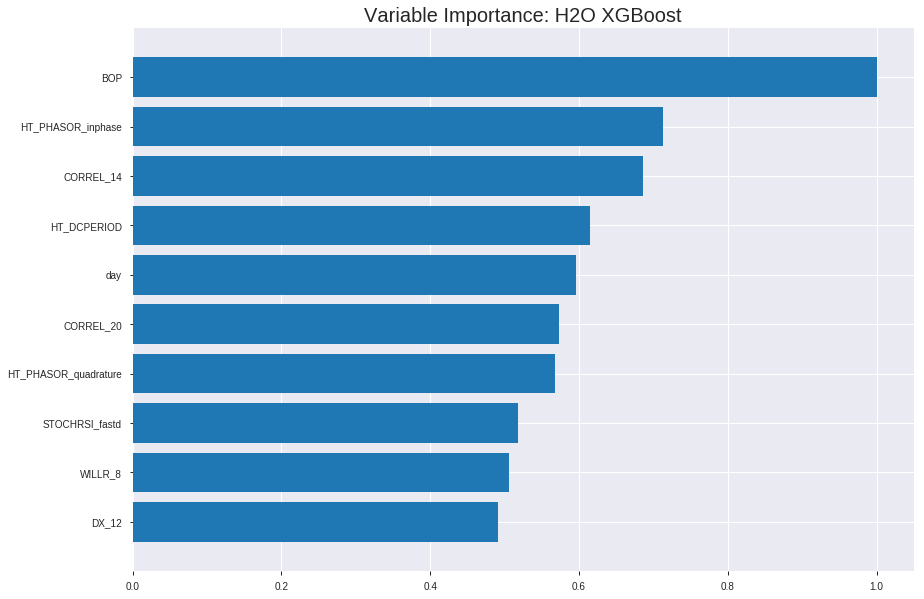

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_181538_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1797756551709558
RMSE: 0.4239995933617812
LogLoss: 0.5490162180993653
Mean Per-Class Error: 0.11462632376821447
AUC: 0.9539027896914669
pr_auc: 0.9501489374983978
Gini: 0.9078055793829338
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46792321900526684: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      783  119  0.1319   (119.0/902.0)
1      80   742  0.0973   (80.0/822.0)
Total  863  861  0.1154   (199.0/1724.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.467923     0.881759  216
max f2                       0.443767     0.915674  242
max f0point5                 0.488867     0.896498  193
max accuracy                 0.481021     0.886311  202
max precision                0.777526     1         0
max recall                   0.335773     1         356
max specificity              0.777526     1         0
max absolute_mcc             0.481021     0.772165  202
max min_per_class_accuracy   0.473226     0.881995  210
max mean_per_class_accuracy  0.467923     0.885374  216

Gains/Lift Table: Avg response rate: 47.68 %, avg score: 47.85 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104408                   0.713247           2.09732    2.09732            1                0.738644  1                           0.738644            0.0218978       0.0218978                  109.732   109.732
    2        0.0203016                   0.699776           2.09732    2.09732            1                0.70646   1                           0.723012            0.0206813       0.0425791                  109.732   109.732
    3        0.0301624                   0.687449           2.09732    2.09732            1                0.693529  1                           0.713373            0.0206813       0.0632603                  109.732   109.732
    4        0.0400232                   0.676942           2.09732    2.09732            1                0.681802  1                           0.705595            0.0206813       0.0839416                  109.732   109.732
    5        0.050464                    0.667621           2.09732    2.09732            1                0.672023  1                           0.698649            0.0218978       0.105839                   109.732   109.732
    6        0.100348                    0.625801           2.09732    2.09732            1                0.648082  1                           0.673512            0.104623        0.210462                   109.732   109.732
    7        0.150232                    0.600571           2.09732    2.09732            1                0.612868  1                           0.653375            0.104623        0.315085                   109.732   109.732
    8        0.200116                    0.575338           2.02416    2.07909            0.965116         0.587454  0.991304                    0.636943            0.100973        0.416058                   102.416   107.909
    9        0.299884                    0.539355           1.91442    2.0243             0.912791         0.556035  0.965184                    0.610026            0.190998        0.607056                   91.4417   102.43
    10       0.400232                    0.49927            1.69726    1.9423             0.809249         0.519575  0.926087                    0.587347            0.170316        0.777372                   69.7256   94.2304
    11       0.5                         0.467285           1.25596    1.80535            0.598837         0.483506  0.860789                    0.566627            0.125304        0.902676                   25.5955   80.5353
    12       0.599768                    0.43535            0.5853     1.6024             0.27907          0.451673  0.764023                    0.547505            0.0583942       0.961071                   -41.47    60.2404
    13       0.700116                    0.408949           0.303081   1.41617            0.144509         0.42201   0.675228                    0.529518            0.0304136       0.991484                   -69.6919  41.6171
    14       0.799884                    0.380681           0.0365812  1.2441             0.0174419        0.396072  0.593183                    0.512874            0.00364964      0.995134                   -96.3419  24.4098
    15       0.899652                    0.344514           0.0365812  1.11019            0.0174419        0.364311  0.529336                    0.496399            0.00364964      0.998783                   -96.3419  11.0189
    16       1                           0.252915           0.0121233  1                  0.00578035       0.317563  0.476798                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2555611715387795
RMSE: 0.5055305841774358
LogLoss: 0.7048672940745491
Mean Per-Class Error: 0.4704393568451002
AUC: 0.5197677496195329
pr_auc: 0.5345258696672472
Gini: 0.03953549923906574
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26559799909591675: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    237  0.9958   (237.0/238.0)
1      0    254  0        (0.0/254.0)
Total  1    491  0.4817   (237.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.265598     0.681879   398
max f2                       0.265598     0.842734   398
max f0point5                 0.343644     0.576564   379
max accuracy                 0.403185     0.538618   320
max precision                0.732666     0.666667   2
max recall                   0.265598     1          398
max specificity              0.764618     0.995798   0
max absolute_mcc             0.319265     0.0819489  392
max min_per_class_accuracy   0.474318     0.504202   206
max mean_per_class_accuracy  0.498928     0.529561   168

Gains/Lift Table: Avg response rate: 51.63 %, avg score: 48.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.711119           1.1622    1.1622             0.6              0.733104  0.6                         0.733104            0.011811        0.011811                   16.2205   16.2205
    2        0.0203252                   0.696068           1.1622    1.1622             0.6              0.702431  0.6                         0.717768            0.011811        0.023622                   16.2205   16.2205
    3        0.0304878                   0.670359           1.1622    1.1622             0.6              0.681489  0.6                         0.705675            0.011811        0.0354331                  16.2205   16.2205
    4        0.0406504                   0.659139           1.1622    1.1622             0.6              0.665027  0.6                         0.695513            0.011811        0.0472441                  16.2205   16.2205
    5        0.050813                    0.652294           0.774803  1.08472            0.4              0.656334  0.56                        0.687677            0.00787402      0.0551181                  -22.5197  8.47244
    6        0.101626                    0.618175           1.00724   1.04598            0.52             0.630393  0.54                        0.659035            0.0511811       0.106299                   0.724409  4.59843
    7        0.150407                    0.590042           1.12992   1.07321            0.583333         0.602721  0.554054                    0.640771            0.0551181       0.161417                   12.9921   7.32071
    8        0.20122                     0.562332           0.929764  1.03698            0.48             0.576625  0.535354                    0.624573            0.0472441       0.208661                   -7.02362  3.6984
    9        0.300813                    0.524057           0.948739  1.00777            0.489796         0.541815  0.52027                     0.597173            0.0944882       0.30315                    -5.12614  0.776761
    10       0.400407                    0.4991             1.22545   1.06191            0.632653         0.510265  0.548223                    0.575556            0.122047        0.425197                   22.5454   6.19129
    11       0.5                         0.474459           0.790615  1.00787            0.408163         0.486003  0.520325                    0.557718            0.0787402       0.503937                   -20.9385  0.787402
    12       0.599593                    0.453213           0.909208  0.991485           0.469388         0.464151  0.511864                    0.542177            0.0905512       0.594488                   -9.07922  -0.851461
    13       0.699187                    0.427881           1.22545   1.02481            0.632653         0.441151  0.52907                     0.527786            0.122047        0.716535                   22.5454   2.48123
    14       0.79878                     0.408951           1.0278    1.02518            0.530612         0.418654  0.529262                    0.51418             0.102362        0.818898                   2.78001   2.51848
    15       0.898374                    0.380477           0.948739  1.01671            0.489796         0.395202  0.524887                    0.50099             0.0944882       0.913386                   -5.12614  1.671
    16       1                           0.232235           0.852283  1                  0.44             0.344676  0.51626                     0.485104        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 18:16:10  19.430 sec  0                  0.5              0.693147            0.5             0                  1                0.523202                         0.5                0.693147              0.5               0                    1                  0.48374
    2019-08-24 18:16:10  19.900 sec  5                  0.490253         0.673805            0.754912        0.739061           1.98081          0.352088                         0.501154           0.695462              0.490497          0.514184             1.93701            0.48374
    2019-08-24 18:16:10  20.059 sec  10                 0.479531         0.652865            0.833924        0.825756           1.98081          0.260441                         0.501513           0.696196              0.49751           0.512437             0.774803           0.48374
    2019-08-24 18:16:10  20.222 sec  15                 0.471674         0.637701            0.863437        0.854968           2.09732          0.234919                         0.502022           0.697242              0.500455          0.520936             0.774803           0.48374
    2019-08-24 18:16:10  20.367 sec  20                 0.465674         0.626186            0.877804        0.872081           2.09732          0.198376                         0.50201            0.697273              0.51397           0.530176             0.774803           0.481707
    2019-08-24 18:16:11  20.512 sec  25                 0.457838         0.61138             0.903925        0.896869           2.09732          0.191995                         0.503561           0.700472              0.504607          0.522162             1.1622             0.48374
    2019-08-24 18:16:11  20.661 sec  30                 0.451039         0.598617            0.91563         0.909476           2.09732          0.165893                         0.503006           0.699412              0.516583          0.535625             1.1622             0.48374
    2019-08-24 18:16:11  20.829 sec  35                 0.443291         0.584275            0.932141        0.926034           2.09732          0.137471                         0.503555           0.700574              0.517832          0.537198             1.1622             0.481707
    2019-08-24 18:16:11  20.993 sec  40                 0.436706         0.572128            0.94096         0.936348           2.09732          0.138051                         0.504264           0.702073              0.518924          0.537839             1.1622             0.469512
    2019-08-24 18:16:11  21.154 sec  45                 0.429842         0.559607            0.948094        0.942454           2.09732          0.114849                         0.505264           0.70417               0.517162          0.531427             0.774803           0.481707
    2019-08-24 18:16:11  21.324 sec  50                 0.424            0.549016            0.953903        0.950149           2.09732          0.115429                         0.505531           0.704867              0.519768          0.534526             1.1622             0.481707

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
BOP                      155.98330688476562     1.0                   0.02210441592948998
HT_PHASOR_inphase        111.2642593383789      0.7133087607930803    0.015767273534719323
CORREL_14                106.98057556152344     0.6858463107244963    0.015160232115960492
HT_DCPERIOD              95.86296844482422      0.614571971574138     0.01358475447828144
day                      93.05770874023438      0.5965876131154327    0.013187220738685178
---                      ---                    ---                   ---
BBANDS_lowerband_14_1_4  3.971641778945923      0.025461966785202322  0.000562821904202971
BBANDS_lowerband_30_5_3  3.2073259353637695     0.020561981916008592  0.0004545106006061053
BBANDS_upperband_24_0_4  3.053950309753418      0.019578699610526638  0.00043277571954962435
TRIX_12                  2.532254219055176      0.01623413600870705   0.000358846094592371
BBANDS_upperband_14_5_2  1.849610447883606      0.011857746093625427  0.00026210855163978153


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5708502024291497)

('F1', 0.6868131868131868)

('auc', 0.5383403361344538)

('logloss', 0.7111113365529472)

('mean_per_class_error', 0.42617515756302526)

('rmse', 0.5084894716231878)

('mse', 0.25856154275162874)

xgboost prediction progress: |████████████████████████████████████████████| 100%


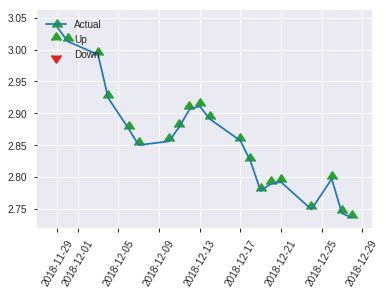


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25856154275162874
RMSE: 0.5084894716231878
LogLoss: 0.7111113365529472
Mean Per-Class Error: 0.42617515756302526
AUC: 0.5383403361344538
pr_auc: 0.5325307218811604
Gini: 0.07668067226890751
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31799474358558655: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    111  0.9328   (111.0/119.0)
1      3    125  0.0234   (3.0/128.0)
Total  11   236  0.4615   (114.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.317995     0.686813  235
max f2                       0.231493     0.843215  246
max f0point5                 0.317995     0.583022  235
max accuracy                 0.442871     0.57085   103
max precision                0.709031     1         0
max recall                   0.231493     1         246
max specificity              0.709031     1         0
max absolute_mcc             0.442871     0.149426  103
max min_per_class_accuracy   0.43055      0.5625    123
max mean_per_class_accuracy  0.442871     0.573825  103

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 44.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.647327           1.28646   1.28646            0.666667         0.676104  0.666667                    0.676104            0.015625        0.015625                   28.6458   28.6458
    2        0.0202429                   0.628208           0         0.771875           0                0.632782  0.4                         0.658775            0               0.015625                   -100      -22.8125
    3        0.0323887                   0.620867           0.643229  0.723633           0.333333         0.624754  0.375                       0.646018            0.0078125       0.0234375                  -35.6771  -27.6367
    4        0.0404858                   0.60906            0.964844  0.771875           0.5              0.615641  0.4                         0.639942            0.0078125       0.03125                    -3.51562  -22.8125
    5        0.0526316                   0.587272           0.643229  0.742188           0.333333         0.598602  0.384615                    0.630402            0.0078125       0.0390625                  -35.6771  -25.7812
    6        0.101215                    0.562977           1.28646   1.00344            0.666667         0.572998  0.52                        0.602848            0.0625          0.101562                   28.6458   0.34375
    7        0.149798                    0.531059           0.804036  0.938767           0.416667         0.550987  0.486486                    0.586028            0.0390625       0.140625                   -19.5964  -6.12331
    8        0.202429                    0.508337           1.33594   1.04203            0.692308         0.518574  0.54                        0.56849             0.0703125       0.210938                   33.5938   4.20312
    9        0.299595                    0.467575           1.28646   1.1213             0.666667         0.485981  0.581081                    0.54173             0.125           0.335938                   28.6458   12.1305
    10       0.40081                     0.447493           1.235     1.15002            0.64             0.456209  0.59596                     0.520134            0.125           0.460938                   23.5      15.0016
    11       0.502024                    0.43055            1.00344   1.12046            0.52             0.437878  0.580645                    0.50355             0.101562        0.5625                     0.34375   12.0464
    12       0.59919                     0.408392           0.562826  1.03004            0.291667         0.419099  0.533784                    0.489855            0.0546875       0.617188                   -43.7174  3.00359
    13       0.700405                    0.396182           0.771875  0.992729           0.4              0.402868  0.514451                    0.477285            0.078125        0.695312                   -22.8125  -0.727059
    14       0.797571                    0.376232           0.964844  0.989332           0.5              0.385376  0.51269                     0.466088            0.09375         0.789062                   -3.51562  -1.06678
    15       0.898785                    0.350794           1.08063   0.999613           0.56             0.362522  0.518018                    0.454425            0.109375        0.898438                   8.0625    -0.0387106
    16       1                           0.231493           1.00344   1                  0.52             0.316823  0.518219                    0.4404

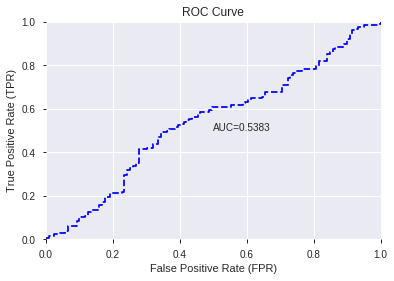

This function is available for GLM models only


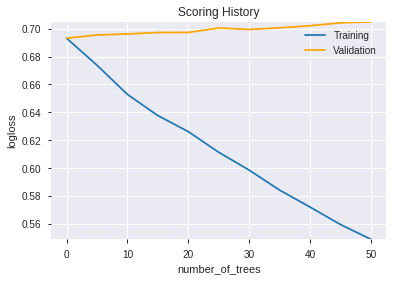

--2019-08-24 18:16:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.98.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.98.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_181538_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_181538_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_8441',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'HT_PHASOR_inphase',
 'CORREL_14',
 'HT_DCPERIOD',
 'day',
 'CORREL_20',
 'HT_PHASOR_quadrature',
 'STOCHRSI_fastd',
 'WILLR_8',
 'DX_12',
 'DX_20',
 'CORREL_24',
 'NATR_14',
 'BETA_30',
 'MINUS_DI_8',
 'AROONOSC_30',
 'MINUS_DM_30',
 'DX_14',
 'LINEARREG_ANGLE_12',
 'DX_24',
 'PPO',
 'SAREXT',
 'PLUS_DI_8',
 'dayofyear',
 'PLUS_DM_30',
 'CCI_14',
 'CCI_12',
 'BETA_14',
 'DIV',
 'MOM_24',
 'ULTOSC',
 'DX_8',
 'BETA_20',
 'MOM_12',
 'BETA_24',
 'ROC_8',
 'aroonup_24',
 'BBANDS_lowerband_14_6_5',
 'STOCH_slowd',
 'AROONOSC_20',
 'CCI_8',
 'aroonup_12',
 'STOCH_slowk',
 'CMO_20',
 'CCI_24',
 'SUB',
 'CMO_14',
 'PLUS_DI_12',
 'MINUS_DI_20',
 'STOCHF_fastk',
 'CORREL_12',
 'ROC_24',
 'ADX_8',
 'MOM_8',
 'CORREL_8',
 'ATR_30',
 'MACDFIX_signal_12',
 'TRANGE',
 'STDDEV_20',
 'CCI_20',
 'LINEARREG_ANGLE_20',
 'BETA_8',
 'ATR_24',
 'ADX_20',
 'ADXR_8',
 'LINEARREG_ANGLE_30',
 'CCI_30',
 'ADXR_14',
 'dayofweek',
 'MINUS_DM_8',
 'MOM_14',
 'aroonup_30',
 'WILLR_30',
 'aroondown_20',
 'da

In [55]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [56]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

394

['MA_12_6',
 'MAVP_12_6',
 'BBANDS_upperband_12_6_2',
 'BBANDS_middleband_12_6_2',
 'BBANDS_lowerband_12_6_2',
 'BBANDS_upperband_12_6_3',
 'BBANDS_middleband_12_6_3',
 'BBANDS_lowerband_12_6_3',
 'BBANDS_upperband_12_6_4',
 'BBANDS_middleband_12_6_4',
 'BBANDS_lowerband_12_6_4',
 'BBANDS_upperband_12_6_5',
 'BBANDS_middleband_12_6_5',
 'BBANDS_lowerband_12_6_5',
 'MA_12_7',
 'MAVP_12_7',
 'BBANDS_upperband_12_7_2',
 'BBANDS_middleband_12_7_2',
 'BBANDS_lowerband_12_7_2',
 'BBANDS_upperband_12_7_3',
 'BBANDS_middleband_12_7_3',
 'BBANDS_lowerband_12_7_3',
 'BBANDS_upperband_12_7_4',
 'BBANDS_middleband_12_7_4',
 'BBANDS_lowerband_12_7_4',
 'BBANDS_upperband_12_7_5',
 'BBANDS_middleband_12_7_5',
 'BBANDS_lowerband_12_7_5',
 'DEMA_14',
 'EMA_14',
 'KAMA_14',
 'MIDPOINT_14',
 'MIDPRICE_14',
 'SAR_0.14',
 'SMA_14',
 'TEMA_14',
 'TRIMA_14',
 'WMA_14',
 'MA_14_0',
 'MAVP_14_0',
 'BBANDS_upperband_14_0_2',
 'BBANDS_middleband_14_0_2',
 'BBANDS_lowerband_14_0_2',
 'BBANDS_upperband_14_0_3',
 '

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_181752_model_8  0.549600  0.705287              0.500000  0.505528  0.255558
1  DeepLearning_grid_1_AutoML_20190824_181752_model_1  0.537684  2.078222              0.473313  0.656868  0.431476
2  DeepLearning_grid_1_AutoML_20190824_181752_model_4  0.535255  1.014359              0.500000  0.577681  0.333716
3  DeepLearning_grid_1_AutoML_20190824_181752_model_5  0.508863  0.706191              0.495798  0.505270  0.255298
4  DeepLearning_grid_1_AutoML_20190824_181752_model_9  0.501576  0.692928              0.487395  0.499890  0.249890
5  DeepLearning_grid_1_AutoML_20190824_181752_model_7  0.501215  0.876207              0.500000  0.556348  0.309523
6  DeepLearning_grid_1_AutoML_20190824_181752_model_3  0.500722  0.829596              0.500000  0.545013  0.297039
7               DeepLearning_1_AutoML_20190824_181752  0.497177  0.828735              0.457392  0.541209  0.292907
8  DeepLearning_grid_1_AutoML_20190824_181752_model_6  0.480895  0.696886              0.495798  0.501843  0.251846
9  DeepLearning_grid_1_AutoML_20190824_181752_model_2  0.476956  0.721350              0.500000  0.512023  0.262167

variable  relative_importance  scaled_importance  percentage
0                       DX_12             1.000000           1.000000    0.004121
1                       DX_14             0.959433           0.959433    0.003954
2                CDLENGULFING             0.955281           0.955281    0.003937
3              STOCHRSI_fastk             0.924241           0.924241    0.003809
4                 CDLBELTHOLD             0.893099           0.893099    0.003681
..                        ...                  ...                ...         ...
388  BBANDS_middleband_14_3_4             0.507047           0.507047    0.002090
389  BBANDS_middleband_14_3_5             0.504954           0.504954    0.002081
390          CDLCOUNTERATTACK             0.501001           0.501001    0.002065
391                 MAVP_14_7             0.500999           0.500999    0.002065
392           CDLADVANCEBLOCK             0.499343           0.499343    0.002058

[393 rows x 4 columns]

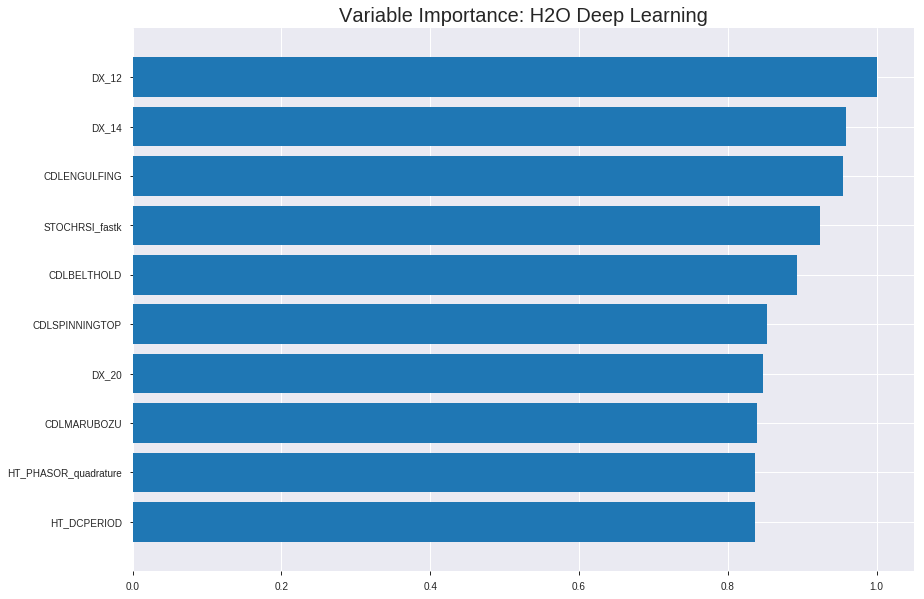

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_181752_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2434416676278675
RMSE: 0.4933980823106911
LogLoss: 0.6770011766067268
Mean Per-Class Error: 0.45838795647412345
AUC: 0.551366657495374
pr_auc: 0.5622503409802131
Gini: 0.10273331499074789
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4521199744170465: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    902   1        (902.0/902.0)
1      0    822   0        (0.0/822.0)
Total  0    1724  0.5232   (902.0/1724.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.45212      0.645719  399
max f2                       0.45212      0.820032  399
max f0point5                 0.45212      0.532521  399
max accuracy                 0.564263     0.559745  124
max precision                0.997723     1         0
max recall                   0.45212      1         399
max specificity              0.997723     1         0
max absolute_mcc             0.658785     0.171155  47
max min_per_class_accuracy   0.480563     0.529933  320
max mean_per_class_accuracy  0.564263     0.541612  124

Gains/Lift Table: Avg response rate: 47.68 %, avg score: 50.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104408                   0.956826           2.09732   2.09732            1                0.98315   1                           0.98315             0.0218978       0.0218978                  109.732   109.732
    2        0.0203016                   0.823165           2.09732   2.09732            1                0.887279  1                           0.936584            0.0206813       0.0425791                  109.732   109.732
    3        0.0301624                   0.657578           1.85058   2.01666            0.882353         0.732405  0.961538                    0.869833            0.0182482       0.0608273                  85.058    101.666
    4        0.0400232                   0.613838           1.11035   1.79336            0.529412         0.627339  0.855072                    0.810088            0.0109489       0.0717762                  11.0348   79.3364
    5        0.050464                    0.598482           1.16518   1.66339            0.555556         0.603871  0.793103                    0.767423            0.0121655       0.0839416                  16.518    66.3395
    6        0.100348                    0.566117           1.14621   1.4063             0.546512         0.578292  0.67052                     0.673404            0.0571776       0.141119                   14.6212   40.6298
    7        0.150232                    0.54993            0.804787  1.20657            0.383721         0.557787  0.57529                     0.635014            0.040146        0.181265                   -19.5213  20.6568
    8        0.200116                    0.536042           1.12182   1.18544            0.534884         0.542846  0.565217                    0.612039            0.0559611       0.237226                   12.1824   18.5444
    9        0.299884                    0.515712           0.938918  1.10343            0.447674         0.525108  0.526112                    0.583118            0.093674        0.3309                     -6.10819  10.3428
    10       0.400232                    0.497148           1.05472   1.09122            0.50289          0.505934  0.52029                     0.563766            0.105839        0.43674                    5.47234   9.12162
    11       0.5                         0.480313           0.963306  1.06569            0.459302         0.488689  0.508121                    0.548785            0.0961071       0.532847                   -3.66944  6.56934
    12       0.599768                    0.46117            0.951112  1.04663            0.453488         0.470226  0.499033                    0.535717            0.0948905       0.627737                   -4.88881  4.66334
    13       1                           0.45212            0.930117  1                  0.443478         0.453122  0.476798                    0.50266             0.372263        1                          -6.98826  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.249062813710605
RMSE: 0.4990619337423012
LogLoss: 0.6905998574086515
Mean Per-Class Error: 0.4669655263680276
AUC: 0.5199827962681135
pr_auc: 0.5514668912995678
Gini: 0.039965592536227
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4587643454964957: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    233  0.979    (233.0/238.0)
1      2    252  0.0079   (2.0/254.0)
Total  7    485  0.4776   (235.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.458764     0.682003  392
max f2                       0.455922     0.842175  399
max f0point5                 0.46224      0.575856  385
max accuracy                 0.496332     0.538618  274
max precision                0.994099     1         0
max recall                   0.455922     1         399
max specificity              0.994099     1         0
max absolute_mcc             0.603768     0.111033  21
max min_per_class_accuracy   0.515324     0.507874  208
max mean_per_class_accuracy  0.496332     0.533034  274

Gains/Lift Table: Avg response rate: 51.63 %, avg score: 52.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.779601           1.54961   1.54961            0.8              0.886579  0.8                         0.886579            0.015748        0.015748                   54.9606   54.9606
    2        0.0203252                   0.668549           1.54961   1.54961            0.8              0.714194  0.8                         0.800386            0.015748        0.0314961                  54.9606   54.9606
    3        0.0304878                   0.612881           1.1622    1.42047            0.6              0.630509  0.733333                    0.743761            0.011811        0.0433071                  16.2205   42.0472
    4        0.0406504                   0.604268           1.54961   1.45276            0.8              0.606571  0.75                        0.709463            0.015748        0.0590551                  54.9606   45.2756
    5        0.050813                    0.597755           1.1622    1.39465            0.6              0.602977  0.72                        0.688166            0.011811        0.0708661                  16.2205   39.4646
    6        0.101626                    0.578131           1.00724   1.20094            0.52             0.586277  0.62                        0.637221            0.0511811       0.122047                   0.724409  20.0945
    7        0.150407                    0.569823           0.968504  1.12556            0.5              0.574341  0.581081                    0.616828            0.0472441       0.169291                   -3.14961  12.5559
    8        0.20122                     0.560445           0.929764  1.07612            0.48             0.565533  0.555556                    0.603875            0.0472441       0.216535                   -7.02362  7.61155
    9        0.300813                    0.543143           0.751085  0.968504           0.387755         0.552161  0.5                         0.586753            0.0748031       0.291339                   -24.8915  -3.14961
    10       0.400407                    0.526819           0.988269  0.97342            0.510204         0.536162  0.502538                    0.57417             0.0984252       0.389764                   -1.17307  -2.65798
    11       0.5                         0.515176           1.18592   1.01575            0.612245         0.521486  0.52439                     0.563676            0.11811         0.507874                   18.5923   1.5748
    12       0.599593                    0.504827           1.06733   1.02432            0.55102          0.509732  0.528814                    0.554715            0.106299        0.614173                   6.73309   2.4316
    13       0.699187                    0.493622           1.06733   1.03044            0.55102          0.499392  0.531977                    0.546835            0.106299        0.720472                   6.73309   3.04431
    14       0.79878                     0.486183           0.869677  1.0104             0.44898          0.489759  0.521628                    0.539719            0.0866142       0.807087                   -13.0323  1.03985
    15       0.898374                    0.475936           0.948739  1.00356            0.489796         0.482017  0.5181                      0.533322            0.0944882       0.901575                   -5.12614  0.35629
    16       1                           0.455922           0.968504  1                  0.5              0.46606   0.51626                     0.526486         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 18:27:57  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 18:27:59  2 min  5.541 sec  490 obs/sec       0.527842  1             910        0.536088         0.784888            -0.15204       0.523664        0.503363           1.2817           0.520302                         0.541324           0.801405              -0.173366        0.504069          0.526288             1.54961            0.48374
    2019-08-24 18:28:17  2 min 24.040 sec  690 obs/sec       7.41531   14            12784      0.502436         0.69804             -0.0119454     0.51415         0.487706           1.2817           0.523202                         0.49979            0.692728              -0.000218622     0.504483          0.535074             0.774803           0.481707
    2019-08-24 18:28:36  2 min 43.102 sec  901 obs/sec       18.7001   35            32239      0.499603         0.692353            -0.000566927   0.503396        0.490413           1.2817           0.523202                         0.50026            0.693668              -0.00210194      0.482929          0.505957             0.774803           0.479675
    2019-08-24 18:28:55  3 min  1.456 sec  1019 obs/sec      30.9333   58            53329      0.503154         0.699484            -0.0148391     0.526429        0.537577           1.39822          0.523202                         0.500136           0.693427              -0.00160505      0.518742          0.545955             0.774803           0.48374
    2019-08-24 18:29:13  3 min 19.335 sec  1074 obs/sec      42.6247   80            73485      0.499041         0.691229            0.00168065     0.522629        0.532215           1.39822          0.523202                         0.499915           0.692977              -0.000719872     0.524871          0.583803             1.1622             0.48374
    2019-08-24 18:29:30  3 min 37.275 sec  1175 obs/sec      57.6224   108           99341      0.498985         0.691051            0.00190504     0.519829        0.607581           2.09732          0.523202                         0.499175           0.69147               0.00224102       0.509661          0.651673             1.93701            0.48374
    2019-08-24 18:29:49  3 min 55.667 sec  1237 obs/sec      72.5615   136           125096     0.493398         0.677001            0.024132       0.551367        0.56225            2.09732          0.523202                         0.499062           0.6906                0.00269402       0.519983          0.551467             1.54961            0.477642

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
DX_12                     1.0                    1.0                  0.0041214555964459365
DX_14                     0.9594325423240662     0.9594325423240662   0.003954258620973875
CDLENGULFING              0.9552814960479736     0.9552814960479736   0.003937150268068167
STOCHRSI_fastk            0.9242410063743591     0.9242410063743591   0.0038092182681864267
CDLBELTHOLD               0.8930993676185608     0.8930993676185608   0.003680869386853844
---                       ---                    ---                  ---
BBANDS_middleband_14_3_4  0.5070466995239258     0.5070466995239258   0.002089770457412325
BBANDS_middleband_14_3_5  0.5049542188644409     0.5049542188644409   0.002081146391287836
CDLCOUNTERATTACK          0.5010006427764893     0.5010006427764893   0.002064851902994173
MAVP_14_7                 0.5009991526603699     0.5009991526603699   0.0020648457615467532
CDLADVANCEBLOCK           0.4993433654308319     0.4993433654308319   0.0020580215080030504


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5587044534412956)

('F1', 0.6826666666666666)

('auc', 0.5495995273109243)

('logloss', 0.7052872626709238)

('mean_per_class_error', 0.4370076155462185)

('rmse', 0.5055278076366503)

('mse', 0.2555583642939181)

deeplearning prediction progress: |███████████████████████████████████████| 100%


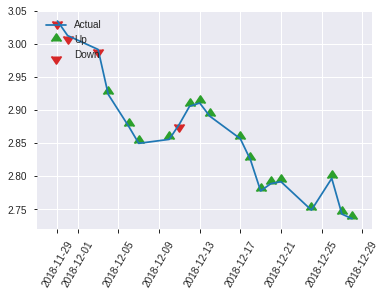


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2555583642939181
RMSE: 0.5055278076366503
LogLoss: 0.7052872626709238
Mean Per-Class Error: 0.4370076155462185
AUC: 0.5495995273109243
pr_auc: 0.5603707281930377
Gini: 0.09919905462184864
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4521198880436037: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    119  1        (119.0/119.0)
1      0    128  0        (0.0/128.0)
Total  0    247  0.4818   (119.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.45212      0.682667  105
max f2                       0.45212      0.843215  105
max f0point5                 0.45212      0.573477  105
max accuracy                 0.455039     0.558704  94
max precision                0.475316     0.676471  33
max recall                   0.45212      1         105
max specificity              0.796274     0.991597  0
max absolute_mcc             0.472778     0.134475  41
max min_per_class_accuracy   0.45248      0.460938  104
max mean_per_class_accuracy  0.455039     0.562992  94

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 46.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.690261           0         0                  0                0.760857  0                           0.760857            0               0                          -100      -100
    2        0.0202429                   0.62336            0.964844  0.385938           0.5              0.630358  0.2                         0.708658            0.0078125       0.0078125                  -3.51562  -61.4062
    3        0.0323887                   0.504196           1.28646   0.723633           0.666667         0.546019  0.375                       0.647668            0.015625        0.0234375                  28.6458   -27.6367
    4        0.0404858                   0.494942           1.92969   0.964844           1                0.49934   0.5                         0.618003            0.015625        0.0390625                  92.9688   -3.51562
    5        0.0526316                   0.490973           1.92969   1.1875             1                0.49314   0.615385                    0.589188            0.0234375       0.0625                     92.9688   18.75
    6        0.101215                    0.479408           1.28646   1.235              0.666667         0.482162  0.64                        0.537815            0.0625          0.125                      28.6458   23.5
    7        0.149798                    0.474316           1.44727   1.30384            0.75             0.476528  0.675676                    0.517938            0.0703125       0.195312                   44.7266   30.3843
    8        0.202429                    0.468845           0.890625  1.19641            0.461538         0.472212  0.62                        0.506049            0.046875        0.242188                   -10.9375  19.6406
    9        0.299595                    0.460444           0.964844  1.1213             0.5              0.464234  0.581081                    0.492488            0.09375         0.335938                   -3.51562  12.1305
    10       0.40081                     0.454426           1.08063   1.11103            0.56             0.457703  0.575758                    0.483704            0.109375        0.445312                   8.0625    11.1032
    11       1                           0.45212            0.925728  1                  0.47973          0.452179  0.518219                    0.464814            0.554688        1                          -7.42715  0

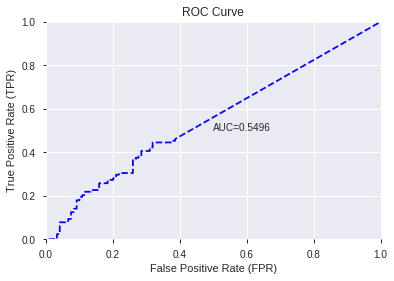

This function is available for GLM models only


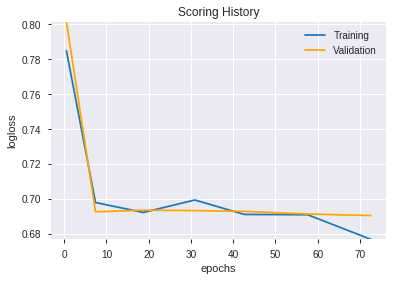

--2019-08-24 18:33:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.168.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.168.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_181752_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_181752_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_8441',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['DX_12',
 'DX_14',
 'CDLENGULFING',
 'STOCHRSI_fastk',
 'CDLBELTHOLD',
 'CDLSPINNINGTOP',
 'DX_20',
 'CDLMARUBOZU',
 'HT_PHASOR_quadrature',
 'HT_DCPERIOD',
 'AROONOSC_24',
 'STOCHF_fastk',
 'aroonup_20',
 'CORREL_12',
 'aroondown_20',
 'ADX_12',
 'STOCH_slowd',
 'CORREL_20',
 'aroonup_12',
 'LINEARREG_SLOPE_8',
 'BETA_8',
 'DX_24',
 'MINUS_DM_8',
 'LINEARREG_ANGLE_8',
 'CDLLONGLEGGEDDOJI',
 'PLUS_DI_14',
 'HT_TRENDMODE',
 'ADX_24',
 'MACDEXT_hist',
 'STDDEV_12',
 'STOCH_slowk',
 'aroondown_24',
 'PLUS_DI_8',
 'ADXR_14',
 'ADX_14',
 'DX_30',
 'CORREL_8',
 'aroonup_24',
 'STDDEV_8',
 'CORREL_14',
 'aroondown_12',
 'STOCHRSI_fastd',
 'PLUS_DI_12',
 'PLUS_DM_8',
 'MACDFIX_hist_8',
 'aroondown_14',
 'BETA_12',
 'CDLDOJI',
 'aroonup_30',
 'CDLHAMMER',
 'BETA_20',
 'AROONOSC_12',
 'MINUS_DI_12',
 'PLUS_DI_20',
 'TRANGE',
 'CCI_12',
 'AROONOSC_20',
 'AROONOSC_14',
 'STDDEV_14',
 'ROCP_8',
 'ROCR_8',
 'MOM_30',
 'ULTOSC',
 'WILLR_8',
 'aroonup_14',
 'AROONOSC_30',
 'MOM_8',
 'VAR_14',
 'VAR_8

In [57]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id     auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_183309_model_1  0.5151  0.70019                   0.5  0.503427  0.253438

variable  relative_importance  scaled_importance  percentage
0                CDLTHRUSTING             0.045841           1.000000    0.031908
1                  aroonup_12             0.037512           0.818294    0.026110
2              CDLEVENINGSTAR             0.027546           0.600908    0.019174
3           CDLGRAVESTONEDOJI             0.026768           0.583915    0.018632
4            CDLCOUNTERATTACK             0.026277           0.573219    0.018290
..                        ...                  ...                ...         ...
388                    EMA_14             0.000011           0.000248    0.000008
389                    WMA_20             0.000008           0.000168    0.000005
390  BBANDS_middleband_20_5_5             0.000007           0.000155    0.000005
391  BBANDS_middleband_20_5_4             0.000005           0.000102    0.000003
392   BBANDS_lowerband_12_6_5             0.000004           0.000086    0.000003

[393 rows x 4 columns]

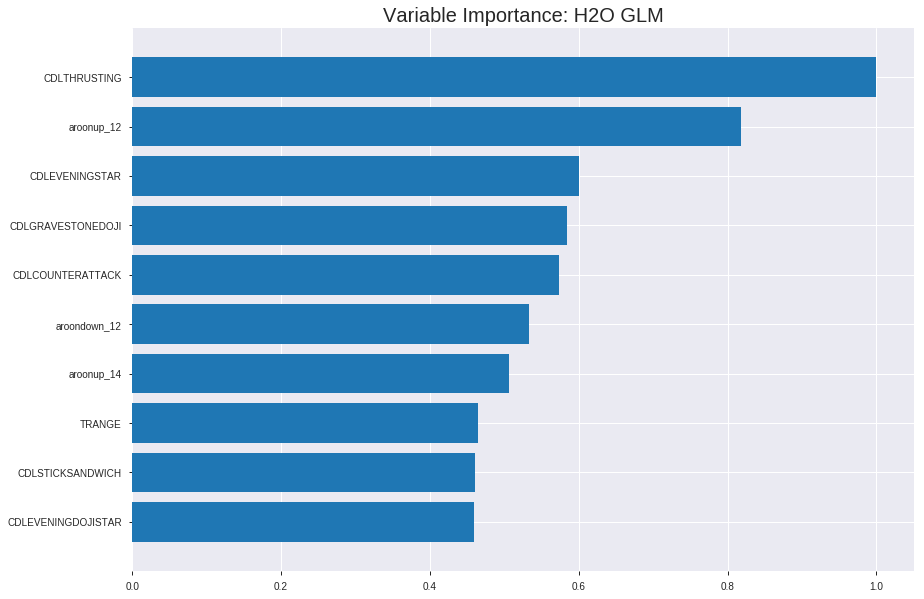

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_183309_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2432019992611685
RMSE: 0.4931551472520271
LogLoss: 0.6793748306964784
Null degrees of freedom: 1723
Residual degrees of freedom: 1330
Null deviance: 2386.25784815377
Residual deviance: 2342.484416241457
AIC: 3130.484416241457
AUC: 0.5987094102858745
pr_auc: 0.5712524543407862
Gini: 0.1974188205717491
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40705108453994837: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      57   845   0.9368   (845.0/902.0)
1      10   812   0.0122   (10.0/822.0)
Total  67   1657  0.4959   (855.0/1724.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.407051     0.655103  356
max f2                       0.367303     0.822988  383
max f0point5                 0.463144     0.554574  240
max accuracy                 0.498725     0.581206  147
max precision                0.676024     1         0
max recall                   0.367303     1         383
max specificity              0.676024     1         0
max absolute_mcc             0.509815     0.159985  118
max min_per_class_accuracy   0.476325     0.568736  206
max mean_per_class_accuracy  0.49709      0.571779  151

Gains/Lift Table: Avg response rate: 47.68 %, avg score: 47.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104408                   0.591026           1.39822   1.39822            0.666667         0.619303  0.666667                    0.619303            0.0145985       0.0145985                  39.8216   39.8216
    2        0.0203016                   0.573198           1.35709   1.37824            0.647059         0.581606  0.657143                    0.600993            0.013382        0.0279805                  35.7092   37.8241
    3        0.0301624                   0.564195           1.35709   1.37133            0.647059         0.568359  0.653846                    0.590324            0.013382        0.0413625                  35.7092   37.1327
    4        0.0400232                   0.560168           1.48046   1.39822            0.705882         0.562106  0.666667                    0.583372            0.0145985       0.0559611                  48.0464   39.8216
    5        0.050464                    0.550307           1.86429   1.49464            0.888889         0.554505  0.712644                    0.577399            0.0194647       0.0754258                  86.4288   49.4644
    6        0.100348                    0.531427           1.19499   1.34568            0.569767         0.539544  0.641618                    0.558581            0.0596107       0.135036                   19.4987   34.5682
    7        0.150232                    0.518091           1.41447   1.36852            0.674419         0.524184  0.65251                     0.54716             0.0705596       0.205596                   41.4474   36.8524
    8        0.200116                    0.509308           1.19499   1.32527            0.569767         0.513461  0.631884                    0.538759            0.0596107       0.265207                   19.4987   32.5265
    9        0.299884                    0.495901           1.07305   1.24136            0.511628         0.50199   0.591876                    0.526527            0.107056        0.372263                   7.30493   24.1356
    10       0.400232                    0.485966           0.957737  1.17025            0.456647         0.490941  0.557971                    0.517604            0.0961071       0.46837                    -4.22626  17.0246
    11       0.5                         0.476012           1.03647   1.14355            0.494186         0.48079   0.545244                    0.510259            0.103406        0.571776                   3.64681   14.3552
    12       0.599768                    0.465444           0.938918  1.10951            0.447674         0.470442  0.529014                    0.503635            0.093674        0.66545                    -6.10819  10.9513
    13       0.700116                    0.45508            0.884998  1.07733            0.421965         0.459877  0.51367                     0.497363            0.0888078       0.754258                   -11.5002  7.73328
    14       0.799884                    0.44263            0.914531  1.05703            0.436047         0.448907  0.503988                    0.49132             0.0912409       0.845499                   -8.54694  5.70268
    15       0.899652                    0.426335           0.841368  1.03311            0.401163         0.435282  0.492585                    0.485105            0.0839416       0.92944                    -15.8632  3.3111
    16       1                           0.258367           0.703149  1                  0.33526          0.402323  0.476798                    0.476798          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2512886058149656
RMSE: 0.501286949575755
LogLoss: 0.6958116912065054
Null degrees of freedom: 491
Residual degrees of freedom: 98
Null deviance: 684.603379765711
Residual deviance: 684.6787041472013
AIC: 1472.6787041472012
AUC: 0.5325795672599749
pr_auc: 0.5425287625277998
Gini: 0.06515913451994981
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30932210163109186: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    236  0.9916   (236.0/238.0)
1      0    254  0        (0.0/254.0)
Total  2    490  0.4797   (236.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.309322     0.682796   397
max f2                       0.309322     0.843293   397
max f0point5                 0.431508     0.579673   336
max accuracy                 0.452646     0.544715   270
max precision                0.628649     1          0
max recall                   0.309322     1          397
max specificity              0.628649     1          0
max absolute_mcc             0.437286     0.0852523  324
max min_per_class_accuracy   0.467812     0.511811   207
max mean_per_class_accuracy  0.458192     0.539486   245

Gains/Lift Table: Avg response rate: 51.63 %, avg score: 47.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.596356           1.1622    1.1622             0.6              0.606507  0.6                         0.606507            0.011811        0.011811                   16.2205   16.2205
    2        0.0203252                   0.588029           1.54961   1.35591            0.8              0.591338  0.7                         0.598923            0.015748        0.0275591                  54.9606   35.5906
    3        0.0304878                   0.571253           1.1622    1.29134            0.6              0.581677  0.666667                    0.593174            0.011811        0.0393701                  16.2205   29.1339
    4        0.0406504                   0.560606           0.774803  1.1622             0.4              0.565074  0.6                         0.586149            0.00787402      0.0472441                  -22.5197  16.2205
    5        0.050813                    0.556662           0.774803  1.08472            0.4              0.559594  0.56                        0.580838            0.00787402      0.0551181                  -22.5197  8.47244
    6        0.101626                    0.526545           1.08472   1.08472            0.56             0.539219  0.56                        0.560028            0.0551181       0.110236                   8.47244   8.47244
    7        0.150407                    0.511628           1.12992   1.09938            0.583333         0.518164  0.567568                    0.546451            0.0551181       0.165354                   12.9921   9.93828
    8        0.20122                     0.502945           1.08472   1.09568            0.56             0.507678  0.565657                    0.53666             0.0551181       0.220472                   8.47244   9.56812
    9        0.300813                    0.488322           0.909208  1.03394            0.469388         0.494245  0.533784                    0.522617            0.0905512       0.311024                   -9.07922  3.39434
    10       0.400407                    0.477474           0.988269  1.02258            0.510204         0.482555  0.527919                    0.512652            0.0984252       0.409449                   -1.17307  2.25828
    11       0.5                         0.467742           1.0278    1.02362            0.530612         0.473263  0.528455                    0.504807            0.102362        0.511811                   2.78001   2.3622
    12       0.599593                    0.458144           1.26498   1.06371            0.653061         0.463017  0.549153                    0.497865            0.125984        0.637795                   26.4985   6.37128
    13       0.699187                    0.45121            0.948739  1.04734            0.489796         0.454762  0.540698                    0.491726            0.0944882       0.732283                   -5.12614  4.73357
    14       0.79878                     0.441787           0.909208  1.03011            0.469388         0.446575  0.531807                    0.486096            0.0905512       0.822835                   -9.07922  3.01136
    15       0.898374                    0.427773           0.948739  1.02109            0.489796         0.43456   0.527149                    0.480383            0.0944882       0.917323                   -5.12614  2.10924
    16       1                           0.298604           0.813543  1                  0.42             0.389403  0.51626                     0.471137          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 18:33:10  0.000 sec   2            3.4       394           1.37528           1.39225
    2019-08-24 18:33:10  0.280 sec   4            2.5       394           1.37352           1.39236
    2019-08-24 18:33:10  0.557 sec   6            1.8       394           1.37138           1.39233
    2019-08-24 18:33:11  0.846 sec   8            1.3       394           1.36883           1.39217
    2019-08-24 18:33:11  1.128 sec   10           0.95      394           1.36586           1.39195
    2019-08-24 18:33:11  1.404 sec   12           0.69      394           1.36248           1.39172
    2019-08-24 18:33:12  1.852 sec   14           0.5       394           1.35875           1.39162
    2019-08-24 18:33:12  2.134 sec   16           0.37      394           1.35475           1.39173
    2019-08-24 18:33:12  2.442 sec   18           0.27      394           1.35056           1.39219
    2019-08-24 18:33:12  2.735 sec   20           0.19      394           1.3463            1.3931
    2019-08-24 18:33:13  3.019 sec   22           0.14      394           1.34202           1.39461
    2019-08-24 18:33:13  3.304 sec   24           0.1       394           1.33782           1.39679

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5506072874493927)

('F1', 0.6826666666666666)

('auc', 0.5150997899159664)

('logloss', 0.7001898686972537)

('mean_per_class_error', 0.4625459558823529)

('rmse', 0.5034266721741809)

('mse', 0.2534384142563702)

glm prediction progress: |████████████████████████████████████████████████| 100%


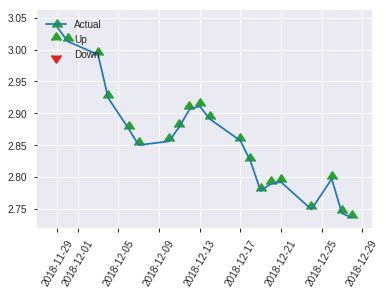


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2534384142563702
RMSE: 0.5034266721741809
LogLoss: 0.7001898686972537
Null degrees of freedom: 246
Residual degrees of freedom: -147
Null deviance: 343.7830139951905
Residual deviance: 345.8937951364434
AIC: 1133.8937951364433
AUC: 0.5150997899159664
pr_auc: 0.5341777732506302
Gini: 0.030199579831932777
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30012177116263133: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    119  1        (119.0/119.0)
1      0    128  0        (0.0/128.0)
Total  0    247  0.4818   (119.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.300122     0.682667  246
max f2                       0.300122     0.843215  246
max f0point5                 0.428855     0.586735  212
max accuracy                 0.428855     0.550607  212
max precision                0.628512     1         0
max recall                   0.300122     1         246
max specificity              0.628512     1         0
max absolute_mcc             0.406415     0.130637  238
max min_per_class_accuracy   0.45581      0.492188  121
max mean_per_class_accuracy  0.428855     0.537454  212

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 45.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.546279           1.28646   1.28646            0.666667         0.584164  0.666667                    0.584164            0.015625        0.015625                   28.6458   28.6458
    2        0.0202429                   0.53761            0.964844  1.15781            0.5              0.541003  0.6                         0.566899            0.0078125       0.0234375                  -3.51562  15.7812
    3        0.0323887                   0.526417           0.643229  0.964844           0.333333         0.531934  0.5                         0.553787            0.0078125       0.03125                    -35.6771  -3.51562
    4        0.0404858                   0.524753           1.92969   1.15781            1                0.52561   0.6                         0.548152            0.015625        0.046875                   92.9688   15.7812
    5        0.0526316                   0.51558            1.28646   1.1875             0.666667         0.519435  0.615385                    0.541525            0.015625        0.0625                     28.6458   18.75
    6        0.101215                    0.505683           0.964844  1.08063            0.5              0.51144   0.56                        0.527084            0.046875        0.109375                   -3.51562  8.0625
    7        0.149798                    0.494851           1.12565   1.09523            0.583333         0.500737  0.567568                    0.518539            0.0546875       0.164062                   12.5651   9.5228
    8        0.202429                    0.486624           0.890625  1.04203            0.461538         0.489987  0.54                        0.511116            0.046875        0.210938                   -10.9375  4.20312
    9        0.299595                    0.470432           0.88444   0.990921           0.458333         0.476789  0.513514                    0.499983            0.0859375       0.296875                   -11.556   -0.907939
    10       0.40081                     0.4635             1.00344   0.994081           0.52             0.467139  0.515152                    0.491689            0.101562        0.398438                   0.34375   -0.591856
    11       0.502024                    0.454685           0.92625   0.980406           0.48             0.459752  0.508065                    0.48525             0.09375         0.492188                   -7.375    -1.95943
    12       0.59919                     0.44775            1.20605   1.017              0.625            0.450805  0.527027                    0.479664            0.117188        0.609375                   20.6055   1.69975
    13       0.700405                    0.440816           1.15781   1.03735            0.6              0.444704  0.537572                    0.474612            0.117188        0.726562                   15.7812   3.73465
    14       0.797571                    0.433318           0.964844  1.02851            0.5              0.436975  0.532995                    0.470027            0.09375         0.820312                   -3.51562  2.85136
    15       0.898785                    0.421486           0.92625   1.017              0.48             0.428354  0.527027                    0.465334            0.09375         0.914062                   -7.375    1.69975
    16       1                           0.300122           0.849062  1                  0.44             0.404019  0.518219                    0.459128       

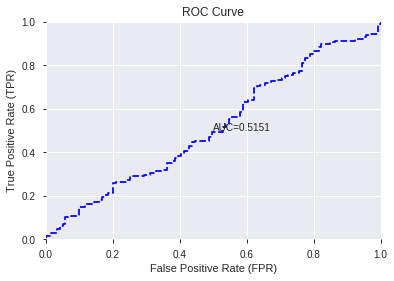

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


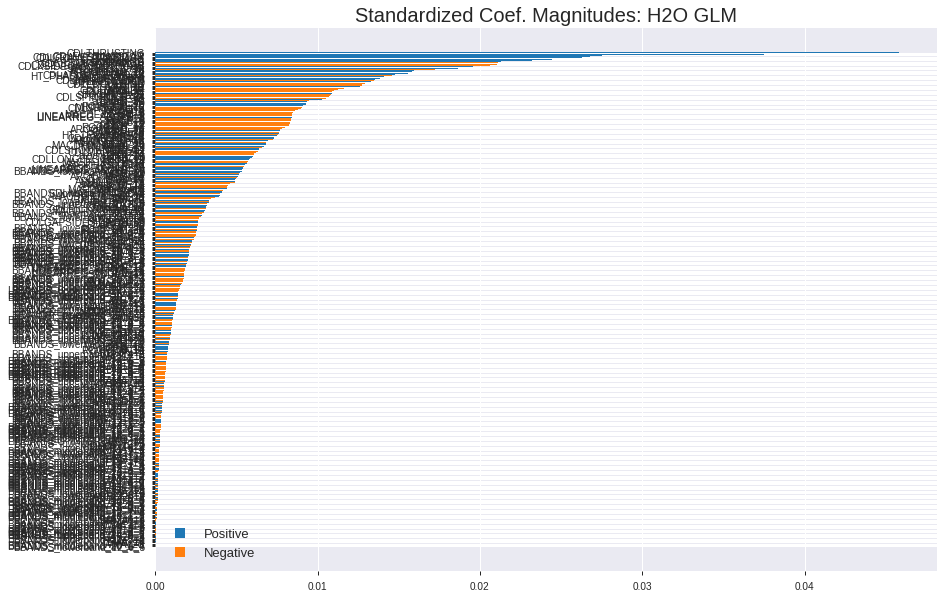

'log_likelihood'
--2019-08-24 18:33:22--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.207.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.207.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_183309_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_183309_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_8441',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CDLTHRUSTING',
 'aroonup_12',
 'CDLEVENINGSTAR',
 'CDLGRAVESTONEDOJI',
 'CDLCOUNTERATTACK',
 'aroondown_12',
 'aroonup_14',
 'TRANGE',
 'CDLSTICKSANDWICH',
 'CDLEVENINGDOJISTAR',
 'CDLXSIDEGAP3METHODS',
 'STOCHRSI_fastk',
 'AROONOSC_20',
 'aroondown_20',
 'AROONOSC_14',
 'aroonup_20',
 'DX_12',
 'CDLADVANCEBLOCK',
 'HT_PHASOR_quadrature',
 'MACDEXT_hist',
 'MINUS_DM_8',
 'CDLHANGINGMAN',
 'CDLBELTHOLD',
 'HT_DCPERIOD',
 'CDLENGULFING',
 'VAR_12',
 'VAR_20',
 'DX_14',
 'MOM_24',
 'CDLHAMMER',
 'CDL3INSIDE',
 'ROCR100_24',
 'STOCHF_fastk',
 'ROCR_24',
 'ROCP_24',
 'CDLSPINNINGTOP',
 'VAR_14',
 'CCI_20',
 'aroonup_30',
 'ROCP_20',
 'ROCR_20',
 'ROCR100_20',
 'MINUS_DM_12',
 'CDLSHORTLINE',
 'WILLR_8',
 'MOM_12',
 'RSI_8',
 'MOM_8',
 'MACDEXT_signal',
 'LINEARREG_ANGLE_8',
 'LINEARREG_SLOPE_8',
 'ADX_12',
 'ROCR_8',
 'ROCP_8',
 'ROC_8',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'AROONOSC_30',
 'CMO_12',
 'STDDEV_20',
 'CORREL_8',
 'WILLR_30',
 'HT_TRENDMODE',
 'RSI_12',
 'STDDEV

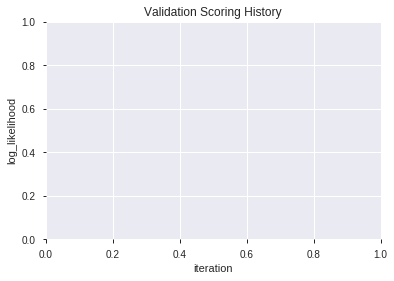

In [58]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_183326_model_3  0.535255  0.704412              0.495503  0.505429  0.255459
1  XGBoost_grid_1_AutoML_20190824_183326_model_2  0.518908  0.711333              0.500000  0.508702  0.258777
2  XGBoost_grid_1_AutoML_20190824_183326_model_7  0.512080  0.711547              0.495798  0.508669  0.258744
3  XGBoost_grid_1_AutoML_20190824_183326_model_6  0.511949  0.704789              0.487395  0.505675  0.255707
4  XGBoost_grid_1_AutoML_20190824_183326_model_5  0.493697  0.754332              0.495798  0.527172  0.277911
5               XGBoost_2_AutoML_20190824_183326  0.489693  0.722084              0.500000  0.513565  0.263749
6  XGBoost_grid_1_AutoML_20190824_183326_model_4  0.488905  0.713790              0.500000  0.509970  0.260070
7  XGBoost_grid_1_AutoML_20190824_183326_model_1  0.488478  0.717689              0.491597  0.511699  0.261835
8               XGBoost_3_AutoML_20190824_183326  0.473149  0.723690              0.482898  0.514659  0.264874
9               XGBoost_1_AutoML_20190824_183326  0.464877  0.734225              0.500000  0.518929  0.269287

variable  relative_importance  scaled_importance  percentage
0             STOCHRSI_fastd            84.800575           1.000000    0.018033
1                    BETA_20            77.635406           0.915506    0.016509
2                AROONOSC_20            74.749779           0.881477    0.015896
3               MACDEXT_hist            71.067314           0.838052    0.015113
4                     BETA_8            70.469994           0.831008    0.014986
..                       ...                  ...                ...         ...
217  BBANDS_upperband_12_6_4             2.796865           0.032982    0.000595
218  BBANDS_lowerband_20_0_5             2.251060           0.026545    0.000479
219  BBANDS_upperband_20_6_5             2.096169           0.024719    0.000446
220                  ROCR_30             2.093459           0.024687    0.000445
221         MACDFIX_signal_8             1.833050           0.021616    0.000390

[222 rows x 4 columns]

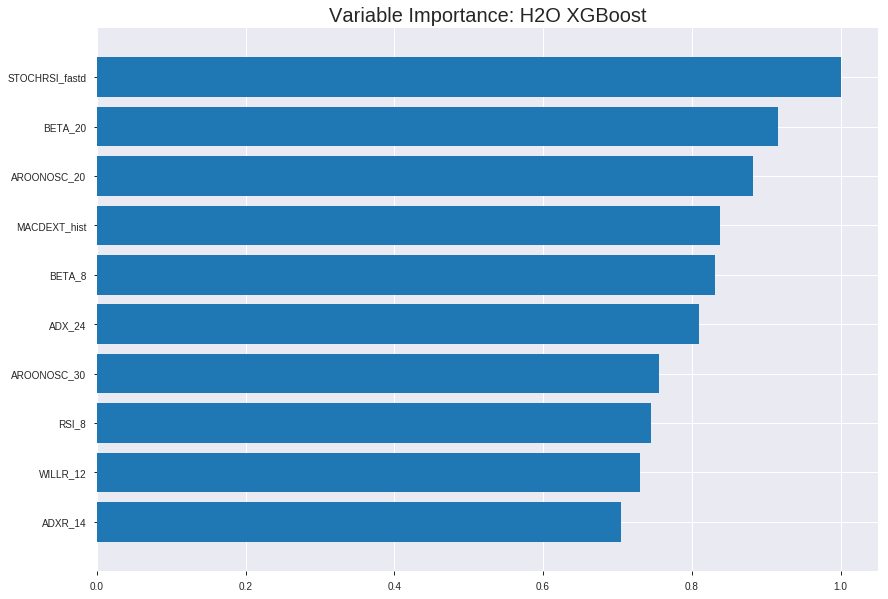

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_183326_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19073651888408824
RMSE: 0.4367339222960454
LogLoss: 0.571567289318449
Mean Per-Class Error: 0.15741175328143453
AUC: 0.9150232519246227
pr_auc: 0.9088488810948818
Gini: 0.8300465038492455
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.475599966943264: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      753  149  0.1652   (149.0/902.0)
1      123  699  0.1496   (123.0/822.0)
Total  876  848  0.1578   (272.0/1724.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.4756       0.837126  211
max f2                       0.417644     0.88783   274
max f0point5                 0.502105     0.846154  183
max accuracy                 0.476501     0.842227  210
max precision                0.820896     1         0
max recall                   0.319858     1         370
max specificity              0.820896     1         0
max absolute_mcc             0.4756       0.684529  211
max min_per_class_accuracy   0.478267     0.839246  208
max mean_per_class_accuracy  0.4756       0.842588  211

Gains/Lift Table: Avg response rate: 47.68 %, avg score: 48.00 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0104408                   0.731044           2.09732    2.09732            1                0.75797   1                           0.75797             0.0218978       0.0218978                  109.732   109.732
    2        0.0203016                   0.695394           2.09732    2.09732            1                0.710221  1                           0.734778            0.0206813       0.0425791                  109.732   109.732
    3        0.0301624                   0.677975           2.09732    2.09732            1                0.686759  1                           0.719079            0.0206813       0.0632603                  109.732   109.732
    4        0.0400232                   0.664858           2.09732    2.09732            1                0.672587  1                           0.707624            0.0206813       0.0839416                  109.732   109.732
    5        0.050464                    0.653166           2.09732    2.09732            1                0.658368  1                           0.697433            0.0218978       0.105839                   109.732   109.732
    6        0.100348                    0.614997           2.09732    2.09732            1                0.631964  1                           0.664888            0.104623        0.210462                   109.732   109.732
    7        0.150232                    0.589287           1.92661    2.04064            0.918605         0.601969  0.972973                    0.643996            0.0961071       0.306569                   92.6611   104.064
    8        0.200116                    0.5659             1.85345    1.99398            0.883721         0.577895  0.950725                    0.627518            0.0924574       0.399027                   85.3449   99.3977
    9        0.299884                    0.530476           1.81687    1.93505            0.866279         0.548627  0.922631                    0.601272            0.181265        0.580292                   81.6868   93.5055
    10       0.400232                    0.498758           1.53965    1.83592            0.734104         0.513917  0.875362                    0.57937             0.154501        0.734793                   53.9654   83.5918
    11       0.5                         0.472227           1.20718    1.71046            0.575581         0.485945  0.815545                    0.560728            0.120438        0.855231                   20.718    71.0462
    12       0.599768                    0.443193           0.646268   1.53344            0.30814          0.457315  0.731141                    0.543526            0.0644769       0.919708                   -35.3732  53.344
    13       0.700116                    0.419534           0.497054   1.38489            0.236994         0.431249  0.660315                    0.527433            0.0498783       0.969586                   -50.2946  38.4894
    14       0.799884                    0.392685           0.182906   1.23497            0.0872093        0.406513  0.588832                    0.512351            0.0182482       0.987835                   -81.7094  23.4972
    15       0.899652                    0.357171           0.0853562  1.10748            0.0406977        0.376678  0.528046                    0.497306            0.00851582      0.99635                    -91.4644  10.7484
    16       1                           0.213639           0.0363698  1                  0.017341         0.325343  0.476798                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2527019138524095
RMSE: 0.50269465269924
LogLoss: 0.6996503425292103
Mean Per-Class Error: 0.4571230066829881
AUC: 0.5413633957520017
pr_auc: 0.555833772425713
Gini: 0.0827267915040033
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19629189372062683: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    238  1        (238.0/238.0)
1      0    254  0        (0.0/254.0)
Total  0    492  0.4837   (238.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.196292     0.680965  399
max f2                       0.196292     0.842175  399
max f0point5                 0.378815     0.576546  356
max accuracy                 0.500144     0.536585  168
max precision                0.740601     1         0
max recall                   0.196292     1         399
max specificity              0.740601     1         0
max absolute_mcc             0.609172     0.129037  47
max min_per_class_accuracy   0.470858     0.533613  211
max mean_per_class_accuracy  0.569933     0.542877  79

Gains/Lift Table: Avg response rate: 51.63 %, avg score: 48.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.715444           1.1622    1.1622             0.6              0.728632  0.6                         0.728632            0.011811        0.011811                   16.2205   16.2205
    2        0.0203252                   0.674083           0.774803  0.968504           0.4              0.692045  0.5                         0.710339            0.00787402      0.019685                   -22.5197  -3.14961
    3        0.0304878                   0.658081           0.774803  0.903937           0.4              0.667215  0.466667                    0.695964            0.00787402      0.0275591                  -22.5197  -9.6063
    4        0.0406504                   0.649588           1.54961   1.06535            0.8              0.654378  0.55                        0.685568            0.015748        0.0433071                  54.9606   6.53543
    5        0.050813                    0.639515           1.1622    1.08472            0.6              0.64473   0.56                        0.6774              0.011811        0.0551181                  16.2205   8.47244
    6        0.101626                    0.6099             1.62709   1.35591            0.84             0.620014  0.7                         0.648707            0.0826772       0.137795                   62.7087   35.5906
    7        0.150407                    0.584947           1.04921   1.25644            0.541667         0.597037  0.648649                    0.631949            0.0511811       0.188976                   4.92126   25.6438
    8        0.20122                     0.557547           0.929764  1.17394            0.48             0.572293  0.606061                    0.616885            0.0472441       0.23622                    -7.02362  17.3944
    9        0.300813                    0.517797           0.988269  1.11247            0.510204         0.536312  0.574324                    0.590208            0.0984252       0.334646                   -1.17307  11.2471
    10       0.400407                    0.498774           0.988269  1.08158            0.510204         0.507453  0.558376                    0.569624            0.0984252       0.433071                   -1.17307  8.1578
    11       0.5                         0.470858           0.988269  1.06299            0.510204         0.481765  0.54878                     0.552124            0.0984252       0.531496                   -1.17307  6.29921
    12       0.599593                    0.45687            0.830146  1.02432            0.428571         0.464129  0.528814                    0.537508            0.0826772       0.614173                   -16.9854  2.4316
    13       0.699187                    0.43202            0.948739  1.01355            0.489796         0.443563  0.523256                    0.524126            0.0944882       0.708661                   -5.12614  1.35506
    14       0.79878                     0.411544           1.10686   1.02518            0.571429         0.422444  0.529262                    0.511448            0.110236        0.818898                   10.6862   2.51848
    15       0.898374                    0.382354           0.948739  1.01671            0.489796         0.397503  0.524887                    0.498816            0.0944882       0.913386                   -5.12614  1.671
    16       1                           0.196292           0.852283  1                  0.44             0.33494   0.51626                     0.482162            


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 18:33:36  2.321 sec   0                  0.5              0.693147            0.5             0                  1                0.523202                         0.5                0.693147              0.5               0                    1                  0.48374
    2019-08-24 18:33:36  2.548 sec   5                  0.491556         0.676357            0.711385        0.699931           2.09732          0.386311                         0.501124           0.69542               0.498023          0.518483             1.1622             0.48374
    2019-08-24 18:33:36  2.660 sec   10                 0.484078         0.661647            0.770038        0.756662           2.09732          0.317285                         0.50191            0.697043              0.506195          0.516929             1.1622             0.48374
    2019-08-24 18:33:37  2.769 sec   15                 0.478055         0.649895            0.798669        0.790174           2.09732          0.289443                         0.501875           0.696995              0.520793          0.527757             0.774803           0.48374
    2019-08-24 18:33:37  2.889 sec   20                 0.469823         0.633979            0.833639        0.830399           2.09732          0.256961                         0.500742           0.694738              0.528676          0.541834             0.774803           0.48374
    2019-08-24 18:33:37  3.012 sec   25                 0.463105         0.621143            0.85868         0.850748           2.09732          0.236079                         0.501469           0.696253              0.527733          0.545492             1.54961            0.48374
    2019-08-24 18:33:37  3.136 sec   30                 0.457792         0.611052            0.871779        0.863491           2.09732          0.212877                         0.501741           0.69692               0.53401           0.546158             0.774803           0.48374
    2019-08-24 18:33:37  3.274 sec   35                 0.451729         0.59963             0.887842        0.879335           2.09732          0.202436                         0.502547           0.698806              0.533341          0.547685             1.1622             0.48374
    2019-08-24 18:33:37  3.411 sec   40                 0.447596         0.591845            0.897363        0.890861           2.09732          0.190255                         0.503025           0.700003              0.531819          0.548866             1.1622             0.48374
    2019-08-24 18:33:37  3.559 sec   45                 0.441538         0.580464            0.905459        0.897466           2.09732          0.183295                         0.502738           0.699594              0.539048          0.553124             0.774803           0.48374
    2019-08-24 18:33:38  3.694 sec   50                 0.436734         0.571567            0.915023        0.908849           2.09732          0.157773                         0.502695           0.69965               0.541363          0.555834             1.1622             0.48374

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
STOCHRSI_fastd           84.80057525634766      1.0                   0.018033021845171762
BETA_20                  77.63540649414062      0.9155056585341891    0.016509333539725394
AROONOSC_20              74.7497787475586       0.8814772602850154    0.01589569869074184
MACDEXT_hist             71.06731414794922      0.8380522647767009    0.015112614798113919
BETA_8                   70.4699935913086       0.8310084380711042    0.01498559331725829
---                      ---                    ---                   ---
BBANDS_upperband_12_6_4  2.796865463256836      0.032981680310564636  0.0005947593615308835
BBANDS_lowerband_20_0_5  2.2510604858398438     0.02654534452195645   0.0004786927776520512
BBANDS_upperband_20_6_5  2.0961694717407227     0.02471881193499116   0.0004457548756103881
ROCR_30                  2.093459367752075      0.02468685337833686   0.00044517856626010094
MACDFIX_signal_8         1.8330497741699219     0.021616006361144476  0.0003898019149158901


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5708502024291497)

('F1', 0.6827956989247311)

('auc', 0.5352547268907563)

('logloss', 0.7044123292476414)

('mean_per_class_error', 0.44065126050420167)

('rmse', 0.5054291716739981)

('mse', 0.2554586475790639)

xgboost prediction progress: |████████████████████████████████████████████| 100%


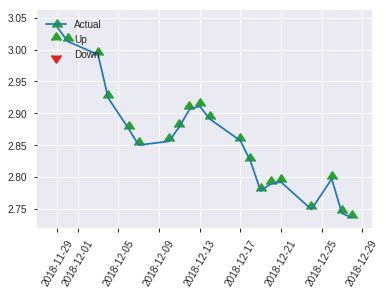


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2554586475790639
RMSE: 0.5054291716739981
LogLoss: 0.7044123292476414
Mean Per-Class Error: 0.44065126050420167
AUC: 0.5352547268907563
pr_auc: 0.5264412451205093
Gini: 0.07050945378151252
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34751471877098083: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    117  0.9832   (117.0/119.0)
1      1    127  0.0078   (1.0/128.0)
Total  3    244  0.4777   (118.0/247.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.347515     0.682796  243
max f2                       0.295495     0.843215  246
max f0point5                 0.395721     0.598291  201
max accuracy                 0.395721     0.57085   201
max precision                0.50141      0.581818  54
max recall                   0.295495     1         246
max specificity              0.669503     0.991597  0
max absolute_mcc             0.395721     0.153652  201
max min_per_class_accuracy   0.442802     0.523438  122
max mean_per_class_accuracy  0.395721     0.559349  201

Gains/Lift Table: Avg response rate: 51.82 %, avg score: 45.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121457                   0.631813           0.643229  0.643229           0.333333         0.652149  0.333333                    0.652149            0.0078125       0.0078125                  -35.6771  -35.6771
    2        0.0202429                   0.597469           0.964844  0.771875           0.5              0.613515  0.4                         0.636695            0.0078125       0.015625                   -3.51562  -22.8125
    3        0.0323887                   0.591052           1.28646   0.964844           0.666667         0.595192  0.5                         0.621132            0.015625        0.03125                    28.6458   -3.51562
    4        0.0404858                   0.580492           0.964844  0.964844           0.5              0.58372   0.5                         0.613649            0.0078125       0.0390625                  -3.51562  -3.51562
    5        0.0526316                   0.576902           0         0.742188           0                0.579085  0.384615                    0.605673            0               0.0390625                  -100      -25.7812
    6        0.101215                    0.550562           1.12565   0.92625            0.583333         0.566447  0.48                        0.586845            0.0546875       0.09375                    12.5651   -7.375
    7        0.149798                    0.532265           0.964844  0.938767           0.5              0.540486  0.486486                    0.571809            0.046875        0.140625                   -3.51562  -6.12331
    8        0.202429                    0.510726           1.48438   1.08063            0.769231         0.520536  0.56                        0.558478            0.078125        0.21875                    48.4375   8.0625
    9        0.299595                    0.480138           0.88444   1.017              0.458333         0.492576  0.527027                    0.537105            0.0859375       0.304688                   -11.556   1.69975
    10       0.40081                     0.465791           1.15781   1.05256            0.6              0.472435  0.545455                    0.520774            0.117188        0.421875                   15.7812   5.25568
    11       0.502024                    0.442344           1.00344   1.04265            0.52             0.454328  0.540323                    0.507378            0.101562        0.523438                   0.34375   4.26537
    12       0.59919                     0.422417           0.964844  1.03004            0.5              0.432178  0.533784                    0.495183            0.09375         0.617188                   -3.51562  3.00359
    13       0.700405                    0.413402           1.08063   1.03735            0.56             0.417674  0.537572                    0.483982            0.109375        0.726562                   8.0625    3.73465
    14       0.797571                    0.397905           1.28646   1.0677             0.666667         0.405728  0.553299                    0.474449            0.125           0.851562                   28.6458   6.76951
    15       0.898785                    0.374559           0.694688  1.02569            0.36             0.388053  0.531532                    0.46472             0.0703125       0.921875                   -30.5312  2.56898
    16       1                           0.295495           0.771875  1                  0.4              0.354732  0.518219                    0.453587     

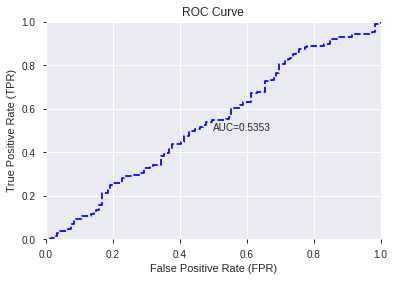

This function is available for GLM models only


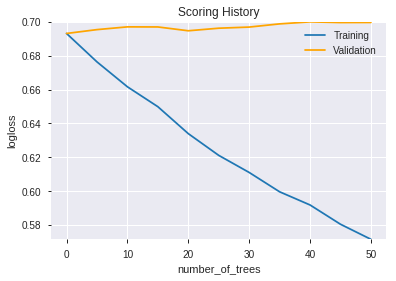

--2019-08-24 18:33:49--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.160.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.160.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_183326_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_183326_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_8441',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['STOCHRSI_fastd',
 'BETA_20',
 'AROONOSC_20',
 'MACDEXT_hist',
 'BETA_8',
 'ADX_24',
 'AROONOSC_30',
 'RSI_8',
 'WILLR_12',
 'ADXR_14',
 'MINUS_DM_24',
 'DX_30',
 'BETA_12',
 'LINEARREG_ANGLE_8',
 'STOCH_slowd',
 'WILLR_30',
 'DX_24',
 'HT_DCPERIOD',
 'DX_12',
 'PLUS_DI_8',
 'MINUS_DM_8',
 'MACD_hist',
 'STOCHF_fastk',
 'STDDEV_8',
 'aroonup_12',
 'PLUS_DM_8',
 'MOM_24',
 'BETA_14',
 'HT_PHASOR_inphase',
 'AROONOSC_14',
 'aroondown_12',
 'CORREL_20',
 'WILLR_8',
 'CCI_14',
 'CORREL_14',
 'ROCP_12',
 'ULTOSC',
 'NATR_14',
 'CCI_20',
 'PLUS_DM_30',
 'MACDFIX_signal_14',
 'CCI_8',
 'ROCR_20',
 'DX_20',
 'LINEARREG_SLOPE_14',
 'PPO',
 'DX_14',
 'PLUS_DM_14',
 'ATR_12',
 'MACDEXT_signal',
 'MINUS_DI_14',
 'MACDFIX_hist_8',
 'BBANDS_lowerband_30_7_3',
 'STDDEV_12',
 'HT_PHASOR_quadrature',
 'RSI_20',
 'LINEARREG_SLOPE_8',
 'ROCR_24',
 'ROC_8',
 'CDLMARUBOZU',
 'CMO_14',
 'NATR_24',
 'ROCP_20',
 'NATR_30',
 'SAR_0.14',
 'LINEARREG_14',
 'PLUS_DI_12',
 'BBANDS_lowerband_20_6_5',
 'TRIX_14',
 

In [59]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [60]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.595
GLM             0.551
XGBoost         0.571
dtype: float64

DeepLearning    GLM  XGBoost
All          0.559  0.547    0.571
DLF          0.559  0.538    0.551
Fwe          0.595  0.547    0.571
RFE          0.559  0.551    0.571
XGBF         0.563  0.538    0.551





F1


DeepLearning    0.696
GLM             0.694
XGBoost         0.688
dtype: float64

DeepLearning    GLM  XGBoost
All          0.684  0.694    0.687
DLF          0.685  0.690    0.688
Fwe          0.696  0.694    0.687
RFE          0.683  0.683    0.683
XGBF         0.689  0.690    0.688





auc


DeepLearning    0.586
GLM             0.516
XGBoost         0.538
dtype: float64

DeepLearning    GLM  XGBoost
All          0.548  0.506    0.538
DLF          0.533  0.516    0.518
Fwe          0.586  0.506    0.538
RFE          0.550  0.515    0.535
XGBF         0.548  0.516    0.518





logloss


DeepLearning    0.742
GLM             0.700
XGBoost         0.711
dtype: float64

DeepLearning    GLM  XGBoost
All          0.698  0.699    0.711
DLF          0.742  0.696    0.703
Fwe          0.710  0.699    0.711
RFE          0.705  0.700    0.704
XGBF         0.695  0.696    0.703





mean_per_class_error


DeepLearning    0.452
GLM             0.469
XGBoost         0.454
dtype: float64

DeepLearning    GLM  XGBoost
All          0.430  0.469    0.426
DLF          0.452  0.462    0.454
Fwe          0.405  0.469    0.426
RFE          0.437  0.463    0.441
XGBF         0.447  0.462    0.454





rmse


DeepLearning    0.520
GLM             0.503
XGBoost         0.508
dtype: float64

DeepLearning    GLM  XGBoost
All          0.502  0.503    0.508
DLF          0.520  0.502    0.505
Fwe          0.508  0.503    0.508
RFE          0.506  0.503    0.505
XGBF         0.500  0.502    0.505





mse


DeepLearning    0.271
GLM             0.253
XGBoost         0.259
dtype: float64

DeepLearning    GLM  XGBoost
All          0.252  0.253    0.259
DLF          0.271  0.252    0.255
Fwe          0.258  0.253    0.259
RFE          0.256  0.253    0.255
XGBF         0.250  0.252    0.255

{'F1':       DeepLearning    GLM  XGBoost
 All          0.684    NaN      NaN
 DLF          0.685    NaN      NaN
 DLF            NaN  0.690      NaN
 DLF            NaN    NaN    0.688
 All            NaN  0.694      NaN
 All            NaN    NaN    0.687
 XGBF         0.689    NaN      NaN
 XGBF           NaN  0.690      NaN
 XGBF           NaN    NaN    0.688
 Fwe          0.696    NaN      NaN
 Fwe            NaN  0.694      NaN
 Fwe            NaN    NaN    0.687
 RFE          0.683    NaN      NaN
 RFE            NaN  0.683      NaN
 RFE            NaN    NaN    0.683,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.559    NaN      NaN
 DLF          0.559    NaN      NaN
 DLF            NaN  0.538      NaN
 DLF            NaN    NaN    0.551
 All            NaN  0.547      NaN
 All            NaN    NaN    0.571
 XGBF         0.563    NaN      NaN
 XGBF           NaN  0.538      NaN
 XGBF           NaN    NaN    0.551
 Fwe          0.595    NaN      NaN
 Fwe     